## Google's Word2Vec for movie reviews

https://www.kaggle.com/c/word2vec-nlp-tutorial  
https://github.com/wendykan/DeepLearningMovies  
http://fastml.com/classifying-text-with-bag-of-words-a-tutorial/  


In this tutorial competition, we dig a little "deeper" into sentiment analysis. Google's Word2Vec is a deep-learning inspired method that focuses on the meaning of words. Word2Vec attempts to understand meaning and semantic relationships among words. It works in a way that is similar to deep approaches, such as recurrent neural nets or deep neural nets, but is computationally more efficient. This tutorial focuses on Word2Vec for sentiment analysis.

Sentiment analysis is a challenging subject in machine learning. People express their emotions in language that is often obscured by sarcasm, ambiguity, and plays on words, all of which could be very misleading for both humans and computers. There's another Kaggle competition for movie review sentiment analysis. In this tutorial we explore how Word2Vec can be applied to a similar problem.

Deep learning has been in the news a lot over the past few years, even making it to the front page of the New York Times. These machine learning techniques, inspired by the architecture of the human brain and made possible by recent advances in computing power, have been making waves via breakthrough results in image recognition, speech processing, and natural language tasks. Recently, deep learning approaches won several Kaggle competitions, including a drug discovery task, and cat and dog image recognition.

#### Let's charge the batteries for our analysis...

In [1]:
import os
import sys
import time
import re
import pickle
import logging
import string

import pandas as pd
import numpy as np
import pylab
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

import nltk
import nltk.data
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer

from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.cluster import KMeans
from sklearn.metrics import roc_auc_score as AUC

import gensim
from gensim import corpora
from gensim import models
from gensim import similarities
from gensim.models import Word2Vec

from bs4 import BeautifulSoup

%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

Data Set  
--

The labeled data set consists of 50,000 IMDB movie reviews, specially selected for sentiment analysis. The sentiment of reviews is binary, meaning the IMDB rating < 5 results in a sentiment score of 0, and rating >=7 have a sentiment score of 1. No individual movie has more than 30 reviews. The 25,000 review labeled training set does not include any of the same movies as the 25,000 review test set. In addition, there are another 50,000 IMDB reviews provided without any rating labels.

File descriptions

labeledTrainData - The labeled training set. The file is tab-delimited and has a header row followed by 25,000 rows containing an id, sentiment, and text for each review.  

testData - The test set. The tab-delimited file has a header row followed by 25,000 rows containing an id and text for each review. Your task is to predict the sentiment for each one. 

unlabeledTrainData - An extra training set with no labels. The tab-delimited file has a header row followed by 50,000 rows containing an id and text for each review. 

sampleSubmission - A comma-delimited sample submission file in the correct format.
Data fields

id - Unique ID of each review  
sentiment - Sentiment of the review; 1 for positive reviews and 0 for negative reviews  
review - Text of the review  

Loading the dataset:  
--

In [3]:
datapath = "../datasets/Kaggle/"
outputs = "../outputs/"

In [4]:
train = pd.read_csv(os.path.join(datapath, 'BOW_labeledTrainData.tsv'), header=0, delimiter="\t", quoting=3)
test = pd.read_csv(os.path.join(datapath, 'BOW_testData.tsv'), header=0, delimiter="\t", quoting=3)
unlabeled_train = pd.read_csv(os.path.join(datapath, "BOW_unlabeledTrainData.tsv"), header=0, delimiter="\t", quoting=3)

In [5]:
print("Read {} labeled train reviews, \
{} labeled test reviews, and \
{} unlabeled reviews\n".format(train["review"].size,
                               test["review"].size,
                               unlabeled_train["review"].size))

Read 25000 labeled train reviews, 25000 labeled test reviews, and 50000 unlabeled reviews



In [6]:
train.head()

,id,sentiment,review
0,"""5814_8""",1,"""With all this stuff going down at the moment ..."
1,"""2381_9""",1,"""\""The Classic War of the Worlds\"" by Timothy ..."
2,"""7759_3""",0,"""The film starts with a manager (Nicholas Bell..."
3,"""3630_4""",0,"""It must be assumed that those who praised thi..."
4,"""9495_8""",1,"""Superbly trashy and wondrously unpretentious ..."


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 3 columns):
id           25000 non-null object
sentiment    25000 non-null int64
review       25000 non-null object
dtypes: int64(1), object(2)
memory usage: 586.0+ KB


In [8]:
train.describe()

,sentiment
count,25000.00000
mean,0.50000
std,0.50001
min,0.00000
25%,0.00000
50%,0.50000
75%,1.00000
max,1.00000


Part 1: For Beginners - Bag of Words
--
https://www.kaggle.com/c/word2vec-nlp-tutorial/details/part-1-for-beginners-bag-of-words  

What is NLP?

NLP (Natural Language Processing) is a set of techniques for approaching text problems. This page will help you get started with loading and cleaning the IMDB movie reviews, then applying a simple Bag of Words model to get surprisingly accurate predictions of whether a review is thumbs-up or thumbs-down.

In [9]:
class Text_Cleaning_Utilities(object):
    """Tools for processing text into segments for further learning"""

    @staticmethod
    def text_to_wordlist(text, 
                         remove_stopwords=False, 
                         remove_html=False, 
                         remove_non_letters=False, 
                         steeming=False):
        '''Split a text into a list of words'''
        #text = text.replace('-\n','')
        text = text.lower()
        if remove_html:
            text = BeautifulSoup(text, "html5lib").get_text()
        if remove_non_letters:
            text = re.sub("[^-A-Za-z0-9_]", " ", text)
        list_words = word_tokenize(text)
        list_words = [w.strip(string.punctuation) for w in list_words if w not in string.punctuation]
        list_words = [w for w in list_words if len(w) > 1]
        if remove_stopwords:
            stops = set(stopwords.words("english"))
            list_words = [w for w in list_words if w not in stops]
        if steeming:
            stemmer = PorterStemmer()
            list_words = [stemmer.stem(item) for item in list_words]
        return list_words
    
    @staticmethod
    def df_to_list_of_texts(dataframe, column, 
                            remove_stopwords=False, 
                            remove_html=False, 
                            remove_non_letters=False, 
                            steeming=False):
        clean_texts = []
        for txt_id in range(len(dataframe[column])):
            clean_texts.append(' '.join(Text_Cleaning_Utilities.text_to_wordlist(dataframe[column][txt_id],
                                                                                 remove_stopwords=remove_stopwords,
                                                                                 remove_html=remove_html,
                                                                                 remove_non_letters=remove_non_letters,
                                                                                 steeming=steeming)))
            
        return clean_texts

    @staticmethod
    def df_to_list_of_tokens(dataframe, column, 
                             remove_stopwords=False, 
                             remove_html=False, 
                             remove_non_letters=False, 
                             steeming=False):
        clean_texts = []
        for txt_id in range(len(dataframe[column])):
            clean_texts.append(Text_Cleaning_Utilities.text_to_wordlist(dataframe[column][txt_id],
                                                                        remove_stopwords=remove_stopwords,
                                                                        remove_html=remove_html,
                                                                        remove_non_letters=remove_non_letters,
                                                                        steeming=steeming))
            
        return clean_texts

Cleaning all the datasets and getting word lists
--
first set is without stopwords

In [10]:
clean_train_reviews = Text_Cleaning_Utilities.df_to_list_of_texts(train, 
                                                                  'review', 
                                                                  remove_stopwords=True,
                                                                  remove_html=True,)
clean_test_reviews = Text_Cleaning_Utilities.df_to_list_of_texts(test, 
                                                                 'review', 
                                                                 remove_stopwords=True,
                                                                 remove_html=True,)

In [11]:
clean_train_reviews[0][0:80]

'stuff going moment mj started listening music watching odd documentary watched w'

In [12]:
clean_test_reviews[0][0:80]

'naturally film main themes mortality nostalgia loss innocence perhaps surprising'

Second set mantains stopwords

In [13]:
clean_train_reviews_sw = Text_Cleaning_Utilities.df_to_list_of_texts(train, 
                                                                     'review',
                                                                     remove_html=True,)

clean_test_reviews_sw = Text_Cleaning_Utilities.df_to_list_of_texts(test, 
                                                                    'review',
                                                                    remove_html=True,)

In [14]:
clean_train_reviews_sw[0][0:80]

'with all this stuff going down at the moment with mj ve started listening to his'

In [15]:
clean_test_reviews_sw[0][0:80]

'naturally in film who main themes are of mortality nostalgia and loss of innocen'

Saving Pickle

In [16]:
with open(os.path.join(outputs, 'clean_reviews.pkl'),'wb') as f:
    pickle.dump((clean_train_reviews, 
                 clean_test_reviews,
                 clean_train_reviews_sw, 
                 clean_test_reviews_sw),f)

Loading Pickle  

In [17]:
with open(os.path.join(outputs, 'clean_reviews.pkl'),'rb') as f:
    (clean_train_reviews, 
     clean_test_reviews,
     clean_train_reviews_sw,
     clean_test_reviews_sw) = pickle.load(f)

Creating Features from a Bag of Words (Using scikit-learn)
--

Now that we have our training reviews tidied up, how do we convert them to some kind of numeric representation for machine learning? One common approach is called a Bag of Words. The Bag of Words model learns a vocabulary from all of the documents, then models each document by counting the number of times each word appears. For example, consider the following two sentences:

Sentence 1: "The cat sat on the hat"  
Sentence 2: "The dog ate the cat and the hat"  

From these two sentences, our vocabulary is as follows:

{ the, cat, sat, on, hat, dog, ate, and }

To get our bags of words, we count the number of times each word occurs in each sentence. In Sentence 1, "the" appears twice, and "cat", "sat", "on", and "hat" each appear once, so the feature vector for Sentence 1 is:

{ the, cat, sat, on, hat, dog, ate, and }

Sentence 1: [ 2, 1, 1, 1, 1, 0, 0, 0 ]

Similarly, the features for Sentence 2 are: [ 3, 1, 0, 0, 1, 1, 1, 1]

In the IMDB data, we have a very large number of reviews, which will give us a large vocabulary. To limit the size of the feature vectors, we should choose some maximum vocabulary size. Below, we use the 5000 most frequent words (remembering that stop words have already been removed).

We'll be using the feature_extraction module from scikit-learn to create bag-of-words features.  
We will test two strategies: CountVectorizer (term frequecies - TF) and TFIDF Vectorizer:  
First we'll start with plain word counts (TF):  

In [18]:
# Initialize the "CountVectorizer" object, which is scikit-learn's bag of words tool.
#http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
vectorizer_tf = CountVectorizer(input='content', 
                               encoding='utf-8', 
                               decode_error='strict', 
                               strip_accents=None, 
                               lowercase=True, 
                               preprocessor=None, 
                               tokenizer=None, 
                               stop_words=None, 
                               #token_pattern='(?u)\b\w\w+\b',
                               ngram_range=(1, 2),
                               analyzer='word', 
                               max_df=1.0, 
                               min_df=1, 
                               max_features=5000, 
                               vocabulary=None, 
                               binary=False, 
                               dtype=np.int64,
                              )

Fit_transform() does two functions: First, it fits the model and learns the vocabulary; 
second, it transforms our training data into feature vectors. 
The input to fit_transform should be a list of strings.

In [19]:
train_data_features_tf = vectorizer_tf.fit_transform(clean_train_reviews)
train_data_features_tf = train_data_features_tf.toarray() # Numpy arrays are easy to work with
print(train_data_features_tf.shape)

(25000, 5000)


In [20]:
test_data_features_tf = vectorizer_tf.fit_transform(clean_test_reviews)
test_data_features_tf = test_data_features_tf.toarray() # Numpy arrays are easy to work with
print(test_data_features_tf.shape)

(25000, 5000)


Now we are going to use TfIDf vectors and the train/test cleaned reviews with stopwords:

In [21]:
#http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
#Another approach using TfIDf vectorizer and using the texts with stopwords in:
#https://github.com/zygmuntz/classifying-text/blob/master/bow_predict.py 
vectorizer_tfidf = TfidfVectorizer(input='content',
                                  #encoding='utf-8',
                                  decode_error='strict',
                                  strip_accents=None,
                                  lowercase=True,
                                  preprocessor=None,
                                  tokenizer=None,
                                  analyzer='word',
                                  stop_words=None,
                                  #token_pattern='(?u)\b\w\w+\b',
                                  ngram_range=(1, 2),
                                  max_df=1.0,
                                  min_df=1,
                                  max_features=5000,
                                  vocabulary=None, 
                                  binary=False, 
                                  dtype=np.int64,
                                  norm='l2',
                                  use_idf=True,
                                  smooth_idf=True,
                                  sublinear_tf=True)

In [22]:
train_data_features_tfidf = vectorizer_tfidf.fit_transform(clean_train_reviews_sw)
train_data_features_tfidf = train_data_features_tfidf.toarray() # Numpy arrays are easy to work with
print(train_data_features_tfidf.shape)

(25000, 5000)


In [23]:
test_data_features_tfidf = vectorizer_tfidf.fit_transform(clean_test_reviews_sw)
test_data_features_tfidf = test_data_features_tfidf.toarray() # Numpy arrays are easy to work with
print(test_data_features_tfidf.shape)

(25000, 5000)


Saving Pickle

In [24]:
with open(os.path.join(outputs, 'train_test_data_features.pkl'),'wb') as f:
    pickle.dump((train_data_features_tf, 
                 test_data_features_tf,
                 train_data_features_tfidf,
                 test_data_features_tfidf),f)

Reading Pickle

In [25]:
with open(os.path.join(outputs, 'train_test_data_features.pkl'),'rb') as f:
    (train_data_features_tf, 
    test_data_features_tf,
    train_data_features_tfidf,
    test_data_features_tfidf) = pickle.load(f)

Dividing Train set for Cross Validation  
--

https://github.com/zygmuntz/classifying-text/blob/master/bow_validate.py  
Alternatively, we can use the indexes to divide the train samples  

train_i, test_i = train_test_split(np.arange(len(train)), train_size = 0.8, random_state = 44)  

After generating indexes, we can divide ou datasets:  
traincv = train_data_features1[train_i]  
testcv = train_data_features1[test_i]

In [26]:
#Plain Word Counts
X_traincv_tf, X_testcv_tf, y_traincv_tf, y_testcv_tf = model_selection.train_test_split(train_data_features_tf,
                                                                                        train["sentiment"],
                                                                                        test_size=0.2,
                                                                                        random_state=0)

In [27]:
#TfIdf
(X_traincv_tfidf, 
 X_testcv_tfidf, 
 y_traincv_tfidf, 
 y_testcv_tfidf) = model_selection.train_test_split(train_data_features_tfidf,
                                                    train["sentiment"],
                                                    test_size=0.2,
                                                    random_state=0)

Training some Classifiers  
--

At this point, we have numeric training features from the Bag of Words and the original sentiment labels for each feature vector, so let's do some supervised learning! Here, we'll use some classifiers implementations included in  the scikit-learn package.

#### Random Forest

In [28]:
# Initialize a Random Forest classifier with 300 trees
from sklearn.ensemble import RandomForestClassifier

clf_RF_tf = RandomForestClassifier(n_estimators=300, 
                                   criterion='gini', 
                                   max_depth=None, 
                                   min_samples_split=2, 
                                   min_samples_leaf=1, 
                                   min_weight_fraction_leaf=0.0, 
                                   max_features='auto', 
                                   max_leaf_nodes=None, 
                                   bootstrap=False, 
                                   oob_score=False, 
                                   n_jobs=-1, 
                                   random_state=0, 
                                   verbose=0, 
                                   warm_start=False, 
                                   class_weight=None).fit(X_traincv_tf, y_traincv_tf)

In [29]:
eval_RF_tf_tts = clf_RF_tf.score(X_testcv_tf, y_testcv_tf)
print(eval_RF_tf_tts)

0.8632


In [30]:
clf_RF_tf.predict_proba(X_testcv_tf)

array([[ 0.44666667,  0.55333333],
       [ 0.38666667,  0.61333333],
       [ 0.31333333,  0.68666667],
       ..., 
       [ 0.39333333,  0.60666667],
       [ 0.8       ,  0.2       ],
       [ 0.22      ,  0.78      ]])

Now we are going to train on the TfIdf samples:

In [31]:
# Initialize a Random Forest classifier with 300 trees
clf_RF_tfidf = RandomForestClassifier(n_estimators=300, 
                                      criterion='gini', 
                                      max_depth=None, 
                                      min_samples_split=2, 
                                      min_samples_leaf=1, 
                                      min_weight_fraction_leaf=0.0, 
                                      max_features='auto', 
                                      max_leaf_nodes=None, 
                                      bootstrap=False, 
                                      oob_score=False, 
                                      n_jobs=-1, 
                                      random_state=0, 
                                      verbose=0, 
                                      warm_start=False, 
                                      class_weight=None).fit(X_traincv_tfidf, y_traincv_tfidf)

In [32]:
eval_RF_tfidf_tts = clf_RF_tfidf.score(X_testcv_tfidf, y_testcv_tfidf)
print(eval_RF_tfidf_tts)

0.8536


In [33]:
clf_RF_tfidf.predict_proba(X_testcv_tfidf)

array([[ 0.42333333,  0.57666667],
       [ 0.36666667,  0.63333333],
       [ 0.33      ,  0.67      ],
       ..., 
       [ 0.25666667,  0.74333333],
       [ 0.75333333,  0.24666667],
       [ 0.33      ,  0.67      ]])

#### Logistic Regression  

In [34]:
#http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
from sklearn.linear_model import LogisticRegression as LR

clf_LR_tf = LR(penalty='l2',
               dual=False,
               tol=0.0001,
               C=1.0,
               fit_intercept=True,
               intercept_scaling=1,
               class_weight=None,
               random_state=0,
               solver='liblinear',
               max_iter=100,
               multi_class='ovr',
               verbose=0).fit(X_traincv_tf, y_traincv_tf)

In [35]:
eval_LR_tf_tts = clf_LR_tf.score(X_testcv_tf, y_testcv_tf)
print(eval_LR_tf_tts)

0.8522


In [36]:
clf_LR_tfidf = LR(penalty='l2',
                  dual=False,
                  tol=0.0001,
                  C=1.0,
                  fit_intercept=True,
                  intercept_scaling=1,
                  class_weight=None,
                  random_state=0,
                  solver='liblinear',
                  max_iter=100,
                  multi_class='ovr',
                  verbose=0).fit(X_traincv_tfidf, y_traincv_tfidf)

In [37]:
eval_LR_tfidf_tts = clf_LR_tfidf.score(X_testcv_tfidf, y_testcv_tfidf)
print(eval_LR_tfidf_tts)

0.8926


#### Gradient Boost Classifier  

In [38]:
#http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html
from sklearn.ensemble import GradientBoostingClassifier

clf_GBC_tf = GradientBoostingClassifier(loss='deviance',
                                        learning_rate=0.1,
                                        n_estimators=300,
                                        subsample=1.0,
                                        min_samples_split=2,
                                        min_samples_leaf=1,
                                        min_weight_fraction_leaf=0.0,
                                        max_depth=3,
                                        init=None,
                                        random_state=0,
                                        max_features=None,
                                        verbose=0,
                                        max_leaf_nodes=None,
                                        warm_start=False,
                                        presort='auto').fit(X_traincv_tf, y_traincv_tf)

In [39]:
eval_GBC_tf_tts = clf_GBC_tf.score(X_testcv_tf, y_testcv_tf)
print(eval_GBC_tf_tts)

0.854


In [40]:
clf_GBC_tfidf = GradientBoostingClassifier(loss='deviance',
                                           learning_rate=0.1,
                                           n_estimators=100,
                                           subsample=1.0,
                                           min_samples_split=2,
                                           min_samples_leaf=1,
                                           min_weight_fraction_leaf=0.0,
                                           max_depth=3,
                                           init=None,
                                           random_state=0,
                                           max_features=None,
                                           verbose=0,
                                           max_leaf_nodes=None,
                                           warm_start=False,
                                           presort='auto').fit(X_traincv_tfidf, y_traincv_tfidf)

In [41]:
eval_GBC_tfidf_tts = clf_GBC_tfidf.score(X_testcv_tfidf, y_testcv_tfidf)
print(eval_GBC_tfidf_tts)

0.8128


#### Let's do some voting

In [42]:
# http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html
from sklearn.ensemble import VotingClassifier

clf_vot_tf = VotingClassifier(estimators=[('rf', clf_RF_tf),
                                          ('lr', clf_LR_tf),
                                          ('gbc', clf_GBC_tf)], voting='soft').fit(X_traincv_tf, y_traincv_tf)

In [43]:
eval_vot_tf_tts = clf_vot_tf.score(X_testcv_tf, y_testcv_tf)
print(eval_vot_tf_tts)

0.8696


In [44]:
clf_vot_tfidf = VotingClassifier(estimators=[('rf', clf_RF_tfidf),
                                             ('lr', clf_LR_tfidf),
                                             ('gbc', clf_GBC_tfidf)], voting='soft').fit(X_traincv_tfidf, y_traincv_tfidf)

In [45]:
eval_vot_tfidf_tts = clf_vot_tfidf.score(X_testcv_tfidf, y_testcv_tfidf)
print(eval_vot_tfidf_tts)

0.8788


Saving the trained classifiers

In [46]:
with open(os.path.join(outputs, 'classifiers.pkl'),'wb') as f:
    pickle.dump((clf_RF_tf, eval_RF_tf_tts,
                 clf_RF_tfidf, eval_RF_tfidf_tts,
                 clf_LR_tf, eval_LR_tf_tts,
                 clf_LR_tfidf, eval_LR_tfidf_tts,                
                 clf_GBC_tf, eval_GBC_tf_tts,
                 clf_GBC_tfidf, eval_GBC_tfidf_tts,
                 clf_vot_tf, eval_vot_tf_tts,
                 clf_vot_tfidf, eval_vot_tfidf_tts),f)

Loading the classifiers from Pickle

In [47]:
with open(os.path.join(outputs, 'classifiers.pkl'),'rb') as f:
    (clf_RF_tf, eval_RF_tf_tts,
     clf_RF_tfidf, eval_RF_tfidf_tts,
     clf_LR_tf, eval_LR_tf_tts,
     clf_LR_tfidf, eval_LR_tfidf_tts,                
     clf_GBC_tf, eval_GBC_tf_tts,
     clf_GBC_tfidf, eval_GBC_tfidf_tts,
     clf_vot_tf, eval_vot_tf_tts,
     clf_vot_tfidf, eval_vot_tfidf_tts) = pickle.load(f)

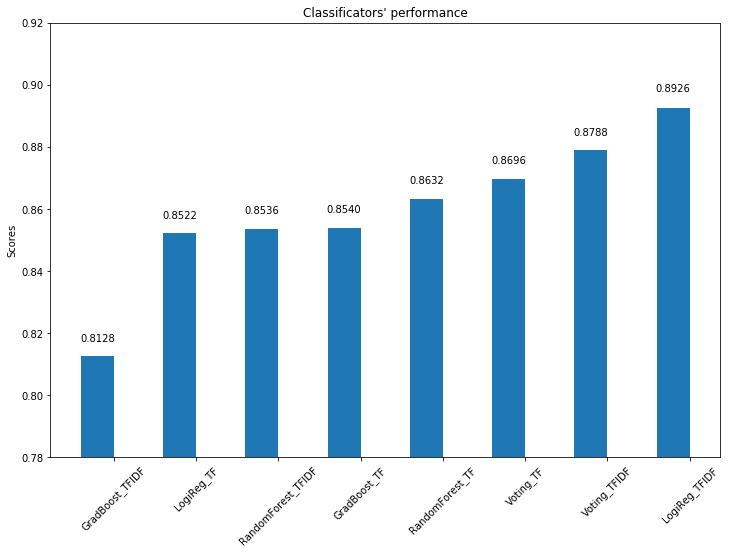

In [48]:
dic_results = {'RandomForest_TF': eval_RF_tf_tts,
               'RandomForest_TFIDF': eval_RF_tfidf_tts,
               'LogiReg_TF': eval_LR_tf_tts,
               'LogiReg_TFIDF': eval_LR_tfidf_tts,
               'GradBoost_TF': eval_GBC_tf_tts,
               'GradBoost_TFIDF': eval_GBC_tfidf_tts,
               'Voting_TF': eval_vot_tf_tts,
               'Voting_TFIDF': eval_vot_tfidf_tts,
              }

import operator
tup_results = sorted(dic_results.items(), key=operator.itemgetter(1))

N = len(dic_results)
ind = np.arange(N)  # the x locations for the groups
width = 0.40       # the width of the bars

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
rects = ax.bar(ind, list(zip(*tup_results))[1], width,)
for rect in rects:
    height = rect.get_height()
    ax.text(rect.get_x()+rect.get_width()/2., 
            1.005*height, 
            '{0:.4f}'.format(height), 
            ha='center', 
            va='bottom',)

ax.set_ylabel('Scores')
ax.set_ylim(ymin=0.78,ymax = 0.92)
ax.set_title("Classificators' performance")
ax.set_xticks(ind + width/2.)
ax.set_xticklabels(list(zip(*tup_results))[0], rotation=45)

plt.show()

Creating a Submission  
--

All that remains is to run the best classifier on our test set and create a submission file. If you haven't already done so, download testData.tsv from the Data page. This file contains another 25,000 reviews and ids; our task is to predict the sentiment label.

Note that when we use the Bag of Words for the test set, we only call "transform", not "fit_transform" as we did for the training set. In machine learning, you shouldn't use the test set to fit your model, otherwise you run the risk of overfitting. For this reason, we keep the test set off-limits until we are ready to make predictions.

In [49]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
id        25000 non-null object
review    25000 non-null object
dtypes: object(2)
memory usage: 390.7+ KB


In [50]:
test.head()

,id,review
0,"""12311_10""","""Naturally in a film who's main themes are of ..."
1,"""8348_2""","""This movie is a disaster within a disaster fi..."
2,"""5828_4""","""All in all, this is a movie for kids. We saw ..."
3,"""7186_2""","""Afraid of the Dark left me with the impressio..."
4,"""12128_7""","""A very accurate depiction of small time mob l..."


In [51]:
test_data_features_tfidf.shape

(25000, 5000)

In [52]:
# Use the logistic regression with tfidf vectors to make sentiment label predictions
result = clf_LR_tfidf.predict(test_data_features_tfidf)
result_prob = clf_LR_tfidf.predict_proba(test_data_features_tfidf)
output = pd.DataFrame(data={"id":test["id"], "sentiment":result,})# "probs":result_prob[:,1]})
# Use pandas to write the comma-separated output file
output.to_csv(os.path.join(outputs,'LR_tfidf_model.csv'), index=False, quoting=3)

In [53]:
output.head()

,id,sentiment
0,"""12311_10""",0
1,"""8348_2""",0
2,"""5828_4""",0
3,"""7186_2""",0
4,"""12128_7""",0


Part 2: Alternative Vectors
--

In the subsequent sections, we are going to explore alternate ways to codify text into vectors. We are going to explore three techniques, namely Latent Semantic Indexing (LSI), Latent Dirichlet Allocation (LDA) and Word2vec.

### Topic Modeling and Topic Vectors

To build the models, the more we have texts, the better. The size of the Corpus is essential for having good results. We don't need labels in order to create the models, so we will use the train examples and also some unlabeled reviews. The list of cleaned sentences will be used for all the subsequent models.

In [54]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [55]:
print("Parsing sentences from training set")
labeled_sentences = Text_Cleaning_Utilities.df_to_list_of_tokens(train,
                                                                 'review', 
                                                                 remove_html=True,
                                                                 remove_stopwords=True,)
print("Parsing sentences from unlabeled set")
all_sentences = labeled_sentences + Text_Cleaning_Utilities.df_to_list_of_tokens(unlabeled_train,
                                                                                 'review', 
                                                                                 remove_html=True,
                                                                                 remove_stopwords=True,)

print("Parsing sentences from test set")
test_labeled_sentences = Text_Cleaning_Utilities.df_to_list_of_tokens(test,
                                                                      'review', 
                                                                      remove_html=True,
                                                                      remove_stopwords=True,)

print("Parsing sentences with stopwords from training set")
labeled_sentences_sw = Text_Cleaning_Utilities.df_to_list_of_tokens(train,
                                                                    'review', 
                                                                    remove_html=True,
                                                                    remove_stopwords=False,)

print("Parsing sentences with stopwords from unlabeled set")
all_sentences_sw = labeled_sentences_sw + Text_Cleaning_Utilities.df_to_list_of_tokens(unlabeled_train,
                                                                                       'review', 
                                                                                       remove_html=True,
                                                                                       remove_stopwords=False,)

print("Parsing sentences with stopwords from test set")
test_labeled_sentences_sw = Text_Cleaning_Utilities.df_to_list_of_tokens(test,
                                                                         'review', 
                                                                         remove_html=True,
                                                                         remove_stopwords=False,)

Parsing sentences from training set
Parsing sentences from unlabeled set
Parsing sentences from test set
Parsing sentences with stopwords from training set
Parsing sentences with stopwords from unlabeled set
Parsing sentences with stopwords from test set


In [56]:
print(len(labeled_sentences))
print(len(all_sentences))
print(len(test_labeled_sentences))
print(len(labeled_sentences_sw))
print(len(all_sentences_sw))
print(len(test_labeled_sentences_sw))

25000
75000
25000
25000
75000
25000


Saving sentences to a Pickle

In [57]:
with open(os.path.join(outputs, 'sentences.pkl'),'wb') as f:
    pickle.dump((labeled_sentences,
                 all_sentences,
                 test_labeled_sentences,
                 labeled_sentences_sw,
                 all_sentences_sw,
                 test_labeled_sentences_sw,), f)

Loading sentences from a Pickle

In [58]:
with open(os.path.join(outputs, 'sentences.pkl'),'rb') as f:
    (labeled_sentences,
     all_sentences,
     test_labeled_sentences,
     labeled_sentences_sw,
     all_sentences_sw,
     test_labeled_sentences_sw,) = pickle.load(f)

In [59]:
def nltk_stopwords():
    return set(nltk.corpus.stopwords.words('english'))

def prep_corpus(docs, additional_stopwords=set(), no_below=4, no_above=0.7):
    print('Building dictionary...')
    dictionary = corpora.Dictionary(docs)
    print('{} Tokens extracted from {} texts'.format(len(dictionary.keys()), dictionary.num_docs))
    stopwords = nltk_stopwords().union(additional_stopwords)
    #stopword_ids = [dictionary.token2id[sw] for sw in stopwords if sw in dictionary.token2id]
    stopword_ids = map(dictionary.token2id.get, stopwords)
    dictionary.filter_tokens(stopword_ids)
    #low_freq_ids = [tokenid for tokenid, docfreq in dictionary.dfs.items() if docfreq < 4]
    #dictionary.filter_tokens(low_freq_ids)
    dictionary.filter_extremes(no_below=no_below, no_above=no_above, keep_n=None)
    dictionary.compactify()
    print('{} Tokens after cleaning'.format(len(dictionary.keys())))
    #print('Building corpus...')
    #corpus = [dictionary.doc2bow(doc) for doc in docs]
    return dictionary #, corpus

Compacting and saving the dictionary

In [60]:
additional_stopwords=set(['n\'t', 'movie'])

dictionary = prep_corpus(all_sentences, additional_stopwords)
dictionary.compactify()
print('dictionary done')

dictionary.save(os.path.join(outputs, 'reviews.dict'))
print('dictionary saved')

2017-10-09 11:56:30,002 : INFO : adding document #0 to Dictionary(0 unique tokens: [])


Building dictionary...


2017-10-09 11:56:31,951 : INFO : adding document #10000 to Dictionary(74918 unique tokens: ['trey', 'project-like', 'pre-nypd', 'trimmings', 'running-time']...)
2017-10-09 11:56:33,652 : INFO : adding document #20000 to Dictionary(110848 unique tokens: ['trey', 'trial.i', 'rarest', 'filtering', 'hair']...)
2017-10-09 11:56:35,341 : INFO : adding document #30000 to Dictionary(142847 unique tokens: ['trey', 'film.milland', 'trial.i', 'disembark', 'rarest']...)
2017-10-09 11:56:37,059 : INFO : adding document #40000 to Dictionary(171895 unique tokens: ['spahetti', 'trey', 'film.milland', 'whiteys', 'trial.i']...)
2017-10-09 11:56:38,824 : INFO : adding document #50000 to Dictionary(198534 unique tokens: ['collier', 'trey', 'film.milland', 'whiteys', 'hair']...)
2017-10-09 11:56:40,548 : INFO : adding document #60000 to Dictionary(222959 unique tokens: ['collier', 'trey', 'film.milland', 'whiteys', 'hair']...)
2017-10-09 11:56:42,257 : INFO : adding document #70000 to Dictionary(245709 uni

256792 Tokens extracted from 75000 texts


2017-10-09 11:56:44,343 : INFO : discarding 200412 tokens: [('sequence.because', 1), ('whiteys', 2), ('feet.in', 1), ('penelope-ann', 1), ('tree/corner', 1), ('dgse', 3), ('has-beenville', 1), ('film.milland', 1), ('pujari', 1), ('selter', 1)]...
2017-10-09 11:56:44,345 : INFO : keeping 56378 tokens which were in no less than 4 and no more than 52500 (=70.0%) documents
2017-10-09 11:56:44,598 : INFO : resulting dictionary: Dictionary(56378 unique tokens: ['trey', 'collecting', 'thrashing', 'rarest', 'running-time']...)
2017-10-09 11:56:44,790 : INFO : saving Dictionary object under ../outputs/reviews.dict, separately None
2017-10-09 11:56:44,825 : INFO : saved ../outputs/reviews.dict


56378 Tokens after cleaning
dictionary done
dictionary saved


In [61]:
#print(dictionary.token2id['movie']) #verify if these words were in the stopwords list
#print(dictionary.token2id['n\'t'])
print(dictionary.token2id['like'])

36278


Loading dictionary

In [62]:
dictionary = corpora.dictionary.Dictionary.load(os.path.join(outputs, 'reviews.dict'))

2017-10-09 11:56:44,927 : INFO : loading Dictionary object from ../outputs/reviews.dict
2017-10-09 11:56:44,960 : INFO : loaded ../outputs/reviews.dict


Generating the Corpora (tf and tfidf

In [63]:
corpus_tf = [dictionary.doc2bow(sentence) for sentence in all_sentences]
print('corpus tf done')
tfidf = models.TfidfModel(corpus_tf)
corpus_tfidf = tfidf[corpus_tf]
print('corpus tfidf done')

2017-10-09 11:56:57,033 : INFO : collecting document frequencies
2017-10-09 11:56:57,034 : INFO : PROGRESS: processing document #0


corpus tf done


2017-10-09 11:56:57,332 : INFO : PROGRESS: processing document #10000
2017-10-09 11:56:57,629 : INFO : PROGRESS: processing document #20000
2017-10-09 11:56:57,919 : INFO : PROGRESS: processing document #30000
2017-10-09 11:56:58,208 : INFO : PROGRESS: processing document #40000
2017-10-09 11:56:58,502 : INFO : PROGRESS: processing document #50000
2017-10-09 11:56:58,804 : INFO : PROGRESS: processing document #60000
2017-10-09 11:56:59,095 : INFO : PROGRESS: processing document #70000
2017-10-09 11:56:59,249 : INFO : calculating IDF weights for 75000 documents and 56377 features (7099218 matrix non-zeros)


corpus tfidf done


Saving the Corpora

In [64]:
corpora.MmCorpus.serialize(os.path.join(outputs, 'corpus_tf.mm'), corpus_tf)
corpora.MmCorpus.serialize(os.path.join(outputs, 'corpus_tfidf.mm'), corpus_tfidf)

2017-10-09 11:56:59,296 : INFO : storing corpus in Matrix Market format to ../outputs/corpus_tf.mm
2017-10-09 11:56:59,298 : INFO : saving sparse matrix to ../outputs/corpus_tf.mm
2017-10-09 11:56:59,299 : INFO : PROGRESS: saving document #0
2017-10-09 11:56:59,485 : INFO : PROGRESS: saving document #1000
2017-10-09 11:56:59,673 : INFO : PROGRESS: saving document #2000
2017-10-09 11:56:59,859 : INFO : PROGRESS: saving document #3000
2017-10-09 11:57:00,050 : INFO : PROGRESS: saving document #4000
2017-10-09 11:57:00,235 : INFO : PROGRESS: saving document #5000
2017-10-09 11:57:00,417 : INFO : PROGRESS: saving document #6000
2017-10-09 11:57:00,609 : INFO : PROGRESS: saving document #7000
2017-10-09 11:57:00,792 : INFO : PROGRESS: saving document #8000
2017-10-09 11:57:00,981 : INFO : PROGRESS: saving document #9000
2017-10-09 11:57:01,160 : INFO : PROGRESS: saving document #10000
2017-10-09 11:57:01,347 : INFO : PROGRESS: saving document #11000
2017-10-09 11:57:01,528 : INFO : PROGRESS

2017-10-09 11:57:33,874 : INFO : PROGRESS: saving document #42000
2017-10-09 11:57:34,314 : INFO : PROGRESS: saving document #43000
2017-10-09 11:57:34,770 : INFO : PROGRESS: saving document #44000
2017-10-09 11:57:35,225 : INFO : PROGRESS: saving document #45000
2017-10-09 11:57:35,662 : INFO : PROGRESS: saving document #46000
2017-10-09 11:57:36,109 : INFO : PROGRESS: saving document #47000
2017-10-09 11:57:36,563 : INFO : PROGRESS: saving document #48000
2017-10-09 11:57:37,007 : INFO : PROGRESS: saving document #49000
2017-10-09 11:57:37,440 : INFO : PROGRESS: saving document #50000
2017-10-09 11:57:37,875 : INFO : PROGRESS: saving document #51000
2017-10-09 11:57:38,319 : INFO : PROGRESS: saving document #52000
2017-10-09 11:57:38,763 : INFO : PROGRESS: saving document #53000
2017-10-09 11:57:39,200 : INFO : PROGRESS: saving document #54000
2017-10-09 11:57:39,651 : INFO : PROGRESS: saving document #55000
2017-10-09 11:57:40,095 : INFO : PROGRESS: saving document #56000
2017-10-09

Loading the Corpora

In [65]:
corpus_tf = corpora.MmCorpus(os.path.join(outputs, 'corpus_tf.mm'))
corpus_tfidf = corpora.MmCorpus(os.path.join(outputs, 'corpus_tfidf.mm'))

2017-10-09 11:57:49,732 : INFO : loaded corpus index from ../outputs/corpus_tf.mm.index
2017-10-09 11:57:49,733 : INFO : initializing corpus reader from ../outputs/corpus_tf.mm
2017-10-09 11:57:49,734 : INFO : accepted corpus with 75000 documents, 56378 features, 7099218 non-zero entries
2017-10-09 11:57:49,745 : INFO : loaded corpus index from ../outputs/corpus_tfidf.mm.index
2017-10-09 11:57:49,746 : INFO : initializing corpus reader from ../outputs/corpus_tfidf.mm
2017-10-09 11:57:49,747 : INFO : accepted corpus with 75000 documents, 56378 features, 7099218 non-zero entries


### Latent Semantic Indexing
https://en.wikipedia.org/wiki/Latent_semantic_analysis  

Generating the Models and the Corpora

In [66]:
lsi_tf = models.LsiModel(corpus_tf, id2word=dictionary, num_topics=10)
corpus_lsi_tf = lsi_tf[corpus_tf]
print('corpus lsi - TF done')
lsi_tfidf = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=10)
corpus_lsi_tfidf = lsi_tfidf[corpus_tfidf]
print('corpus lsi - TFIDF done')

2017-10-09 11:57:50,328 : INFO : using serial LSI version on this node
2017-10-09 11:57:50,329 : INFO : updating model with new documents
2017-10-09 11:57:56,895 : INFO : preparing a new chunk of documents
2017-10-09 11:57:57,523 : INFO : using 100 extra samples and 2 power iterations
2017-10-09 11:57:57,525 : INFO : 1st phase: constructing (56378, 110) action matrix
2017-10-09 11:57:57,986 : INFO : orthonormalizing (56378, 110) action matrix
2017-10-09 11:58:01,412 : INFO : 2nd phase: running dense svd on (110, 20000) matrix
2017-10-09 11:58:01,973 : INFO : computing the final decomposition
2017-10-09 11:58:01,975 : INFO : keeping 10 factors (discarding 48.506% of energy spectrum)
2017-10-09 11:58:02,009 : INFO : processed documents up to #20000
2017-10-09 11:58:02,042 : INFO : topic #0(627.645): 0.511*"film" + 0.285*"one" + 0.216*"like" + 0.146*"good" + 0.146*"would" + 0.139*"even" + 0.125*"really" + 0.124*"time" + 0.120*"story" + 0.117*"see"
2017-10-09 11:58:02,045 : INFO : topic #1

corpus lsi - TF done


2017-10-09 11:58:44,887 : INFO : preparing a new chunk of documents
2017-10-09 11:58:45,462 : INFO : using 100 extra samples and 2 power iterations
2017-10-09 11:58:45,463 : INFO : 1st phase: constructing (56378, 110) action matrix
2017-10-09 11:58:45,916 : INFO : orthonormalizing (56378, 110) action matrix
2017-10-09 11:58:49,356 : INFO : 2nd phase: running dense svd on (110, 20000) matrix
2017-10-09 11:58:49,868 : INFO : computing the final decomposition
2017-10-09 11:58:49,870 : INFO : keeping 10 factors (discarding 63.603% of energy spectrum)
2017-10-09 11:58:49,904 : INFO : processed documents up to #20000
2017-10-09 11:58:49,911 : INFO : topic #0(17.738): 0.145*"film" + 0.102*"bad" + 0.101*"really" + 0.101*"good" + 0.101*"like" + 0.094*"would" + 0.093*"one" + 0.091*"story" + 0.089*"even" + 0.088*"see"
2017-10-09 11:58:49,919 : INFO : topic #1(6.219): 0.325*"bad" + 0.196*"worst" + 0.153*"waste" + 0.134*"movies" + 0.125*"acting" + 0.115*"horror" + 0.112*"terrible" + 0.107*"ever" + 

corpus lsi - TFIDF done


Saving the Models and the Corpora

In [67]:
lsi_tf.save(os.path.join(outputs, 'model_tf.lsi'))
corpora.MmCorpus.serialize(os.path.join(outputs, 'corpus_lsi_tf.mm'), corpus_lsi_tf)
lsi_tfidf.save(os.path.join(outputs, 'model_tfidf.lsi'))
corpora.MmCorpus.serialize(os.path.join(outputs, 'corpus_lsi_tfidf.mm'), corpus_lsi_tfidf)

2017-10-09 11:59:26,019 : INFO : saving Projection object under ../outputs/model_tf.lsi.projection, separately None
2017-10-09 11:59:26,053 : INFO : saved ../outputs/model_tf.lsi.projection
2017-10-09 11:59:26,055 : INFO : saving LsiModel object under ../outputs/model_tf.lsi, separately None
2017-10-09 11:59:26,056 : INFO : not storing attribute dispatcher
2017-10-09 11:59:26,056 : INFO : not storing attribute projection
2017-10-09 11:59:26,087 : INFO : saved ../outputs/model_tf.lsi
2017-10-09 11:59:26,090 : INFO : storing corpus in Matrix Market format to ../outputs/corpus_lsi_tf.mm
2017-10-09 11:59:26,091 : INFO : saving sparse matrix to ../outputs/corpus_lsi_tf.mm
2017-10-09 11:59:26,280 : INFO : PROGRESS: saving document #0
2017-10-09 11:59:26,554 : INFO : PROGRESS: saving document #1000
2017-10-09 11:59:27,020 : INFO : PROGRESS: saving document #2000
2017-10-09 11:59:27,483 : INFO : PROGRESS: saving document #3000
2017-10-09 11:59:27,954 : INFO : PROGRESS: saving document #4000
20

2017-10-09 12:00:17,467 : INFO : PROGRESS: saving document #27000
2017-10-09 12:00:17,990 : INFO : PROGRESS: saving document #28000
2017-10-09 12:00:18,510 : INFO : PROGRESS: saving document #29000
2017-10-09 12:00:19,043 : INFO : PROGRESS: saving document #30000
2017-10-09 12:00:19,570 : INFO : PROGRESS: saving document #31000
2017-10-09 12:00:20,096 : INFO : PROGRESS: saving document #32000
2017-10-09 12:00:20,626 : INFO : PROGRESS: saving document #33000
2017-10-09 12:00:21,153 : INFO : PROGRESS: saving document #34000
2017-10-09 12:00:21,691 : INFO : PROGRESS: saving document #35000
2017-10-09 12:00:22,214 : INFO : PROGRESS: saving document #36000
2017-10-09 12:00:22,768 : INFO : PROGRESS: saving document #37000
2017-10-09 12:00:23,305 : INFO : PROGRESS: saving document #38000
2017-10-09 12:00:23,839 : INFO : PROGRESS: saving document #39000
2017-10-09 12:00:24,368 : INFO : PROGRESS: saving document #40000
2017-10-09 12:00:24,901 : INFO : PROGRESS: saving document #41000
2017-10-09

Loading the Models and the Corpora

In [68]:
lsi_tf = models.LsiModel.load(os.path.join(outputs, 'model_tf.lsi'))
corpus_lsi_tf = corpora.MmCorpus(os.path.join(outputs, 'corpus_lsi_tf.mm'))
lsi_tfidf = models.LsiModel.load(os.path.join(outputs, 'model_tfidf.lsi'))
corpus_lsi_tfidf = corpora.MmCorpus(os.path.join(outputs, 'corpus_lsi_tfidf.mm'))

2017-10-09 12:00:42,859 : INFO : loading LsiModel object from ../outputs/model_tf.lsi
2017-10-09 12:00:42,895 : INFO : loading id2word recursively from ../outputs/model_tf.lsi.id2word.* with mmap=None
2017-10-09 12:00:42,896 : INFO : setting ignored attribute dispatcher to None
2017-10-09 12:00:42,897 : INFO : setting ignored attribute projection to None
2017-10-09 12:00:42,897 : INFO : loaded ../outputs/model_tf.lsi
2017-10-09 12:00:42,898 : INFO : loading LsiModel object from ../outputs/model_tf.lsi.projection
2017-10-09 12:00:42,929 : INFO : loaded ../outputs/model_tf.lsi.projection
2017-10-09 12:00:42,940 : INFO : loaded corpus index from ../outputs/corpus_lsi_tf.mm.index
2017-10-09 12:00:42,941 : INFO : initializing corpus reader from ../outputs/corpus_lsi_tf.mm
2017-10-09 12:00:42,942 : INFO : accepted corpus with 75000 documents, 10 features, 750000 non-zero entries
2017-10-09 12:00:42,943 : INFO : loading LsiModel object from ../outputs/model_tfidf.lsi
2017-10-09 12:00:42,972 :

#### Visualizing the topics

In [69]:
lsi_tf.print_topics(10)

2017-10-09 12:00:43,119 : INFO : topic #0(1213.661): 0.508*"film" + 0.290*"one" + 0.218*"like" + 0.147*"would" + 0.145*"good" + 0.137*"even" + 0.125*"time" + 0.123*"really" + 0.119*"story" + 0.117*"see"
2017-10-09 12:00:43,123 : INFO : topic #1(518.759): -0.833*"film" + 0.214*"one" + 0.195*"like" + 0.113*"show" + 0.105*"movies" + 0.105*"good" + 0.101*"would" + 0.093*"even" + 0.092*"really" + 0.085*"get"
2017-10-09 12:00:43,127 : INFO : topic #2(320.997): -0.728*"one" + 0.456*"like" + 0.179*"bad" + 0.164*"really" + 0.153*"good" + 0.123*"would" + 0.095*"people" + 0.079*"think" + -0.076*"two" + 0.072*"could"
2017-10-09 12:00:43,130 : INFO : topic #3(286.580): -0.493*"one" + -0.423*"like" + 0.332*"story" + -0.244*"bad" + 0.139*"show" + 0.138*"great" + 0.137*"also" + 0.137*"life" + 0.129*"love" + 0.119*"character"
2017-10-09 12:00:43,133 : INFO : topic #4(276.279): -0.622*"good" + 0.409*"like" + -0.309*"bad" + -0.249*"really" + 0.157*"would" + 0.144*"people" + 0.131*"show" + -0.130*"acting"

[(0,
  '0.508*"film" + 0.290*"one" + 0.218*"like" + 0.147*"would" + 0.145*"good" + 0.137*"even" + 0.125*"time" + 0.123*"really" + 0.119*"story" + 0.117*"see"'),
 (1,
  '-0.833*"film" + 0.214*"one" + 0.195*"like" + 0.113*"show" + 0.105*"movies" + 0.105*"good" + 0.101*"would" + 0.093*"even" + 0.092*"really" + 0.085*"get"'),
 (2,
  '-0.728*"one" + 0.456*"like" + 0.179*"bad" + 0.164*"really" + 0.153*"good" + 0.123*"would" + 0.095*"people" + 0.079*"think" + -0.076*"two" + 0.072*"could"'),
 (3,
  '-0.493*"one" + -0.423*"like" + 0.332*"story" + -0.244*"bad" + 0.139*"show" + 0.138*"great" + 0.137*"also" + 0.137*"life" + 0.129*"love" + 0.119*"character"'),
 (4,
  '-0.622*"good" + 0.409*"like" + -0.309*"bad" + -0.249*"really" + 0.157*"would" + 0.144*"people" + 0.131*"show" + -0.130*"acting" + 0.118*"life" + -0.116*"great"'),
 (5,
  '-0.523*"like" + 0.479*"would" + 0.234*"bad" + -0.226*"story" + 0.223*"even" + -0.196*"good" + 0.195*"could" + -0.183*"great" + -0.143*"also" + 0.101*"get"'),
 (6,
  

In [70]:
lsi_tf.show_topic(1)

[('film', -0.83285602930576319),
 ('one', 0.21358068706531744),
 ('like', 0.19495154080015714),
 ('show', 0.11342920656775581),
 ('movies', 0.10544608293343995),
 ('good', 0.10518145072354432),
 ('would', 0.10064176334448971),
 ('even', 0.092790951177265157),
 ('really', 0.091549031431802499),
 ('get', 0.084735196884789074)]

In [71]:
lsi_tfidf.print_topics(10)

2017-10-09 12:00:43,469 : INFO : topic #0(34.212): 0.146*"film" + 0.103*"bad" + 0.101*"good" + 0.101*"like" + 0.101*"really" + 0.095*"one" + 0.094*"would" + 0.091*"story" + 0.089*"see" + 0.088*"even"
2017-10-09 12:00:43,474 : INFO : topic #1(11.689): 0.333*"bad" + 0.200*"worst" + 0.131*"waste" + 0.130*"movies" + 0.129*"acting" + 0.115*"terrible" + 0.114*"ever" + 0.106*"horror" + 0.104*"horrible" + 0.102*"stupid"
2017-10-09 12:00:43,477 : INFO : topic #2(10.718): 0.670*"show" + 0.212*"episode" + 0.209*"series" + -0.171*"film" + 0.151*"tv" + 0.150*"episodes" + 0.144*"season" + -0.143*"horror" + 0.128*"funny" + 0.117*"shows"
2017-10-09 12:00:43,480 : INFO : topic #3(9.258): -0.234*"show" + 0.219*"great" + 0.211*"book" + -0.178*"horror" + 0.115*"movies" + 0.113*"love" + 0.107*"seen" + 0.104*"read" + 0.103*"best" + 0.100*"wonderful"
2017-10-09 12:00:43,484 : INFO : topic #4(8.942): 0.262*"horror" + 0.216*"series" + 0.165*"action" + -0.162*"life" + -0.159*"people" + 0.136*"great" + 0.136*"sh

[(0,
  '0.146*"film" + 0.103*"bad" + 0.101*"good" + 0.101*"like" + 0.101*"really" + 0.095*"one" + 0.094*"would" + 0.091*"story" + 0.089*"see" + 0.088*"even"'),
 (1,
  '0.333*"bad" + 0.200*"worst" + 0.131*"waste" + 0.130*"movies" + 0.129*"acting" + 0.115*"terrible" + 0.114*"ever" + 0.106*"horror" + 0.104*"horrible" + 0.102*"stupid"'),
 (2,
  '0.670*"show" + 0.212*"episode" + 0.209*"series" + -0.171*"film" + 0.151*"tv" + 0.150*"episodes" + 0.144*"season" + -0.143*"horror" + 0.128*"funny" + 0.117*"shows"'),
 (3,
  '-0.234*"show" + 0.219*"great" + 0.211*"book" + -0.178*"horror" + 0.115*"movies" + 0.113*"love" + 0.107*"seen" + 0.104*"read" + 0.103*"best" + 0.100*"wonderful"'),
 (4,
  '0.262*"horror" + 0.216*"series" + 0.165*"action" + -0.162*"life" + -0.159*"people" + 0.136*"great" + 0.136*"show" + 0.127*"original" + 0.126*"effects" + -0.124*"book"'),
 (5,
  '-0.395*"book" + 0.351*"funny" + 0.260*"comedy" + -0.196*"series" + -0.160*"read" + 0.125*"jokes" + 0.117*"laugh" + 0.104*"fun" + 0.10

In [72]:
lsi_tfidf.show_topic(1)

[('bad', 0.33319651343340911),
 ('worst', 0.19989007343861914),
 ('waste', 0.13135093948036103),
 ('movies', 0.13003572740999733),
 ('acting', 0.1290409018220291),
 ('terrible', 0.11522984607907573),
 ('ever', 0.11439156308265519),
 ('horror', 0.10613287578954197),
 ('horrible', 0.10447137645254814),
 ('stupid', 0.10180575117242487)]

### Latent Dirichlet Allocation

https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation  

#### Using Gensim

Generating the Models and the Corpora

In [73]:
lda_tf = models.LdaModel(corpus_tf, id2word=dictionary, num_topics=10, passes=10)
corpus_lda_tf = lda_tf[corpus_tf]
print('corpus lda tf done')

lda_tfidf = models.LdaModel(corpus_tfidf, id2word=dictionary, num_topics=10, passes=10)
corpus_lda_tfidf = lda_tfidf[corpus_tfidf]
print('corpus lda tfidf done')

2017-10-09 12:00:43,799 : INFO : using symmetric alpha at 0.1
2017-10-09 12:00:43,801 : INFO : using symmetric eta at 1.7737415303841924e-05
2017-10-09 12:00:43,824 : INFO : using serial LDA version on this node
2017-10-09 12:00:51,235 : INFO : running online LDA training, 10 topics, 10 passes over the supplied corpus of 75000 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2017-10-09 12:00:51,894 : INFO : PROGRESS: pass 0, at document #2000/75000
2017-10-09 12:00:58,853 : INFO : merging changes from 2000 documents into a model of 75000 documents
2017-10-09 12:00:59,470 : INFO : topic #2 (0.100): 0.015*"film" + 0.011*"one" + 0.005*"like" + 0.005*"even" + 0.005*"would" + 0.004*"well" + 0.004*"bad" + 0.004*"time" + 0.004*"good" + 0.004*"see"
2017-10-09 12:00:59,473 : INFO : topic #0 (0.100): 0.013*"one" + 0.011*"film" + 0.008*"good" + 0.006*"time" + 0.005*"get" + 0.005*"like" + 0.004*

2017-10-09 12:01:52,176 : INFO : topic #7 (0.100): 0.014*"film" + 0.010*"one" + 0.010*"good" + 0.008*"like" + 0.008*"really" + 0.006*"story" + 0.006*"bad" + 0.005*"movies" + 0.005*"time" + 0.005*"much"
2017-10-09 12:01:52,178 : INFO : topic #4 (0.100): 0.010*"film" + 0.007*"like" + 0.007*"one" + 0.005*"see" + 0.005*"great" + 0.004*"story" + 0.004*"first" + 0.004*"really" + 0.004*"little" + 0.004*"also"
2017-10-09 12:01:52,180 : INFO : topic #3 (0.100): 0.015*"like" + 0.014*"film" + 0.010*"people" + 0.009*"one" + 0.007*"see" + 0.007*"would" + 0.006*"even" + 0.005*"really" + 0.005*"think" + 0.005*"time"
2017-10-09 12:01:52,181 : INFO : topic #6 (0.100): 0.009*"film" + 0.006*"one" + 0.004*"like" + 0.004*"story" + 0.003*"young" + 0.003*"man" + 0.003*"little" + 0.003*"way" + 0.003*"even" + 0.003*"family"
2017-10-09 12:01:52,183 : INFO : topic diff=0.600577, rho=0.377964
2017-10-09 12:01:52,847 : INFO : PROGRESS: pass 0, at document #16000/75000
2017-10-09 12:01:59,392 : INFO : merging chang

2017-10-09 12:03:01,373 : INFO : topic #6 (0.100): 0.008*"film" + 0.006*"one" + 0.004*"young" + 0.004*"father" + 0.004*"man" + 0.004*"family" + 0.004*"story" + 0.003*"like" + 0.003*"wife" + 0.003*"little"
2017-10-09 12:03:01,375 : INFO : topic diff=0.415783, rho=0.277350
2017-10-09 12:03:02,041 : INFO : PROGRESS: pass 0, at document #28000/75000
2017-10-09 12:03:08,360 : INFO : merging changes from 2000 documents into a model of 75000 documents
2017-10-09 12:03:09,345 : INFO : topic #9 (0.100): 0.013*"film" + 0.008*"one" + 0.007*"great" + 0.006*"good" + 0.006*"love" + 0.005*"best" + 0.005*"well" + 0.005*"also" + 0.005*"role" + 0.004*"performance"
2017-10-09 12:03:09,348 : INFO : topic #8 (0.100): 0.023*"film" + 0.012*"one" + 0.011*"bad" + 0.009*"even" + 0.008*"like" + 0.008*"could" + 0.008*"good" + 0.008*"would" + 0.007*"acting" + 0.006*"made"
2017-10-09 12:03:09,349 : INFO : topic #6 (0.100): 0.008*"film" + 0.006*"one" + 0.004*"young" + 0.004*"father" + 0.004*"man" + 0.004*"family" + 

2017-10-09 12:04:17,401 : INFO : topic #2 (0.100): 0.027*"film" + 0.008*"one" + 0.008*"story" + 0.005*"characters" + 0.005*"well" + 0.004*"many" + 0.004*"also" + 0.004*"life" + 0.003*"films" + 0.003*"time"
2017-10-09 12:04:17,403 : INFO : topic #5 (0.100): 0.007*"one" + 0.006*"film" + 0.005*"like" + 0.004*"game" + 0.004*"get" + 0.004*"bad" + 0.004*"even" + 0.004*"scene" + 0.003*"action" + 0.003*"guy"
2017-10-09 12:04:17,405 : INFO : topic #4 (0.100): 0.008*"film" + 0.006*"like" + 0.006*"one" + 0.005*"great" + 0.004*"little" + 0.004*"story" + 0.004*"first" + 0.004*"disney" + 0.004*"also" + 0.004*"animation"
2017-10-09 12:04:17,407 : INFO : topic #0 (0.100): 0.022*"show" + 0.012*"series" + 0.011*"one" + 0.007*"episode" + 0.007*"tv" + 0.006*"like" + 0.006*"time" + 0.006*"first" + 0.006*"good" + 0.005*"funny"
2017-10-09 12:04:17,409 : INFO : topic diff=0.270771, rho=0.223607
2017-10-09 12:04:18,077 : INFO : PROGRESS: pass 0, at document #42000/75000
2017-10-09 12:04:24,355 : INFO : merging

2017-10-09 12:05:02,395 : INFO : topic diff=0.189233, rho=0.196116
2017-10-09 12:05:03,087 : INFO : PROGRESS: pass 0, at document #54000/75000
2017-10-09 12:05:08,899 : INFO : merging changes from 2000 documents into a model of 75000 documents
2017-10-09 12:05:09,590 : INFO : topic #9 (0.100): 0.013*"film" + 0.009*"one" + 0.009*"great" + 0.007*"love" + 0.006*"role" + 0.006*"good" + 0.006*"best" + 0.006*"performance" + 0.005*"also" + 0.005*"well"
2017-10-09 12:05:09,593 : INFO : topic #8 (0.100): 0.023*"film" + 0.014*"bad" + 0.012*"one" + 0.011*"even" + 0.009*"acting" + 0.009*"like" + 0.008*"could" + 0.008*"good" + 0.008*"would" + 0.006*"made"
2017-10-09 12:05:09,595 : INFO : topic #1 (0.100): 0.012*"film" + 0.006*"one" + 0.006*"war" + 0.005*"man" + 0.004*"woman" + 0.004*"women" + 0.004*"two" + 0.003*"men" + 0.003*"life" + 0.003*"young"
2017-10-09 12:05:09,597 : INFO : topic #4 (0.100): 0.006*"film" + 0.006*"one" + 0.005*"like" + 0.005*"animation" + 0.005*"great" + 0.005*"disney" + 0.00

2017-10-09 12:06:10,973 : INFO : topic #4 (0.100): 0.006*"animation" + 0.006*"film" + 0.006*"one" + 0.005*"disney" + 0.005*"like" + 0.005*"great" + 0.004*"little" + 0.004*"king" + 0.004*"children" + 0.004*"music"
2017-10-09 12:06:10,976 : INFO : topic #7 (0.100): 0.016*"film" + 0.012*"one" + 0.012*"good" + 0.010*"like" + 0.009*"really" + 0.008*"horror" + 0.006*"much" + 0.006*"well" + 0.006*"story" + 0.006*"movies"
2017-10-09 12:06:10,977 : INFO : topic #9 (0.100): 0.013*"film" + 0.010*"great" + 0.010*"one" + 0.007*"role" + 0.006*"best" + 0.006*"good" + 0.006*"love" + 0.006*"performance" + 0.006*"also" + 0.005*"cast"
2017-10-09 12:06:10,979 : INFO : topic #0 (0.100): 0.026*"show" + 0.014*"series" + 0.010*"one" + 0.009*"tv" + 0.008*"episode" + 0.007*"funny" + 0.006*"like" + 0.006*"first" + 0.006*"time" + 0.005*"good"
2017-10-09 12:06:10,981 : INFO : topic diff=0.137051, rho=0.174078
2017-10-09 12:06:11,652 : INFO : PROGRESS: pass 0, at document #68000/75000
2017-10-09 12:06:17,287 : INFO

2017-10-09 12:06:59,371 : INFO : topic #4 (0.100): 0.006*"animation" + 0.005*"one" + 0.005*"king" + 0.005*"disney" + 0.005*"like" + 0.005*"film" + 0.005*"great" + 0.005*"children" + 0.004*"little" + 0.004*"music"
2017-10-09 12:06:59,373 : INFO : topic diff=0.128846, rho=0.159111
2017-10-09 12:07:00,040 : INFO : PROGRESS: pass 1, at document #4000/75000
2017-10-09 12:07:05,713 : INFO : merging changes from 2000 documents into a model of 75000 documents
2017-10-09 12:07:06,228 : INFO : topic #0 (0.100): 0.027*"show" + 0.013*"series" + 0.010*"one" + 0.009*"tv" + 0.008*"episode" + 0.008*"funny" + 0.006*"like" + 0.006*"time" + 0.006*"first" + 0.005*"comedy"
2017-10-09 12:07:06,231 : INFO : topic #2 (0.100): 0.033*"film" + 0.009*"story" + 0.008*"one" + 0.007*"characters" + 0.005*"many" + 0.005*"well" + 0.005*"films" + 0.005*"life" + 0.004*"also" + 0.004*"character"
2017-10-09 12:07:06,232 : INFO : topic #9 (0.100): 0.013*"film" + 0.010*"one" + 0.010*"great" + 0.007*"good" + 0.007*"best" + 0.

2017-10-09 12:07:46,784 : INFO : topic #7 (0.100): 0.016*"film" + 0.012*"one" + 0.012*"good" + 0.010*"like" + 0.009*"really" + 0.008*"horror" + 0.006*"much" + 0.006*"well" + 0.006*"story" + 0.006*"movies"
2017-10-09 12:07:46,786 : INFO : topic #1 (0.100): 0.010*"film" + 0.006*"war" + 0.006*"one" + 0.006*"man" + 0.004*"woman" + 0.004*"women" + 0.004*"men" + 0.003*"world" + 0.003*"two" + 0.003*"young"
2017-10-09 12:07:46,788 : INFO : topic #3 (0.100): 0.015*"like" + 0.012*"people" + 0.011*"would" + 0.011*"see" + 0.010*"one" + 0.009*"really" + 0.008*"think" + 0.008*"get" + 0.007*"know" + 0.007*"film"
2017-10-09 12:07:46,789 : INFO : topic #5 (0.100): 0.007*"one" + 0.005*"action" + 0.005*"game" + 0.005*"get" + 0.004*"like" + 0.004*"scene" + 0.004*"car" + 0.003*"guy" + 0.003*"bad" + 0.003*"gets"
2017-10-09 12:07:46,791 : INFO : topic diff=0.086535, rho=0.159111
2017-10-09 12:07:47,477 : INFO : PROGRESS: pass 1, at document #18000/75000
2017-10-09 12:07:53,344 : INFO : merging changes from 2

2017-10-09 12:08:45,960 : INFO : topic #4 (0.100): 0.007*"animation" + 0.007*"disney" + 0.005*"like" + 0.005*"one" + 0.005*"king" + 0.005*"children" + 0.005*"music" + 0.005*"great" + 0.005*"little" + 0.004*"animated"
2017-10-09 12:08:45,962 : INFO : topic diff=0.084472, rho=0.159111
2017-10-09 12:08:46,621 : INFO : PROGRESS: pass 1, at document #30000/75000
2017-10-09 12:08:52,350 : INFO : merging changes from 2000 documents into a model of 75000 documents
2017-10-09 12:08:52,745 : INFO : topic #6 (0.100): 0.006*"father" + 0.006*"young" + 0.006*"family" + 0.005*"man" + 0.005*"wife" + 0.005*"one" + 0.004*"son" + 0.004*"mother" + 0.004*"film" + 0.004*"old"
2017-10-09 12:08:52,747 : INFO : topic #2 (0.100): 0.033*"film" + 0.010*"story" + 0.008*"one" + 0.007*"characters" + 0.005*"well" + 0.005*"films" + 0.005*"many" + 0.005*"life" + 0.004*"also" + 0.004*"character"
2017-10-09 12:08:52,749 : INFO : topic #5 (0.100): 0.007*"one" + 0.005*"action" + 0.005*"get" + 0.005*"game" + 0.004*"scene" +

2017-10-09 12:09:51,709 : INFO : topic #1 (0.100): 0.009*"film" + 0.007*"war" + 0.005*"man" + 0.005*"one" + 0.004*"women" + 0.004*"men" + 0.004*"woman" + 0.003*"world" + 0.003*"american" + 0.003*"two"
2017-10-09 12:09:51,711 : INFO : topic #7 (0.100): 0.017*"film" + 0.012*"good" + 0.012*"one" + 0.010*"like" + 0.009*"really" + 0.009*"horror" + 0.006*"well" + 0.006*"much" + 0.006*"plot" + 0.006*"story"
2017-10-09 12:09:51,713 : INFO : topic #3 (0.100): 0.015*"like" + 0.012*"would" + 0.012*"people" + 0.011*"see" + 0.011*"one" + 0.009*"really" + 0.008*"think" + 0.008*"get" + 0.008*"know" + 0.007*"could"
2017-10-09 12:09:51,715 : INFO : topic #2 (0.100): 0.034*"film" + 0.010*"story" + 0.008*"one" + 0.007*"characters" + 0.005*"films" + 0.005*"well" + 0.005*"many" + 0.005*"life" + 0.004*"character" + 0.004*"also"
2017-10-09 12:09:51,717 : INFO : topic diff=0.068999, rho=0.159111
2017-10-09 12:09:53,879 : INFO : PROGRESS: pass 1, at document #44000/75000
2017-10-09 12:09:59,262 : INFO : mergin

2017-10-09 12:10:32,213 : INFO : topic #4 (0.100): 0.007*"animation" + 0.006*"disney" + 0.006*"music" + 0.005*"children" + 0.005*"king" + 0.005*"like" + 0.005*"one" + 0.005*"prince" + 0.005*"great" + 0.005*"little"
2017-10-09 12:10:32,215 : INFO : topic diff=0.062990, rho=0.159111
2017-10-09 12:10:32,882 : INFO : PROGRESS: pass 1, at document #56000/75000
2017-10-09 12:10:38,184 : INFO : merging changes from 2000 documents into a model of 75000 documents
2017-10-09 12:10:38,536 : INFO : topic #3 (0.100): 0.016*"like" + 0.012*"would" + 0.012*"people" + 0.011*"see" + 0.011*"one" + 0.009*"really" + 0.008*"think" + 0.008*"get" + 0.007*"know" + 0.007*"could"
2017-10-09 12:10:38,539 : INFO : topic #0 (0.100): 0.028*"show" + 0.015*"series" + 0.010*"funny" + 0.010*"one" + 0.009*"tv" + 0.009*"episode" + 0.007*"comedy" + 0.007*"like" + 0.007*"first" + 0.006*"time"
2017-10-09 12:10:38,541 : INFO : topic #1 (0.100): 0.009*"film" + 0.007*"war" + 0.005*"one" + 0.005*"man" + 0.004*"women" + 0.004*"me

2017-10-09 12:11:34,989 : INFO : topic #1 (0.100): 0.008*"film" + 0.007*"war" + 0.005*"one" + 0.005*"man" + 0.004*"women" + 0.004*"men" + 0.004*"american" + 0.004*"world" + 0.004*"woman" + 0.003*"us"
2017-10-09 12:11:34,991 : INFO : topic #9 (0.100): 0.014*"film" + 0.011*"one" + 0.010*"great" + 0.008*"role" + 0.007*"good" + 0.007*"best" + 0.006*"performance" + 0.006*"cast" + 0.006*"also" + 0.006*"love"
2017-10-09 12:11:34,993 : INFO : topic #7 (0.100): 0.018*"film" + 0.012*"one" + 0.012*"good" + 0.010*"like" + 0.009*"really" + 0.009*"horror" + 0.006*"well" + 0.006*"much" + 0.005*"plot" + 0.005*"movies"
2017-10-09 12:11:34,995 : INFO : topic #2 (0.100): 0.035*"film" + 0.010*"story" + 0.008*"one" + 0.007*"characters" + 0.005*"films" + 0.005*"many" + 0.005*"well" + 0.005*"life" + 0.005*"character" + 0.004*"also"
2017-10-09 12:11:34,996 : INFO : topic #0 (0.100): 0.028*"show" + 0.016*"series" + 0.011*"funny" + 0.010*"tv" + 0.010*"one" + 0.009*"episode" + 0.008*"comedy" + 0.007*"like" + 0.0

2017-10-09 12:12:18,594 : INFO : topic #5 (0.100): 0.007*"one" + 0.006*"action" + 0.005*"get" + 0.005*"game" + 0.004*"scene" + 0.004*"guy" + 0.004*"car" + 0.004*"back" + 0.004*"like" + 0.003*"around"
2017-10-09 12:12:18,595 : INFO : topic #6 (0.100): 0.007*"father" + 0.006*"young" + 0.006*"man" + 0.006*"family" + 0.005*"wife" + 0.005*"mother" + 0.005*"son" + 0.004*"old" + 0.004*"daughter" + 0.004*"one"
2017-10-09 12:12:18,598 : INFO : topic diff=0.065988, rho=0.157135
2017-10-09 12:12:19,293 : INFO : PROGRESS: pass 2, at document #6000/75000
2017-10-09 12:12:24,556 : INFO : merging changes from 2000 documents into a model of 75000 documents
2017-10-09 12:12:24,883 : INFO : topic #4 (0.100): 0.007*"animation" + 0.006*"king" + 0.006*"disney" + 0.006*"music" + 0.006*"children" + 0.005*"original" + 0.005*"like" + 0.004*"great" + 0.004*"one" + 0.004*"little"
2017-10-09 12:12:24,885 : INFO : topic #7 (0.100): 0.018*"film" + 0.012*"one" + 0.012*"good" + 0.010*"like" + 0.010*"horror" + 0.009*"

2017-10-09 12:13:02,064 : INFO : topic #6 (0.100): 0.007*"father" + 0.006*"young" + 0.006*"family" + 0.006*"man" + 0.006*"wife" + 0.005*"son" + 0.005*"mother" + 0.004*"old" + 0.004*"house" + 0.004*"daughter"
2017-10-09 12:13:02,067 : INFO : topic #5 (0.100): 0.007*"one" + 0.006*"action" + 0.005*"get" + 0.005*"game" + 0.004*"scene" + 0.004*"car" + 0.004*"guy" + 0.004*"gets" + 0.004*"back" + 0.004*"around"
2017-10-09 12:13:02,068 : INFO : topic #0 (0.100): 0.030*"show" + 0.017*"series" + 0.011*"funny" + 0.010*"tv" + 0.010*"episode" + 0.009*"one" + 0.008*"comedy" + 0.007*"first" + 0.007*"like" + 0.006*"great"
2017-10-09 12:13:02,070 : INFO : topic #2 (0.100): 0.035*"film" + 0.010*"story" + 0.008*"one" + 0.007*"characters" + 0.005*"films" + 0.005*"well" + 0.005*"many" + 0.005*"life" + 0.005*"character" + 0.004*"also"
2017-10-09 12:13:02,071 : INFO : topic #8 (0.100): 0.022*"film" + 0.016*"bad" + 0.012*"even" + 0.011*"one" + 0.010*"like" + 0.009*"acting" + 0.008*"good" + 0.008*"could" + 0.0

2017-10-09 12:13:56,986 : INFO : topic #2 (0.100): 0.035*"film" + 0.011*"story" + 0.008*"one" + 0.007*"characters" + 0.005*"films" + 0.005*"well" + 0.005*"many" + 0.005*"life" + 0.005*"character" + 0.004*"also"
2017-10-09 12:13:56,988 : INFO : topic #0 (0.100): 0.029*"show" + 0.017*"series" + 0.011*"funny" + 0.010*"tv" + 0.010*"one" + 0.009*"episode" + 0.008*"comedy" + 0.007*"first" + 0.007*"like" + 0.006*"great"
2017-10-09 12:13:56,990 : INFO : topic diff=0.050160, rho=0.157135
2017-10-09 12:13:57,663 : INFO : PROGRESS: pass 2, at document #32000/75000
2017-10-09 12:14:02,768 : INFO : merging changes from 2000 documents into a model of 75000 documents
2017-10-09 12:14:03,060 : INFO : topic #3 (0.100): 0.016*"like" + 0.012*"would" + 0.012*"one" + 0.012*"see" + 0.011*"people" + 0.010*"really" + 0.009*"think" + 0.008*"get" + 0.008*"know" + 0.008*"time"
2017-10-09 12:14:03,063 : INFO : topic #9 (0.100): 0.014*"film" + 0.011*"one" + 0.010*"great" + 0.008*"role" + 0.008*"good" + 0.007*"best

2017-10-09 12:14:53,260 : INFO : PROGRESS: pass 2, at document #44000/75000
2017-10-09 12:14:58,436 : INFO : merging changes from 2000 documents into a model of 75000 documents
2017-10-09 12:14:58,721 : INFO : topic #3 (0.100): 0.016*"like" + 0.012*"would" + 0.012*"one" + 0.011*"see" + 0.011*"people" + 0.010*"really" + 0.009*"think" + 0.008*"get" + 0.008*"know" + 0.007*"could"
2017-10-09 12:14:58,723 : INFO : topic #5 (0.100): 0.008*"one" + 0.006*"action" + 0.005*"get" + 0.005*"game" + 0.005*"scene" + 0.004*"guy" + 0.004*"back" + 0.004*"man" + 0.004*"around" + 0.004*"like"
2017-10-09 12:14:58,725 : INFO : topic #0 (0.100): 0.028*"show" + 0.017*"series" + 0.012*"funny" + 0.010*"tv" + 0.009*"episode" + 0.009*"one" + 0.009*"comedy" + 0.007*"first" + 0.007*"like" + 0.006*"great"
2017-10-09 12:14:58,726 : INFO : topic #6 (0.100): 0.007*"father" + 0.007*"young" + 0.006*"family" + 0.006*"man" + 0.006*"wife" + 0.005*"mother" + 0.005*"son" + 0.004*"old" + 0.004*"woman" + 0.004*"daughter"
2017-1

2017-10-09 12:15:36,376 : INFO : topic #8 (0.100): 0.022*"film" + 0.016*"bad" + 0.012*"even" + 0.011*"one" + 0.010*"like" + 0.009*"acting" + 0.009*"could" + 0.008*"good" + 0.008*"would" + 0.007*"plot"
2017-10-09 12:15:36,377 : INFO : topic #9 (0.100): 0.014*"film" + 0.011*"one" + 0.010*"great" + 0.008*"role" + 0.007*"good" + 0.007*"best" + 0.006*"performance" + 0.006*"cast" + 0.006*"also" + 0.005*"love"
2017-10-09 12:15:36,379 : INFO : topic #7 (0.100): 0.018*"film" + 0.012*"one" + 0.012*"good" + 0.010*"horror" + 0.009*"like" + 0.009*"really" + 0.006*"well" + 0.006*"much" + 0.006*"films" + 0.006*"also"
2017-10-09 12:15:36,381 : INFO : topic diff=0.044866, rho=0.157135
2017-10-09 12:15:37,051 : INFO : PROGRESS: pass 2, at document #58000/75000
2017-10-09 12:15:41,947 : INFO : merging changes from 2000 documents into a model of 75000 documents
2017-10-09 12:15:42,235 : INFO : topic #8 (0.100): 0.022*"film" + 0.016*"bad" + 0.012*"even" + 0.011*"one" + 0.010*"like" + 0.010*"acting" + 0.009

2017-10-09 12:16:30,264 : INFO : topic #8 (0.100): 0.023*"film" + 0.017*"bad" + 0.012*"even" + 0.011*"one" + 0.010*"like" + 0.009*"acting" + 0.009*"could" + 0.008*"good" + 0.008*"would" + 0.007*"plot"
2017-10-09 12:16:30,266 : INFO : topic diff=0.043659, rho=0.157135
2017-10-09 12:16:30,954 : INFO : PROGRESS: pass 2, at document #70000/75000
2017-10-09 12:16:35,981 : INFO : merging changes from 2000 documents into a model of 75000 documents
2017-10-09 12:16:36,258 : INFO : topic #3 (0.100): 0.016*"like" + 0.012*"would" + 0.012*"one" + 0.012*"see" + 0.011*"people" + 0.010*"really" + 0.009*"think" + 0.008*"get" + 0.008*"know" + 0.008*"time"
2017-10-09 12:16:36,261 : INFO : topic #2 (0.100): 0.037*"film" + 0.010*"story" + 0.008*"one" + 0.007*"characters" + 0.006*"films" + 0.005*"character" + 0.005*"many" + 0.005*"well" + 0.005*"life" + 0.005*"also"
2017-10-09 12:16:36,263 : INFO : topic #0 (0.100): 0.029*"show" + 0.016*"series" + 0.013*"funny" + 0.010*"tv" + 0.010*"comedy" + 0.009*"one" +

2017-10-09 12:17:18,875 : INFO : topic #6 (0.100): 0.007*"father" + 0.007*"young" + 0.006*"man" + 0.006*"family" + 0.006*"wife" + 0.005*"mother" + 0.005*"son" + 0.005*"old" + 0.004*"woman" + 0.004*"daughter"
2017-10-09 12:17:18,878 : INFO : topic #1 (0.100): 0.008*"war" + 0.007*"film" + 0.005*"man" + 0.005*"american" + 0.005*"one" + 0.005*"women" + 0.004*"men" + 0.004*"world" + 0.004*"us" + 0.003*"would"
2017-10-09 12:17:18,879 : INFO : topic #9 (0.100): 0.015*"film" + 0.011*"one" + 0.010*"great" + 0.008*"good" + 0.008*"role" + 0.007*"best" + 0.006*"cast" + 0.006*"performance" + 0.006*"also" + 0.005*"well"
2017-10-09 12:17:18,881 : INFO : topic #8 (0.100): 0.023*"film" + 0.016*"bad" + 0.012*"even" + 0.010*"one" + 0.010*"like" + 0.009*"acting" + 0.009*"could" + 0.009*"good" + 0.008*"would" + 0.007*"plot"
2017-10-09 12:17:18,883 : INFO : topic diff=0.048502, rho=0.155230
2017-10-09 12:17:19,559 : INFO : PROGRESS: pass 3, at document #8000/75000
2017-10-09 12:17:24,550 : INFO : merging ch

2017-10-09 12:17:54,578 : INFO : topic #9 (0.100): 0.014*"film" + 0.011*"one" + 0.010*"great" + 0.008*"role" + 0.008*"good" + 0.007*"best" + 0.006*"cast" + 0.006*"performance" + 0.006*"also" + 0.005*"well"
2017-10-09 12:17:54,580 : INFO : topic diff=0.043885, rho=0.155230
2017-10-09 12:18:13,228 : INFO : -8.535 per-word bound, 370.9 perplexity estimate based on a held-out corpus of 2000 documents with 221882 words
2017-10-09 12:18:13,229 : INFO : PROGRESS: pass 3, at document #20000/75000
2017-10-09 12:18:18,139 : INFO : merging changes from 2000 documents into a model of 75000 documents
2017-10-09 12:18:18,409 : INFO : topic #9 (0.100): 0.014*"film" + 0.011*"one" + 0.010*"great" + 0.008*"role" + 0.008*"good" + 0.007*"best" + 0.006*"performance" + 0.006*"cast" + 0.006*"also" + 0.005*"well"
2017-10-09 12:18:18,411 : INFO : topic #0 (0.100): 0.031*"show" + 0.017*"series" + 0.012*"funny" + 0.010*"episode" + 0.010*"tv" + 0.009*"one" + 0.009*"comedy" + 0.007*"first" + 0.006*"like" + 0.006*"

2017-10-09 12:18:54,086 : INFO : topic #1 (0.100): 0.008*"war" + 0.006*"film" + 0.005*"world" + 0.005*"man" + 0.005*"women" + 0.005*"american" + 0.004*"one" + 0.004*"men" + 0.004*"us" + 0.003*"people"
2017-10-09 12:18:54,089 : INFO : topic #6 (0.100): 0.007*"young" + 0.007*"father" + 0.007*"man" + 0.007*"family" + 0.006*"wife" + 0.005*"mother" + 0.005*"son" + 0.005*"woman" + 0.004*"old" + 0.004*"life"
2017-10-09 12:18:54,091 : INFO : topic #8 (0.100): 0.023*"film" + 0.017*"bad" + 0.012*"even" + 0.010*"one" + 0.010*"like" + 0.009*"acting" + 0.009*"could" + 0.008*"good" + 0.008*"would" + 0.007*"plot"
2017-10-09 12:18:54,093 : INFO : topic #7 (0.100): 0.019*"film" + 0.012*"one" + 0.012*"good" + 0.010*"horror" + 0.009*"like" + 0.008*"really" + 0.006*"well" + 0.006*"films" + 0.006*"much" + 0.006*"also"
2017-10-09 12:18:54,094 : INFO : topic #3 (0.100): 0.016*"like" + 0.012*"one" + 0.012*"would" + 0.012*"see" + 0.011*"people" + 0.010*"really" + 0.009*"think" + 0.008*"get" + 0.008*"time" + 0.

2017-10-09 12:19:47,844 : INFO : topic #9 (0.100): 0.015*"film" + 0.011*"one" + 0.010*"great" + 0.008*"role" + 0.008*"good" + 0.007*"best" + 0.007*"cast" + 0.006*"performance" + 0.006*"also" + 0.005*"well"
2017-10-09 12:19:47,846 : INFO : topic #2 (0.100): 0.036*"film" + 0.011*"story" + 0.008*"one" + 0.008*"characters" + 0.005*"films" + 0.005*"character" + 0.005*"well" + 0.005*"many" + 0.005*"life" + 0.004*"also"
2017-10-09 12:19:47,848 : INFO : topic diff=0.042734, rho=0.155230
2017-10-09 12:19:48,541 : INFO : PROGRESS: pass 3, at document #46000/75000
2017-10-09 12:19:53,472 : INFO : merging changes from 2000 documents into a model of 75000 documents
2017-10-09 12:19:53,714 : INFO : topic #4 (0.100): 0.008*"music" + 0.008*"animation" + 0.007*"disney" + 0.006*"children" + 0.006*"king" + 0.006*"original" + 0.005*"kids" + 0.004*"voice" + 0.004*"little" + 0.004*"animated"
2017-10-09 12:19:53,717 : INFO : topic #6 (0.100): 0.007*"young" + 0.007*"father" + 0.007*"man" + 0.007*"family" + 0.

2017-10-09 12:20:28,732 : INFO : merging changes from 2000 documents into a model of 75000 documents
2017-10-09 12:20:28,986 : INFO : topic #4 (0.100): 0.009*"music" + 0.008*"animation" + 0.006*"disney" + 0.006*"original" + 0.006*"children" + 0.006*"king" + 0.005*"kids" + 0.005*"prince" + 0.005*"voice" + 0.004*"little"
2017-10-09 12:20:28,989 : INFO : topic #9 (0.100): 0.015*"film" + 0.011*"one" + 0.010*"great" + 0.008*"role" + 0.008*"good" + 0.007*"best" + 0.007*"performance" + 0.006*"cast" + 0.006*"also" + 0.005*"well"
2017-10-09 12:20:28,991 : INFO : topic #5 (0.100): 0.008*"one" + 0.007*"action" + 0.006*"get" + 0.005*"scene" + 0.004*"game" + 0.004*"guy" + 0.004*"back" + 0.004*"car" + 0.004*"around" + 0.004*"man"
2017-10-09 12:20:28,993 : INFO : topic #7 (0.100): 0.019*"film" + 0.012*"one" + 0.011*"good" + 0.011*"horror" + 0.009*"like" + 0.008*"really" + 0.006*"films" + 0.006*"well" + 0.006*"also" + 0.006*"much"
2017-10-09 12:20:28,995 : INFO : topic #8 (0.100): 0.023*"film" + 0.017

2017-10-09 12:21:23,510 : INFO : topic #4 (0.100): 0.008*"animation" + 0.008*"music" + 0.007*"disney" + 0.007*"king" + 0.006*"original" + 0.006*"children" + 0.004*"kids" + 0.004*"little" + 0.004*"songs" + 0.004*"animated"
2017-10-09 12:21:23,512 : INFO : topic #8 (0.100): 0.023*"film" + 0.017*"bad" + 0.012*"even" + 0.010*"one" + 0.010*"like" + 0.009*"acting" + 0.009*"could" + 0.008*"good" + 0.008*"would" + 0.007*"plot"
2017-10-09 12:21:23,514 : INFO : topic #2 (0.100): 0.037*"film" + 0.010*"story" + 0.008*"one" + 0.007*"characters" + 0.006*"films" + 0.005*"character" + 0.005*"many" + 0.005*"well" + 0.005*"life" + 0.005*"also"
2017-10-09 12:21:23,516 : INFO : topic diff=0.040064, rho=0.155230
2017-10-09 12:21:24,177 : INFO : PROGRESS: pass 3, at document #72000/75000
2017-10-09 12:21:29,049 : INFO : merging changes from 2000 documents into a model of 75000 documents
2017-10-09 12:21:29,301 : INFO : topic #3 (0.100): 0.017*"like" + 0.013*"one" + 0.013*"would" + 0.012*"see" + 0.011*"peopl

2017-10-09 12:22:04,766 : INFO : topic #5 (0.100): 0.008*"one" + 0.007*"action" + 0.006*"get" + 0.005*"game" + 0.005*"scene" + 0.004*"car" + 0.004*"back" + 0.004*"guy" + 0.004*"man" + 0.004*"around"
2017-10-09 12:22:04,768 : INFO : topic diff=0.044589, rho=0.153393
2017-10-09 12:22:05,431 : INFO : PROGRESS: pass 4, at document #8000/75000
2017-10-09 12:22:10,294 : INFO : merging changes from 2000 documents into a model of 75000 documents
2017-10-09 12:22:10,541 : INFO : topic #9 (0.100): 0.016*"film" + 0.011*"one" + 0.010*"great" + 0.008*"role" + 0.008*"good" + 0.008*"best" + 0.006*"cast" + 0.006*"performance" + 0.006*"also" + 0.006*"well"
2017-10-09 12:22:10,544 : INFO : topic #1 (0.100): 0.009*"war" + 0.006*"film" + 0.005*"american" + 0.005*"world" + 0.004*"women" + 0.004*"man" + 0.004*"men" + 0.004*"one" + 0.004*"us" + 0.004*"people"
2017-10-09 12:22:10,545 : INFO : topic #6 (0.100): 0.007*"young" + 0.007*"father" + 0.007*"man" + 0.007*"family" + 0.006*"wife" + 0.005*"woman" + 0.005

2017-10-09 12:23:03,475 : INFO : topic #1 (0.100): 0.008*"war" + 0.005*"film" + 0.005*"american" + 0.005*"world" + 0.004*"man" + 0.004*"men" + 0.004*"women" + 0.004*"one" + 0.004*"us" + 0.004*"people"
2017-10-09 12:23:03,477 : INFO : topic #8 (0.100): 0.023*"film" + 0.017*"bad" + 0.012*"even" + 0.010*"like" + 0.010*"one" + 0.009*"acting" + 0.008*"could" + 0.008*"good" + 0.008*"would" + 0.007*"plot"
2017-10-09 12:23:03,479 : INFO : topic #0 (0.100): 0.031*"show" + 0.018*"series" + 0.013*"funny" + 0.010*"episode" + 0.010*"tv" + 0.010*"comedy" + 0.009*"one" + 0.007*"first" + 0.006*"great" + 0.006*"like"
2017-10-09 12:23:03,480 : INFO : topic #9 (0.100): 0.015*"film" + 0.011*"one" + 0.010*"great" + 0.008*"role" + 0.008*"good" + 0.008*"best" + 0.006*"performance" + 0.006*"cast" + 0.006*"also" + 0.005*"well"
2017-10-09 12:23:03,482 : INFO : topic #7 (0.100): 0.019*"film" + 0.012*"one" + 0.011*"good" + 0.011*"horror" + 0.008*"like" + 0.008*"really" + 0.006*"films" + 0.006*"also" + 0.006*"well

2017-10-09 12:23:38,279 : INFO : topic #3 (0.100): 0.016*"like" + 0.013*"one" + 0.012*"would" + 0.012*"see" + 0.011*"people" + 0.011*"really" + 0.009*"think" + 0.008*"get" + 0.008*"good" + 0.008*"time"
2017-10-09 12:23:38,281 : INFO : topic #7 (0.100): 0.020*"film" + 0.012*"one" + 0.011*"good" + 0.011*"horror" + 0.008*"like" + 0.008*"really" + 0.006*"films" + 0.006*"well" + 0.006*"also" + 0.005*"much"
2017-10-09 12:23:38,283 : INFO : topic diff=0.040603, rho=0.153393
2017-10-09 12:23:38,945 : INFO : PROGRESS: pass 4, at document #34000/75000
2017-10-09 12:23:43,852 : INFO : merging changes from 2000 documents into a model of 75000 documents
2017-10-09 12:23:44,092 : INFO : topic #5 (0.100): 0.008*"one" + 0.006*"action" + 0.006*"get" + 0.005*"game" + 0.005*"scene" + 0.004*"back" + 0.004*"guy" + 0.004*"man" + 0.004*"car" + 0.004*"around"
2017-10-09 12:23:44,094 : INFO : topic #0 (0.100): 0.030*"show" + 0.019*"series" + 0.013*"funny" + 0.011*"comedy" + 0.010*"tv" + 0.010*"episode" + 0.009

2017-10-09 12:24:32,353 : INFO : PROGRESS: pass 4, at document #46000/75000
2017-10-09 12:24:37,223 : INFO : merging changes from 2000 documents into a model of 75000 documents
2017-10-09 12:24:37,451 : INFO : topic #8 (0.100): 0.023*"film" + 0.017*"bad" + 0.012*"even" + 0.010*"like" + 0.010*"one" + 0.009*"acting" + 0.009*"good" + 0.008*"could" + 0.008*"plot" + 0.008*"would"
2017-10-09 12:24:37,453 : INFO : topic #6 (0.100): 0.007*"young" + 0.007*"man" + 0.007*"father" + 0.007*"family" + 0.006*"wife" + 0.006*"mother" + 0.006*"woman" + 0.005*"son" + 0.005*"girl" + 0.005*"life"
2017-10-09 12:24:37,455 : INFO : topic #7 (0.100): 0.020*"film" + 0.012*"one" + 0.011*"horror" + 0.011*"good" + 0.008*"like" + 0.008*"really" + 0.006*"films" + 0.006*"well" + 0.006*"also" + 0.005*"much"
2017-10-09 12:24:37,456 : INFO : topic #4 (0.100): 0.009*"music" + 0.008*"animation" + 0.007*"disney" + 0.007*"original" + 0.007*"children" + 0.006*"king" + 0.005*"kids" + 0.005*"voice" + 0.004*"songs" + 0.004*"ani

2017-10-09 12:25:11,922 : INFO : topic #8 (0.100): 0.023*"film" + 0.017*"bad" + 0.012*"even" + 0.010*"one" + 0.010*"like" + 0.010*"acting" + 0.009*"could" + 0.008*"good" + 0.008*"would" + 0.008*"plot"
2017-10-09 12:25:11,924 : INFO : topic #4 (0.100): 0.009*"music" + 0.008*"animation" + 0.007*"original" + 0.006*"disney" + 0.006*"children" + 0.006*"king" + 0.005*"kids" + 0.005*"voice" + 0.005*"prince" + 0.004*"animated"
2017-10-09 12:25:11,926 : INFO : topic #3 (0.100): 0.017*"like" + 0.013*"one" + 0.012*"would" + 0.012*"see" + 0.011*"really" + 0.011*"people" + 0.009*"think" + 0.009*"get" + 0.008*"good" + 0.008*"time"
2017-10-09 12:25:11,928 : INFO : topic diff=0.038254, rho=0.153393
2017-10-09 12:25:30,585 : INFO : -8.565 per-word bound, 378.7 perplexity estimate based on a held-out corpus of 2000 documents with 223516 words
2017-10-09 12:25:30,587 : INFO : PROGRESS: pass 4, at document #60000/75000
2017-10-09 12:25:35,422 : INFO : merging changes from 2000 documents into a model of 75

2017-10-09 12:26:04,290 : INFO : topic diff=0.037733, rho=0.153393
2017-10-09 12:26:04,961 : INFO : PROGRESS: pass 4, at document #72000/75000
2017-10-09 12:26:09,758 : INFO : merging changes from 2000 documents into a model of 75000 documents
2017-10-09 12:26:09,989 : INFO : topic #3 (0.100): 0.017*"like" + 0.013*"one" + 0.013*"would" + 0.012*"see" + 0.011*"really" + 0.011*"people" + 0.009*"think" + 0.009*"get" + 0.008*"good" + 0.008*"time"
2017-10-09 12:26:09,992 : INFO : topic #2 (0.100): 0.037*"film" + 0.010*"story" + 0.008*"one" + 0.008*"characters" + 0.006*"films" + 0.006*"character" + 0.005*"well" + 0.005*"many" + 0.005*"life" + 0.005*"also"
2017-10-09 12:26:09,994 : INFO : topic #1 (0.100): 0.009*"war" + 0.006*"american" + 0.005*"world" + 0.005*"film" + 0.005*"women" + 0.004*"men" + 0.004*"people" + 0.004*"us" + 0.004*"man" + 0.004*"one"
2017-10-09 12:26:09,996 : INFO : topic #9 (0.100): 0.016*"film" + 0.012*"one" + 0.011*"great" + 0.008*"role" + 0.008*"good" + 0.008*"best" + 0

2017-10-09 12:26:52,200 : INFO : topic #2 (0.100): 0.038*"film" + 0.010*"story" + 0.008*"one" + 0.008*"characters" + 0.006*"films" + 0.005*"character" + 0.005*"well" + 0.005*"many" + 0.005*"life" + 0.004*"also"
2017-10-09 12:26:52,202 : INFO : topic #8 (0.100): 0.023*"film" + 0.016*"bad" + 0.012*"even" + 0.010*"like" + 0.010*"one" + 0.009*"acting" + 0.009*"could" + 0.008*"good" + 0.008*"plot" + 0.007*"would"
2017-10-09 12:26:52,203 : INFO : topic #9 (0.100): 0.016*"film" + 0.011*"one" + 0.010*"great" + 0.008*"role" + 0.008*"good" + 0.008*"best" + 0.007*"cast" + 0.007*"performance" + 0.006*"also" + 0.006*"well"
2017-10-09 12:26:52,205 : INFO : topic #3 (0.100): 0.017*"like" + 0.013*"one" + 0.012*"would" + 0.012*"see" + 0.011*"really" + 0.011*"people" + 0.009*"think" + 0.009*"get" + 0.008*"good" + 0.008*"time"
2017-10-09 12:26:52,207 : INFO : topic diff=0.039686, rho=0.151620
2017-10-09 12:26:52,874 : INFO : PROGRESS: pass 5, at document #10000/75000
2017-10-09 12:26:57,654 : INFO : merg

2017-10-09 12:27:44,342 : INFO : topic #0 (0.100): 0.032*"show" + 0.018*"series" + 0.014*"funny" + 0.011*"comedy" + 0.011*"episode" + 0.010*"tv" + 0.008*"one" + 0.007*"first" + 0.006*"great" + 0.006*"episodes"
2017-10-09 12:27:44,344 : INFO : topic diff=0.037776, rho=0.151620
2017-10-09 12:27:45,016 : INFO : PROGRESS: pass 5, at document #22000/75000
2017-10-09 12:27:49,823 : INFO : merging changes from 2000 documents into a model of 75000 documents
2017-10-09 12:27:50,055 : INFO : topic #2 (0.100): 0.037*"film" + 0.011*"story" + 0.008*"one" + 0.007*"characters" + 0.006*"films" + 0.005*"character" + 0.005*"well" + 0.005*"life" + 0.005*"many" + 0.004*"much"
2017-10-09 12:27:50,057 : INFO : topic #5 (0.100): 0.008*"one" + 0.006*"action" + 0.006*"get" + 0.005*"scene" + 0.005*"game" + 0.004*"man" + 0.004*"back" + 0.004*"car" + 0.004*"guy" + 0.004*"around"
2017-10-09 12:27:50,059 : INFO : topic #7 (0.100): 0.019*"film" + 0.012*"one" + 0.012*"horror" + 0.011*"good" + 0.008*"like" + 0.008*"re

2017-10-09 12:28:24,003 : INFO : topic #0 (0.100): 0.031*"show" + 0.019*"series" + 0.014*"funny" + 0.012*"comedy" + 0.010*"tv" + 0.010*"episode" + 0.008*"one" + 0.007*"first" + 0.007*"great" + 0.006*"like"
2017-10-09 12:28:24,004 : INFO : topic #6 (0.100): 0.008*"young" + 0.008*"man" + 0.007*"father" + 0.007*"family" + 0.006*"wife" + 0.006*"woman" + 0.005*"mother" + 0.005*"life" + 0.005*"son" + 0.005*"girl"
2017-10-09 12:28:24,005 : INFO : topic #2 (0.100): 0.037*"film" + 0.011*"story" + 0.008*"one" + 0.007*"characters" + 0.006*"films" + 0.005*"character" + 0.005*"well" + 0.005*"life" + 0.005*"many" + 0.005*"much"
2017-10-09 12:28:24,007 : INFO : topic #5 (0.100): 0.008*"one" + 0.007*"action" + 0.006*"get" + 0.005*"game" + 0.005*"scene" + 0.004*"back" + 0.004*"man" + 0.004*"guy" + 0.004*"car" + 0.004*"around"
2017-10-09 12:28:24,009 : INFO : topic diff=0.038631, rho=0.151620
2017-10-09 12:28:24,664 : INFO : PROGRESS: pass 5, at document #36000/75000
2017-10-09 12:28:29,501 : INFO : mer

2017-10-09 12:29:16,492 : INFO : topic #2 (0.100): 0.037*"film" + 0.011*"story" + 0.008*"one" + 0.008*"characters" + 0.005*"films" + 0.005*"character" + 0.005*"well" + 0.005*"many" + 0.005*"life" + 0.004*"also"
2017-10-09 12:29:16,494 : INFO : topic diff=0.038160, rho=0.151620
2017-10-09 12:29:17,172 : INFO : PROGRESS: pass 5, at document #48000/75000
2017-10-09 12:29:21,960 : INFO : merging changes from 2000 documents into a model of 75000 documents
2017-10-09 12:29:22,177 : INFO : topic #8 (0.100): 0.023*"film" + 0.017*"bad" + 0.012*"even" + 0.010*"like" + 0.010*"one" + 0.009*"acting" + 0.009*"good" + 0.008*"could" + 0.008*"plot" + 0.008*"would"
2017-10-09 12:29:22,179 : INFO : topic #6 (0.100): 0.008*"young" + 0.008*"man" + 0.007*"father" + 0.007*"family" + 0.007*"wife" + 0.006*"woman" + 0.006*"mother" + 0.005*"girl" + 0.005*"son" + 0.005*"life"
2017-10-09 12:29:22,180 : INFO : topic #0 (0.100): 0.030*"show" + 0.018*"series" + 0.014*"funny" + 0.013*"comedy" + 0.010*"episode" + 0.010

2017-10-09 12:30:14,202 : INFO : topic #6 (0.100): 0.008*"man" + 0.008*"young" + 0.007*"father" + 0.007*"family" + 0.006*"wife" + 0.006*"woman" + 0.006*"mother" + 0.005*"girl" + 0.005*"son" + 0.005*"life"
2017-10-09 12:30:14,205 : INFO : topic #2 (0.100): 0.037*"film" + 0.010*"story" + 0.008*"one" + 0.008*"characters" + 0.006*"films" + 0.005*"character" + 0.005*"well" + 0.005*"many" + 0.005*"life" + 0.004*"much"
2017-10-09 12:30:14,206 : INFO : topic #9 (0.100): 0.016*"film" + 0.012*"one" + 0.011*"great" + 0.008*"role" + 0.008*"good" + 0.007*"best" + 0.007*"performance" + 0.007*"cast" + 0.006*"also" + 0.005*"well"
2017-10-09 12:30:14,208 : INFO : topic #0 (0.100): 0.031*"show" + 0.017*"series" + 0.015*"funny" + 0.012*"comedy" + 0.010*"tv" + 0.009*"episode" + 0.008*"one" + 0.007*"great" + 0.006*"first" + 0.006*"shows"
2017-10-09 12:30:14,210 : INFO : topic #7 (0.100): 0.020*"film" + 0.012*"one" + 0.012*"horror" + 0.010*"good" + 0.008*"like" + 0.007*"really" + 0.006*"films" + 0.006*"also

2017-10-09 12:30:48,104 : INFO : topic #9 (0.100): 0.016*"film" + 0.012*"one" + 0.011*"great" + 0.008*"role" + 0.008*"good" + 0.008*"best" + 0.007*"cast" + 0.007*"performance" + 0.006*"also" + 0.006*"well"
2017-10-09 12:30:48,106 : INFO : topic #7 (0.100): 0.020*"film" + 0.012*"one" + 0.012*"horror" + 0.010*"good" + 0.008*"like" + 0.007*"really" + 0.006*"films" + 0.006*"also" + 0.006*"well" + 0.006*"scenes"
2017-10-09 12:30:48,108 : INFO : topic diff=0.034475, rho=0.151620
2017-10-09 12:30:48,779 : INFO : PROGRESS: pass 5, at document #74000/75000
2017-10-09 12:30:53,679 : INFO : merging changes from 2000 documents into a model of 75000 documents
2017-10-09 12:30:53,908 : INFO : topic #0 (0.100): 0.030*"show" + 0.016*"series" + 0.015*"funny" + 0.012*"comedy" + 0.011*"tv" + 0.010*"episode" + 0.008*"one" + 0.007*"great" + 0.006*"first" + 0.006*"shows"
2017-10-09 12:30:53,910 : INFO : topic #4 (0.100): 0.010*"music" + 0.008*"animation" + 0.007*"original" + 0.007*"king" + 0.007*"disney" + 

2017-10-09 12:31:28,535 : INFO : topic diff=0.038041, rho=0.149906
2017-10-09 12:31:29,188 : INFO : PROGRESS: pass 6, at document #10000/75000
2017-10-09 12:31:33,928 : INFO : merging changes from 2000 documents into a model of 75000 documents
2017-10-09 12:31:34,152 : INFO : topic #5 (0.100): 0.008*"one" + 0.007*"action" + 0.006*"get" + 0.005*"game" + 0.005*"scene" + 0.004*"car" + 0.004*"back" + 0.004*"man" + 0.004*"guy" + 0.004*"around"
2017-10-09 12:31:34,155 : INFO : topic #9 (0.100): 0.016*"film" + 0.011*"one" + 0.010*"great" + 0.009*"role" + 0.008*"good" + 0.008*"best" + 0.007*"performance" + 0.007*"cast" + 0.006*"also" + 0.006*"well"
2017-10-09 12:31:34,156 : INFO : topic #8 (0.100): 0.023*"film" + 0.017*"bad" + 0.012*"even" + 0.010*"like" + 0.010*"one" + 0.009*"acting" + 0.009*"could" + 0.008*"good" + 0.008*"plot" + 0.007*"would"
2017-10-09 12:31:34,158 : INFO : topic #1 (0.100): 0.009*"war" + 0.006*"american" + 0.005*"world" + 0.005*"people" + 0.004*"men" + 0.004*"women" + 0.0

2017-10-09 12:32:27,347 : INFO : topic #0 (0.100): 0.032*"show" + 0.019*"series" + 0.014*"funny" + 0.012*"comedy" + 0.011*"episode" + 0.010*"tv" + 0.008*"one" + 0.006*"first" + 0.006*"great" + 0.006*"episodes"
2017-10-09 12:32:27,349 : INFO : topic #1 (0.100): 0.009*"war" + 0.005*"world" + 0.005*"american" + 0.005*"people" + 0.004*"men" + 0.004*"women" + 0.004*"us" + 0.004*"film" + 0.004*"would" + 0.004*"man"
2017-10-09 12:32:27,351 : INFO : topic #4 (0.100): 0.009*"music" + 0.009*"animation" + 0.008*"disney" + 0.007*"original" + 0.007*"king" + 0.006*"children" + 0.005*"kids" + 0.005*"animated" + 0.005*"version" + 0.005*"songs"
2017-10-09 12:32:27,352 : INFO : topic #2 (0.100): 0.037*"film" + 0.011*"story" + 0.008*"one" + 0.007*"characters" + 0.006*"films" + 0.005*"character" + 0.005*"well" + 0.005*"life" + 0.005*"many" + 0.005*"much"
2017-10-09 12:32:27,354 : INFO : topic diff=0.039136, rho=0.149906
2017-10-09 12:32:28,007 : INFO : PROGRESS: pass 6, at document #24000/75000
2017-10-09

2017-10-09 12:33:01,190 : INFO : topic #4 (0.100): 0.010*"music" + 0.008*"animation" + 0.008*"disney" + 0.007*"original" + 0.007*"king" + 0.006*"children" + 0.005*"kids" + 0.005*"animated" + 0.005*"songs" + 0.005*"version"
2017-10-09 12:33:01,192 : INFO : topic diff=0.037178, rho=0.149906
2017-10-09 12:33:01,862 : INFO : PROGRESS: pass 6, at document #36000/75000
2017-10-09 12:33:06,656 : INFO : merging changes from 2000 documents into a model of 75000 documents
2017-10-09 12:33:06,866 : INFO : topic #6 (0.100): 0.008*"young" + 0.008*"man" + 0.007*"father" + 0.007*"family" + 0.006*"wife" + 0.006*"woman" + 0.005*"mother" + 0.005*"girl" + 0.005*"life" + 0.005*"son"
2017-10-09 12:33:06,868 : INFO : topic #9 (0.100): 0.016*"film" + 0.011*"one" + 0.010*"great" + 0.009*"role" + 0.008*"good" + 0.008*"best" + 0.007*"performance" + 0.007*"cast" + 0.006*"also" + 0.006*"well"
2017-10-09 12:33:06,870 : INFO : topic #5 (0.100): 0.008*"one" + 0.007*"action" + 0.006*"get" + 0.005*"game" + 0.005*"scen

2017-10-09 12:33:58,892 : INFO : topic #3 (0.100): 0.017*"like" + 0.013*"one" + 0.012*"would" + 0.012*"see" + 0.012*"really" + 0.010*"people" + 0.009*"good" + 0.009*"think" + 0.008*"get" + 0.008*"time"
2017-10-09 12:33:58,894 : INFO : topic #4 (0.100): 0.010*"music" + 0.008*"animation" + 0.007*"original" + 0.007*"disney" + 0.006*"children" + 0.006*"king" + 0.005*"songs" + 0.005*"kids" + 0.005*"version" + 0.005*"voice"
2017-10-09 12:33:58,896 : INFO : topic #7 (0.100): 0.020*"film" + 0.012*"horror" + 0.012*"one" + 0.010*"good" + 0.008*"like" + 0.007*"really" + 0.006*"films" + 0.006*"also" + 0.006*"well" + 0.005*"scenes"
2017-10-09 12:33:58,897 : INFO : topic #6 (0.100): 0.008*"man" + 0.008*"young" + 0.007*"father" + 0.007*"family" + 0.007*"wife" + 0.006*"woman" + 0.006*"mother" + 0.005*"girl" + 0.005*"life" + 0.005*"son"
2017-10-09 12:33:58,899 : INFO : topic #8 (0.100): 0.023*"film" + 0.017*"bad" + 0.012*"even" + 0.010*"like" + 0.010*"one" + 0.009*"acting" + 0.009*"good" + 0.008*"could

2017-10-09 12:34:50,442 : INFO : topic #9 (0.100): 0.016*"film" + 0.012*"one" + 0.011*"great" + 0.008*"role" + 0.008*"good" + 0.007*"best" + 0.007*"performance" + 0.007*"cast" + 0.006*"also" + 0.005*"well"
2017-10-09 12:34:50,444 : INFO : topic #1 (0.100): 0.010*"war" + 0.006*"american" + 0.005*"people" + 0.005*"world" + 0.005*"women" + 0.004*"us" + 0.004*"men" + 0.004*"would" + 0.004*"film" + 0.004*"man"
2017-10-09 12:34:50,446 : INFO : topic #3 (0.100): 0.017*"like" + 0.013*"one" + 0.013*"would" + 0.012*"see" + 0.012*"really" + 0.010*"people" + 0.009*"think" + 0.009*"good" + 0.008*"get" + 0.008*"time"
2017-10-09 12:34:50,449 : INFO : topic diff=0.033771, rho=0.149906
2017-10-09 12:34:51,126 : INFO : PROGRESS: pass 6, at document #62000/75000
2017-10-09 12:34:55,813 : INFO : merging changes from 2000 documents into a model of 75000 documents
2017-10-09 12:34:56,035 : INFO : topic #2 (0.100): 0.037*"film" + 0.010*"story" + 0.008*"one" + 0.008*"characters" + 0.006*"films" + 0.006*"chara

2017-10-09 12:35:24,117 : INFO : topic diff=0.033313, rho=0.149906
2017-10-09 12:35:24,787 : INFO : PROGRESS: pass 6, at document #74000/75000
2017-10-09 12:35:29,492 : INFO : merging changes from 2000 documents into a model of 75000 documents
2017-10-09 12:35:29,713 : INFO : topic #1 (0.100): 0.009*"war" + 0.006*"american" + 0.005*"world" + 0.005*"people" + 0.004*"men" + 0.004*"women" + 0.004*"us" + 0.004*"would" + 0.004*"film" + 0.004*"man"
2017-10-09 12:35:29,715 : INFO : topic #3 (0.100): 0.017*"like" + 0.014*"one" + 0.012*"would" + 0.012*"see" + 0.012*"really" + 0.011*"people" + 0.009*"think" + 0.009*"good" + 0.009*"get" + 0.008*"time"
2017-10-09 12:35:29,717 : INFO : topic #8 (0.100): 0.024*"film" + 0.017*"bad" + 0.012*"even" + 0.010*"like" + 0.010*"one" + 0.009*"acting" + 0.009*"could" + 0.008*"good" + 0.008*"plot" + 0.007*"would"
2017-10-09 12:35:29,719 : INFO : topic #2 (0.100): 0.038*"film" + 0.011*"story" + 0.008*"one" + 0.008*"characters" + 0.006*"films" + 0.006*"character"

2017-10-09 12:36:09,995 : INFO : topic #2 (0.100): 0.038*"film" + 0.010*"story" + 0.008*"one" + 0.008*"characters" + 0.006*"films" + 0.005*"character" + 0.005*"well" + 0.005*"many" + 0.005*"life" + 0.005*"much"
2017-10-09 12:36:09,997 : INFO : topic #4 (0.100): 0.010*"music" + 0.008*"animation" + 0.007*"king" + 0.007*"original" + 0.007*"disney" + 0.006*"children" + 0.006*"songs" + 0.005*"kids" + 0.005*"version" + 0.005*"animated"
2017-10-09 12:36:09,999 : INFO : topic #5 (0.100): 0.008*"one" + 0.007*"action" + 0.006*"get" + 0.005*"game" + 0.005*"scene" + 0.004*"car" + 0.004*"back" + 0.004*"man" + 0.004*"guy" + 0.004*"around"
2017-10-09 12:36:10,000 : INFO : topic #3 (0.100): 0.017*"like" + 0.013*"one" + 0.012*"would" + 0.012*"see" + 0.011*"really" + 0.011*"people" + 0.010*"think" + 0.009*"good" + 0.009*"get" + 0.008*"time"
2017-10-09 12:36:10,002 : INFO : topic diff=0.034537, rho=0.148250
2017-10-09 12:36:10,670 : INFO : PROGRESS: pass 7, at document #12000/75000
2017-10-09 12:36:15,43

2017-10-09 12:37:01,481 : INFO : topic #0 (0.100): 0.033*"show" + 0.019*"series" + 0.014*"funny" + 0.012*"comedy" + 0.011*"episode" + 0.010*"tv" + 0.008*"one" + 0.006*"first" + 0.006*"episodes" + 0.006*"great"
2017-10-09 12:37:01,483 : INFO : topic #1 (0.100): 0.009*"war" + 0.005*"american" + 0.005*"world" + 0.005*"people" + 0.004*"men" + 0.004*"us" + 0.004*"women" + 0.004*"would" + 0.004*"man" + 0.004*"film"
2017-10-09 12:37:01,484 : INFO : topic diff=0.038028, rho=0.148250
2017-10-09 12:37:02,135 : INFO : PROGRESS: pass 7, at document #24000/75000
2017-10-09 12:37:06,843 : INFO : merging changes from 2000 documents into a model of 75000 documents
2017-10-09 12:37:07,065 : INFO : topic #3 (0.100): 0.017*"like" + 0.013*"one" + 0.012*"would" + 0.012*"see" + 0.012*"really" + 0.011*"people" + 0.009*"think" + 0.009*"good" + 0.008*"get" + 0.008*"time"
2017-10-09 12:37:07,067 : INFO : topic #8 (0.100): 0.023*"film" + 0.017*"bad" + 0.012*"even" + 0.010*"like" + 0.009*"one" + 0.009*"acting" + 

2017-10-09 12:37:41,986 : INFO : merging changes from 2000 documents into a model of 75000 documents
2017-10-09 12:37:42,190 : INFO : topic #8 (0.100): 0.023*"film" + 0.017*"bad" + 0.012*"even" + 0.010*"like" + 0.010*"one" + 0.009*"acting" + 0.009*"could" + 0.008*"good" + 0.008*"plot" + 0.007*"would"
2017-10-09 12:37:42,192 : INFO : topic #3 (0.100): 0.017*"like" + 0.014*"one" + 0.012*"would" + 0.012*"see" + 0.011*"really" + 0.010*"people" + 0.009*"good" + 0.009*"think" + 0.008*"get" + 0.008*"time"
2017-10-09 12:37:42,194 : INFO : topic #4 (0.100): 0.010*"music" + 0.008*"animation" + 0.007*"disney" + 0.007*"original" + 0.007*"king" + 0.006*"children" + 0.005*"kids" + 0.005*"songs" + 0.005*"version" + 0.005*"song"
2017-10-09 12:37:42,195 : INFO : topic #1 (0.100): 0.009*"war" + 0.006*"world" + 0.006*"american" + 0.005*"people" + 0.004*"us" + 0.004*"women" + 0.004*"would" + 0.004*"men" + 0.004*"man" + 0.004*"film"
2017-10-09 12:37:42,197 : INFO : topic #7 (0.100): 0.020*"film" + 0.012*"h

2017-10-09 12:38:34,044 : INFO : topic #3 (0.100): 0.017*"like" + 0.014*"one" + 0.012*"would" + 0.012*"see" + 0.012*"really" + 0.010*"people" + 0.010*"good" + 0.009*"think" + 0.008*"get" + 0.008*"time"
2017-10-09 12:38:34,046 : INFO : topic #9 (0.100): 0.016*"film" + 0.012*"one" + 0.010*"great" + 0.009*"role" + 0.008*"good" + 0.008*"best" + 0.007*"cast" + 0.007*"performance" + 0.006*"also" + 0.006*"well"
2017-10-09 12:38:34,047 : INFO : topic #1 (0.100): 0.009*"war" + 0.006*"american" + 0.005*"people" + 0.005*"world" + 0.004*"us" + 0.004*"women" + 0.004*"men" + 0.004*"would" + 0.004*"man" + 0.004*"film"
2017-10-09 12:38:34,049 : INFO : topic diff=0.034959, rho=0.148250
2017-10-09 12:38:34,729 : INFO : PROGRESS: pass 7, at document #50000/75000
2017-10-09 12:38:39,387 : INFO : merging changes from 2000 documents into a model of 75000 documents
2017-10-09 12:38:39,597 : INFO : topic #1 (0.100): 0.009*"war" + 0.006*"american" + 0.005*"people" + 0.005*"world" + 0.004*"us" + 0.004*"women" +

2017-10-09 12:39:25,291 : INFO : topic #9 (0.100): 0.016*"film" + 0.012*"one" + 0.010*"great" + 0.009*"role" + 0.008*"good" + 0.007*"best" + 0.007*"performance" + 0.007*"cast" + 0.006*"also" + 0.005*"well"
2017-10-09 12:39:25,293 : INFO : topic diff=0.032808, rho=0.148250
2017-10-09 12:39:25,952 : INFO : PROGRESS: pass 7, at document #62000/75000
2017-10-09 12:39:30,604 : INFO : merging changes from 2000 documents into a model of 75000 documents
2017-10-09 12:39:30,819 : INFO : topic #4 (0.100): 0.010*"music" + 0.008*"animation" + 0.007*"original" + 0.007*"king" + 0.006*"children" + 0.006*"disney" + 0.005*"version" + 0.005*"voice" + 0.005*"song" + 0.005*"songs"
2017-10-09 12:39:30,821 : INFO : topic #3 (0.100): 0.017*"like" + 0.014*"one" + 0.013*"would" + 0.012*"see" + 0.012*"really" + 0.010*"people" + 0.009*"think" + 0.009*"good" + 0.008*"get" + 0.008*"time"
2017-10-09 12:39:30,823 : INFO : topic #1 (0.100): 0.009*"war" + 0.006*"american" + 0.006*"people" + 0.005*"world" + 0.004*"wome

2017-10-09 12:40:03,971 : INFO : topic #1 (0.100): 0.009*"war" + 0.006*"american" + 0.006*"people" + 0.005*"world" + 0.005*"us" + 0.004*"men" + 0.004*"women" + 0.004*"would" + 0.004*"man" + 0.004*"history"
2017-10-09 12:40:03,973 : INFO : topic #9 (0.100): 0.017*"film" + 0.012*"one" + 0.010*"great" + 0.009*"role" + 0.008*"good" + 0.008*"best" + 0.007*"performance" + 0.007*"cast" + 0.006*"also" + 0.006*"well"
2017-10-09 12:40:03,974 : INFO : topic #3 (0.100): 0.017*"like" + 0.014*"one" + 0.012*"would" + 0.012*"see" + 0.012*"really" + 0.011*"people" + 0.009*"think" + 0.009*"good" + 0.009*"get" + 0.008*"time"
2017-10-09 12:40:03,976 : INFO : topic #4 (0.100): 0.010*"music" + 0.008*"animation" + 0.007*"original" + 0.007*"king" + 0.007*"disney" + 0.007*"children" + 0.005*"songs" + 0.005*"version" + 0.005*"animated" + 0.005*"effects"
2017-10-09 12:40:03,978 : INFO : topic diff=0.034710, rho=0.148250
2017-10-09 12:40:13,287 : INFO : -8.556 per-word bound, 376.3 perplexity estimate based on a 

2017-10-09 12:40:43,734 : INFO : topic #7 (0.100): 0.020*"film" + 0.013*"horror" + 0.011*"one" + 0.010*"good" + 0.007*"like" + 0.007*"really" + 0.007*"films" + 0.006*"also" + 0.005*"scenes" + 0.005*"well"
2017-10-09 12:40:43,736 : INFO : topic #9 (0.100): 0.016*"film" + 0.011*"one" + 0.010*"great" + 0.009*"role" + 0.009*"good" + 0.008*"best" + 0.007*"performance" + 0.007*"cast" + 0.006*"also" + 0.006*"well"
2017-10-09 12:40:43,738 : INFO : topic diff=0.033494, rho=0.146647
2017-10-09 12:40:44,401 : INFO : PROGRESS: pass 8, at document #12000/75000
2017-10-09 12:40:49,080 : INFO : merging changes from 2000 documents into a model of 75000 documents
2017-10-09 12:40:49,293 : INFO : topic #4 (0.100): 0.010*"music" + 0.008*"animation" + 0.008*"original" + 0.007*"king" + 0.007*"disney" + 0.006*"children" + 0.006*"songs" + 0.006*"kids" + 0.006*"version" + 0.005*"animated"
2017-10-09 12:40:49,296 : INFO : topic #9 (0.100): 0.016*"film" + 0.011*"one" + 0.010*"great" + 0.009*"role" + 0.008*"good

2017-10-09 12:41:35,276 : INFO : PROGRESS: pass 8, at document #24000/75000
2017-10-09 12:41:39,933 : INFO : merging changes from 2000 documents into a model of 75000 documents
2017-10-09 12:41:40,151 : INFO : topic #3 (0.100): 0.017*"like" + 0.014*"one" + 0.012*"would" + 0.012*"see" + 0.012*"really" + 0.010*"people" + 0.009*"think" + 0.009*"good" + 0.008*"get" + 0.008*"time"
2017-10-09 12:41:40,153 : INFO : topic #9 (0.100): 0.016*"film" + 0.011*"one" + 0.010*"great" + 0.008*"good" + 0.008*"role" + 0.008*"best" + 0.007*"cast" + 0.007*"performance" + 0.006*"also" + 0.006*"well"
2017-10-09 12:41:40,155 : INFO : topic #7 (0.100): 0.019*"film" + 0.013*"horror" + 0.012*"one" + 0.010*"good" + 0.007*"like" + 0.007*"really" + 0.007*"films" + 0.006*"also" + 0.006*"scenes" + 0.005*"well"
2017-10-09 12:41:40,157 : INFO : topic #1 (0.100): 0.009*"war" + 0.006*"people" + 0.005*"american" + 0.005*"world" + 0.004*"us" + 0.004*"would" + 0.004*"men" + 0.004*"women" + 0.004*"man" + 0.004*"history"
2017

2017-10-09 12:42:13,328 : INFO : topic #1 (0.100): 0.009*"war" + 0.006*"people" + 0.006*"world" + 0.006*"american" + 0.004*"us" + 0.004*"women" + 0.004*"would" + 0.004*"men" + 0.004*"history" + 0.004*"man"
2017-10-09 12:42:13,329 : INFO : topic #3 (0.100): 0.017*"like" + 0.014*"one" + 0.012*"would" + 0.012*"see" + 0.011*"really" + 0.010*"people" + 0.009*"good" + 0.009*"think" + 0.008*"get" + 0.008*"time"
2017-10-09 12:42:13,331 : INFO : topic #8 (0.100): 0.023*"film" + 0.017*"bad" + 0.012*"even" + 0.010*"like" + 0.010*"one" + 0.009*"acting" + 0.009*"could" + 0.008*"good" + 0.008*"plot" + 0.007*"would"
2017-10-09 12:42:13,333 : INFO : topic diff=0.035662, rho=0.146647
2017-10-09 12:42:14,003 : INFO : PROGRESS: pass 8, at document #38000/75000
2017-10-09 12:42:18,634 : INFO : merging changes from 2000 documents into a model of 75000 documents
2017-10-09 12:42:18,834 : INFO : topic #2 (0.100): 0.038*"film" + 0.011*"story" + 0.008*"one" + 0.007*"characters" + 0.006*"films" + 0.005*"charact

2017-10-09 12:43:05,840 : INFO : topic #7 (0.100): 0.020*"film" + 0.013*"horror" + 0.012*"one" + 0.009*"good" + 0.007*"like" + 0.007*"films" + 0.007*"really" + 0.006*"also" + 0.005*"scenes" + 0.005*"well"
2017-10-09 12:43:05,842 : INFO : topic diff=0.034069, rho=0.146647
2017-10-09 12:43:06,517 : INFO : PROGRESS: pass 8, at document #50000/75000
2017-10-09 12:43:11,100 : INFO : merging changes from 2000 documents into a model of 75000 documents
2017-10-09 12:43:11,300 : INFO : topic #4 (0.100): 0.010*"music" + 0.008*"animation" + 0.008*"original" + 0.007*"disney" + 0.006*"children" + 0.006*"king" + 0.005*"version" + 0.005*"songs" + 0.005*"kids" + 0.005*"song"
2017-10-09 12:43:11,303 : INFO : topic #1 (0.100): 0.009*"war" + 0.006*"american" + 0.006*"people" + 0.005*"world" + 0.004*"us" + 0.004*"women" + 0.004*"men" + 0.004*"would" + 0.004*"history" + 0.003*"man"
2017-10-09 12:43:11,305 : INFO : topic #2 (0.100): 0.038*"film" + 0.011*"story" + 0.008*"one" + 0.008*"characters" + 0.006*"ch

2017-10-09 12:44:02,385 : INFO : topic #5 (0.100): 0.009*"one" + 0.008*"action" + 0.006*"get" + 0.005*"scene" + 0.005*"game" + 0.004*"back" + 0.004*"guy" + 0.004*"car" + 0.004*"man" + 0.004*"around"
2017-10-09 12:44:02,387 : INFO : topic #4 (0.100): 0.010*"music" + 0.008*"animation" + 0.008*"original" + 0.007*"king" + 0.006*"children" + 0.006*"disney" + 0.005*"version" + 0.005*"voice" + 0.005*"song" + 0.005*"songs"
2017-10-09 12:44:02,389 : INFO : topic #2 (0.100): 0.037*"film" + 0.010*"story" + 0.008*"one" + 0.008*"characters" + 0.006*"character" + 0.006*"films" + 0.005*"well" + 0.005*"many" + 0.005*"life" + 0.005*"much"
2017-10-09 12:44:02,390 : INFO : topic #6 (0.100): 0.008*"man" + 0.008*"young" + 0.007*"father" + 0.007*"family" + 0.007*"woman" + 0.006*"wife" + 0.006*"mother" + 0.006*"girl" + 0.006*"life" + 0.005*"son"
2017-10-09 12:44:02,392 : INFO : topic #0 (0.100): 0.032*"show" + 0.018*"series" + 0.016*"funny" + 0.013*"comedy" + 0.011*"tv" + 0.010*"episode" + 0.007*"one" + 0.00

2017-10-09 12:44:35,598 : INFO : topic #4 (0.100): 0.010*"music" + 0.008*"animation" + 0.007*"original" + 0.007*"king" + 0.007*"children" + 0.007*"disney" + 0.006*"songs" + 0.005*"version" + 0.005*"animated" + 0.005*"effects"
2017-10-09 12:44:35,600 : INFO : topic #7 (0.100): 0.020*"film" + 0.013*"horror" + 0.012*"one" + 0.009*"good" + 0.007*"like" + 0.007*"films" + 0.006*"really" + 0.006*"also" + 0.005*"scenes" + 0.005*"well"
2017-10-09 12:44:35,602 : INFO : topic diff=0.033866, rho=0.146647
2017-10-09 12:44:44,892 : INFO : -8.555 per-word bound, 376.1 perplexity estimate based on a held-out corpus of 1000 documents with 112974 words
2017-10-09 12:44:44,893 : INFO : PROGRESS: pass 8, at document #75000/75000
2017-10-09 12:44:47,207 : INFO : merging changes from 1000 documents into a model of 75000 documents
2017-10-09 12:44:47,415 : INFO : topic #7 (0.100): 0.020*"film" + 0.013*"horror" + 0.011*"one" + 0.010*"good" + 0.007*"like" + 0.007*"films" + 0.007*"really" + 0.006*"also" + 0.005

2017-10-09 12:45:15,264 : INFO : topic diff=0.032662, rho=0.145095
2017-10-09 12:45:15,935 : INFO : PROGRESS: pass 9, at document #12000/75000
2017-10-09 12:45:20,593 : INFO : merging changes from 2000 documents into a model of 75000 documents
2017-10-09 12:45:20,799 : INFO : topic #1 (0.100): 0.009*"war" + 0.006*"american" + 0.006*"world" + 0.006*"people" + 0.004*"us" + 0.004*"men" + 0.004*"would" + 0.004*"women" + 0.003*"history" + 0.003*"man"
2017-10-09 12:45:20,802 : INFO : topic #5 (0.100): 0.008*"one" + 0.007*"action" + 0.006*"get" + 0.005*"game" + 0.005*"scene" + 0.004*"car" + 0.004*"back" + 0.004*"man" + 0.004*"guy" + 0.004*"around"
2017-10-09 12:45:20,804 : INFO : topic #0 (0.100): 0.032*"show" + 0.018*"series" + 0.015*"funny" + 0.012*"comedy" + 0.011*"episode" + 0.011*"tv" + 0.007*"one" + 0.006*"first" + 0.006*"great" + 0.006*"shows"
2017-10-09 12:45:20,805 : INFO : topic #4 (0.100): 0.010*"music" + 0.008*"animation" + 0.008*"original" + 0.007*"king" + 0.007*"disney" + 0.006*

2017-10-09 12:46:11,541 : INFO : topic #0 (0.100): 0.034*"show" + 0.020*"series" + 0.015*"funny" + 0.013*"comedy" + 0.012*"episode" + 0.011*"tv" + 0.007*"one" + 0.007*"episodes" + 0.006*"first" + 0.006*"shows"
2017-10-09 12:46:11,543 : INFO : topic #9 (0.100): 0.016*"film" + 0.011*"one" + 0.010*"great" + 0.008*"role" + 0.008*"good" + 0.008*"best" + 0.007*"cast" + 0.007*"performance" + 0.006*"also" + 0.006*"well"
2017-10-09 12:46:11,544 : INFO : topic #1 (0.100): 0.009*"war" + 0.006*"people" + 0.005*"american" + 0.005*"world" + 0.004*"would" + 0.004*"us" + 0.004*"men" + 0.004*"women" + 0.004*"history" + 0.004*"man"
2017-10-09 12:46:11,546 : INFO : topic #2 (0.100): 0.037*"film" + 0.011*"story" + 0.008*"one" + 0.007*"characters" + 0.006*"films" + 0.005*"character" + 0.005*"well" + 0.005*"much" + 0.005*"life" + 0.005*"many"
2017-10-09 12:46:11,548 : INFO : topic diff=0.033297, rho=0.145095
2017-10-09 12:46:12,218 : INFO : PROGRESS: pass 9, at document #26000/75000
2017-10-09 12:46:16,915 

2017-10-09 12:46:44,855 : INFO : topic #6 (0.100): 0.008*"man" + 0.008*"young" + 0.007*"father" + 0.007*"family" + 0.007*"woman" + 0.006*"wife" + 0.006*"life" + 0.006*"girl" + 0.006*"mother" + 0.005*"son"
2017-10-09 12:46:44,857 : INFO : topic diff=0.034879, rho=0.145095
2017-10-09 12:46:45,544 : INFO : PROGRESS: pass 9, at document #38000/75000
2017-10-09 12:46:50,186 : INFO : merging changes from 2000 documents into a model of 75000 documents
2017-10-09 12:46:50,376 : INFO : topic #8 (0.100): 0.023*"film" + 0.017*"bad" + 0.012*"even" + 0.010*"like" + 0.010*"one" + 0.009*"acting" + 0.009*"could" + 0.009*"good" + 0.008*"plot" + 0.007*"would"
2017-10-09 12:46:50,379 : INFO : topic #9 (0.100): 0.016*"film" + 0.012*"one" + 0.010*"great" + 0.009*"role" + 0.008*"good" + 0.008*"best" + 0.007*"cast" + 0.007*"performance" + 0.006*"also" + 0.006*"well"
2017-10-09 12:46:50,381 : INFO : topic #5 (0.100): 0.008*"one" + 0.007*"action" + 0.006*"get" + 0.005*"game" + 0.005*"scene" + 0.004*"man" + 0.0

2017-10-09 12:47:41,455 : INFO : topic #9 (0.100): 0.016*"film" + 0.012*"one" + 0.010*"great" + 0.009*"role" + 0.008*"good" + 0.008*"best" + 0.007*"cast" + 0.007*"performance" + 0.006*"also" + 0.006*"well"
2017-10-09 12:47:41,458 : INFO : topic #0 (0.100): 0.032*"show" + 0.019*"series" + 0.016*"funny" + 0.014*"comedy" + 0.011*"episode" + 0.010*"tv" + 0.007*"one" + 0.006*"shows" + 0.006*"great" + 0.006*"first"
2017-10-09 12:47:41,460 : INFO : topic #7 (0.100): 0.020*"film" + 0.013*"horror" + 0.011*"one" + 0.009*"good" + 0.007*"like" + 0.007*"films" + 0.006*"really" + 0.006*"also" + 0.005*"scenes" + 0.005*"well"
2017-10-09 12:47:41,462 : INFO : topic #2 (0.100): 0.038*"film" + 0.011*"story" + 0.008*"one" + 0.008*"characters" + 0.006*"character" + 0.005*"films" + 0.005*"well" + 0.005*"many" + 0.005*"much" + 0.005*"life"
2017-10-09 12:47:41,464 : INFO : topic #6 (0.100): 0.008*"man" + 0.008*"young" + 0.007*"father" + 0.007*"family" + 0.007*"wife" + 0.007*"woman" + 0.006*"mother" + 0.006*"g

2017-10-09 12:48:33,465 : INFO : topic #0 (0.100): 0.033*"show" + 0.019*"series" + 0.016*"funny" + 0.014*"comedy" + 0.011*"tv" + 0.010*"episode" + 0.007*"one" + 0.006*"shows" + 0.006*"great" + 0.006*"first"
2017-10-09 12:48:33,466 : INFO : topic #6 (0.100): 0.008*"man" + 0.008*"young" + 0.007*"father" + 0.007*"family" + 0.007*"woman" + 0.006*"wife" + 0.006*"mother" + 0.006*"girl" + 0.006*"life" + 0.005*"son"
2017-10-09 12:48:33,468 : INFO : topic diff=0.031419, rho=0.145095
2017-10-09 12:48:34,143 : INFO : PROGRESS: pass 9, at document #64000/75000
2017-10-09 12:48:38,760 : INFO : merging changes from 2000 documents into a model of 75000 documents
2017-10-09 12:48:38,965 : INFO : topic #2 (0.100): 0.037*"film" + 0.010*"story" + 0.009*"one" + 0.008*"characters" + 0.006*"character" + 0.006*"films" + 0.005*"well" + 0.005*"many" + 0.005*"much" + 0.005*"life"
2017-10-09 12:48:38,968 : INFO : topic #9 (0.100): 0.016*"film" + 0.012*"one" + 0.010*"great" + 0.009*"role" + 0.008*"good" + 0.007*"

2017-10-09 12:49:15,496 : INFO : PROGRESS: pass 9, at document #75000/75000
2017-10-09 12:49:17,752 : INFO : merging changes from 1000 documents into a model of 75000 documents
2017-10-09 12:49:17,963 : INFO : topic #4 (0.100): 0.010*"music" + 0.008*"original" + 0.008*"animation" + 0.007*"king" + 0.007*"children" + 0.006*"disney" + 0.006*"songs" + 0.005*"version" + 0.005*"effects" + 0.005*"kids"
2017-10-09 12:49:17,965 : INFO : topic #7 (0.100): 0.020*"film" + 0.013*"horror" + 0.011*"one" + 0.009*"good" + 0.007*"like" + 0.007*"films" + 0.006*"really" + 0.006*"also" + 0.005*"scenes" + 0.005*"well"
2017-10-09 12:49:17,967 : INFO : topic #9 (0.100): 0.016*"film" + 0.012*"one" + 0.010*"great" + 0.009*"role" + 0.008*"good" + 0.008*"best" + 0.007*"cast" + 0.007*"performance" + 0.006*"also" + 0.006*"well"
2017-10-09 12:49:17,969 : INFO : topic #2 (0.100): 0.038*"film" + 0.011*"story" + 0.008*"one" + 0.008*"characters" + 0.006*"films" + 0.006*"character" + 0.005*"well" + 0.005*"many" + 0.005*"

corpus lda tf done


2017-10-09 12:49:25,143 : INFO : running online LDA training, 10 topics, 10 passes over the supplied corpus of 75000 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2017-10-09 12:49:25,946 : INFO : PROGRESS: pass 0, at document #2000/75000
2017-10-09 12:49:30,594 : INFO : merging changes from 2000 documents into a model of 75000 documents
2017-10-09 12:49:30,896 : INFO : topic #4 (0.100): 0.002*"film" + 0.001*"think" + 0.001*"could" + 0.001*"like" + 0.001*"one" + 0.001*"good" + 0.001*"story" + 0.001*"acting" + 0.001*"show" + 0.001*"get"
2017-10-09 12:49:30,898 : INFO : topic #3 (0.100): 0.002*"film" + 0.001*"people" + 0.001*"like" + 0.001*"one" + 0.001*"good" + 0.001*"show" + 0.001*"life" + 0.001*"would" + 0.001*"two" + 0.001*"well"
2017-10-09 12:49:30,900 : INFO : topic #2 (0.100): 0.002*"bad" + 0.002*"film" + 0.002*"good" + 0.002*"would" + 0.002*"show" + 0.001*"movies" + 0.001*"on

2017-10-09 12:50:12,783 : INFO : topic #8 (0.100): 0.002*"film" + 0.001*"paulie" + 0.001*"blob" + 0.001*"seen" + 0.001*"really" + 0.001*"ever" + 0.001*"story" + 0.001*"homer" + 0.001*"one" + 0.001*"see"
2017-10-09 12:50:12,785 : INFO : topic #6 (0.100): 0.002*"film" + 0.001*"bad" + 0.001*"really" + 0.001*"one" + 0.001*"see" + 0.001*"show" + 0.001*"like" + 0.001*"would" + 0.001*"story" + 0.001*"good"
2017-10-09 12:50:12,787 : INFO : topic #3 (0.100): 0.001*"film" + 0.001*"raines" + 0.001*"candidate" + 0.001*"de" + 0.001*"palma" + 0.001*"reese" + 0.001*"owl" + 0.001*"askey" + 0.001*"suzanne" + 0.001*"young"
2017-10-09 12:50:12,788 : INFO : topic #4 (0.100): 0.002*"film" + 0.001*"great" + 0.001*"man" + 0.001*"one" + 0.001*"stewart" + 0.001*"best" + 0.001*"love" + 0.001*"story" + 0.001*"also" + 0.001*"good"
2017-10-09 12:50:12,790 : INFO : topic diff=0.414411, rho=0.377964
2017-10-09 12:50:13,595 : INFO : PROGRESS: pass 0, at document #16000/75000
2017-10-09 12:50:18,414 : INFO : merging c

2017-10-09 12:51:04,819 : INFO : topic #1 (0.100): 0.002*"film" + 0.002*"story" + 0.001*"great" + 0.001*"good" + 0.001*"one" + 0.001*"well" + 0.001*"love" + 0.001*"like" + 0.001*"book" + 0.001*"much"
2017-10-09 12:51:04,821 : INFO : topic #3 (0.100): 0.002*"mildred" + 0.001*"ramones" + 0.001*"raines" + 0.001*"mclaglen" + 0.001*"depends" + 0.001*"informer" + 0.001*"1977" + 0.001*"buffalo" + 0.001*"beckham" + 0.001*"soccer"
2017-10-09 12:51:04,823 : INFO : topic diff=0.285471, rho=0.277350
2017-10-09 12:51:05,616 : INFO : PROGRESS: pass 0, at document #28000/75000
2017-10-09 12:51:09,338 : INFO : merging changes from 2000 documents into a model of 75000 documents
2017-10-09 12:51:09,993 : INFO : topic #3 (0.100): 0.002*"predator" + 0.002*"mildred" + 0.002*"races" + 0.001*"depends" + 0.001*"popping" + 0.001*"diversity" + 0.001*"greenaway" + 0.001*"thailand" + 0.001*"suite" + 0.001*"shrek"
2017-10-09 12:51:09,995 : INFO : topic #1 (0.100): 0.002*"film" + 0.002*"story" + 0.001*"great" + 0.0

2017-10-09 12:51:33,202 : INFO : topic diff=0.203982, rho=0.229416
2017-10-09 12:51:50,379 : INFO : -11.030 per-word bound, 2091.7 perplexity estimate based on a held-out corpus of 2000 documents with 15551 words
2017-10-09 12:51:50,381 : INFO : PROGRESS: pass 0, at document #40000/75000
2017-10-09 12:51:53,117 : INFO : merging changes from 2000 documents into a model of 75000 documents
2017-10-09 12:51:53,757 : INFO : topic #6 (0.100): 0.002*"werewolf" + 0.001*"german" + 0.001*"virus" + 0.001*"trek" + 0.001*"war" + 0.001*"franco" + 0.001*"lugosi" + 0.001*"mummy" + 0.001*"karloff" + 0.001*"doris"
2017-10-09 12:51:53,760 : INFO : topic #2 (0.100): 0.001*"batman" + 0.001*"freddy" + 0.001*"slasher" + 0.001*"film" + 0.001*"phantasm" + 0.001*"goldie" + 0.001*"connery" + 0.001*"texas" + 0.001*"harris" + 0.001*"superman"
2017-10-09 12:51:53,761 : INFO : topic #9 (0.100): 0.003*"chaney" + 0.002*"quaid" + 0.002*"cannibal" + 0.002*"holocaust" + 0.002*"orange" + 0.001*"travolta" + 0.001*"dante" +

2017-10-09 12:52:16,288 : INFO : merging changes from 2000 documents into a model of 75000 documents
2017-10-09 12:52:16,894 : INFO : topic #5 (0.100): 0.003*"sandler" + 0.001*"troma" + 0.001*"editor" + 0.001*"crow" + 0.001*"cried" + 0.001*"sunset" + 0.001*"profanity" + 0.001*"chuck" + 0.001*"guests" + 0.001*"dollar"
2017-10-09 12:52:16,897 : INFO : topic #1 (0.100): 0.002*"film" + 0.002*"gay" + 0.001*"story" + 0.001*"love" + 0.001*"great" + 0.001*"role" + 0.001*"war" + 0.001*"life" + 0.001*"character" + 0.001*"young"
2017-10-09 12:52:16,899 : INFO : topic #6 (0.100): 0.002*"werewolf" + 0.002*"karloff" + 0.001*"trek" + 0.001*"franco" + 0.001*"lugosi" + 0.001*"virus" + 0.001*"german" + 0.001*"spider" + 0.001*"danish" + 0.001*"germans"
2017-10-09 12:52:16,900 : INFO : topic #8 (0.100): 0.003*"pink" + 0.003*"panther" + 0.002*"candyman" + 0.002*"peck" + 0.002*"gregory" + 0.002*"cliches" + 0.002*"creep" + 0.002*"regards" + 0.002*"dolph" + 0.002*"o'toole"
2017-10-09 12:52:16,902 : INFO : top

2017-10-09 12:52:54,752 : INFO : topic #8 (0.100): 0.003*"pink" + 0.002*"candyman" + 0.002*"heather" + 0.002*"dolph" + 0.002*"panther" + 0.002*"regards" + 0.002*"guru" + 0.002*"posters" + 0.002*"puzzles" + 0.002*"walt"
2017-10-09 12:52:54,755 : INFO : topic #4 (0.100): 0.001*"bogart" + 0.001*"harry" + 0.001*"flynn" + 0.001*"crawford" + 0.001*"wilder" + 0.001*"fields" + 0.001*"hogan" + 0.001*"burt" + 0.001*"western" + 0.001*"oil"
2017-10-09 12:52:54,756 : INFO : topic #7 (0.100): 0.005*"ninja" + 0.003*"leatherface" + 0.003*"columbo" + 0.003*"stuart" + 0.003*"demi" + 0.002*"bava" + 0.002*"coyote" + 0.002*"ritz" + 0.002*"jurassic" + 0.002*"cushing"
2017-10-09 12:52:54,758 : INFO : topic #1 (0.100): 0.002*"gay" + 0.001*"film" + 0.001*"love" + 0.001*"war" + 0.001*"novel" + 0.001*"story" + 0.001*"role" + 0.001*"grant" + 0.001*"anime" + 0.001*"young"
2017-10-09 12:52:54,759 : INFO : topic #2 (0.100): 0.001*"slasher" + 0.001*"batman" + 0.001*"bugs" + 0.001*"streep" + 0.001*"hey" + 0.001*"fredd

2017-10-09 12:53:20,507 : INFO : topic #0 (0.100): 0.003*"film" + 0.002*"good" + 0.002*"bad" + 0.002*"like" + 0.002*"really" + 0.002*"one" + 0.002*"would" + 0.002*"see" + 0.002*"story" + 0.002*"great"
2017-10-09 12:53:20,508 : INFO : topic #4 (0.100): 0.002*"flynn" + 0.002*"bogart" + 0.001*"wilder" + 0.001*"errol" + 0.001*"color" + 0.001*"harry" + 0.001*"mitchum" + 0.001*"laura" + 0.001*"noir" + 0.001*"angus"
2017-10-09 12:53:20,510 : INFO : topic #3 (0.100): 0.004*"predator" + 0.003*"christie" + 0.002*"races" + 0.002*"fellini" + 0.002*"freaky" + 0.002*"candidate" + 0.002*"sarandon" + 0.002*"farrah" + 0.002*"soccer" + 0.002*"russians"
2017-10-09 12:53:20,512 : INFO : topic #2 (0.100): 0.002*"bugs" + 0.001*"hey" + 0.001*"connery" + 0.001*"freddy" + 0.001*"slasher" + 0.001*"eddie" + 0.001*"batman" + 0.001*"doll" + 0.001*"todd" + 0.001*"frustrating"
2017-10-09 12:53:20,514 : INFO : topic diff=0.084290, rho=0.162221
2017-10-09 12:53:21,307 : INFO : PROGRESS: pass 1, at document #2000/75000

2017-10-09 12:53:39,368 : INFO : topic #1 (0.100): 0.002*"gay" + 0.001*"film" + 0.001*"na" + 0.001*"sounds" + 0.001*"novel" + 0.001*"fear" + 0.001*"davis" + 0.001*"war" + 0.001*"grant" + 0.001*"nick"
2017-10-09 12:53:39,370 : INFO : topic #3 (0.100): 0.002*"soccer" + 0.002*"ramones" + 0.002*"predator" + 0.002*"candidate" + 0.002*"bsg" + 0.002*"alison" + 0.002*"sarandon" + 0.002*"farrah" + 0.002*"1977" + 0.002*"pursue"
2017-10-09 12:53:39,372 : INFO : topic diff=0.074132, rho=0.159111
2017-10-09 12:53:40,192 : INFO : PROGRESS: pass 1, at document #14000/75000
2017-10-09 12:53:41,908 : INFO : merging changes from 2000 documents into a model of 75000 documents
2017-10-09 12:53:42,445 : INFO : topic #1 (0.100): 0.002*"gay" + 0.001*"fear" + 0.001*"sounds" + 0.001*"na" + 0.001*"film" + 0.001*"novel" + 0.001*"war" + 0.001*"nick" + 0.001*"lynch" + 0.001*"davis"
2017-10-09 12:53:42,448 : INFO : topic #0 (0.100): 0.003*"film" + 0.002*"bad" + 0.002*"good" + 0.002*"like" + 0.002*"really" + 0.002*"

2017-10-09 12:54:12,325 : INFO : topic #7 (0.100): 0.007*"columbo" + 0.003*"ninja" + 0.003*"sentinel" + 0.003*"stuart" + 0.002*"shepherd" + 0.002*"nauseating" + 0.002*"enchanted" + 0.002*"miranda" + 0.002*"lola" + 0.002*"addict"
2017-10-09 12:54:12,327 : INFO : topic diff=0.062086, rho=0.159111
2017-10-09 12:54:13,131 : INFO : PROGRESS: pass 1, at document #26000/75000
2017-10-09 12:54:14,720 : INFO : merging changes from 2000 documents into a model of 75000 documents
2017-10-09 12:54:15,256 : INFO : topic #1 (0.100): 0.002*"gay" + 0.001*"davis" + 0.001*"sounds" + 0.001*"lynch" + 0.001*"nick" + 0.001*"fear" + 0.001*"novel" + 0.001*"shock" + 0.001*"follows" + 0.001*"na"
2017-10-09 12:54:15,259 : INFO : topic #4 (0.100): 0.002*"tarzan" + 0.001*"burt" + 0.001*"victoria" + 0.001*"cinderella" + 0.001*"sinatra" + 0.001*"harry" + 0.001*"cube" + 0.001*"color" + 0.001*"nightmare" + 0.001*"flynn"
2017-10-09 12:54:15,260 : INFO : topic #6 (0.100): 0.002*"werewolf" + 0.002*"trek" + 0.001*"eddie" +

2017-10-09 12:54:30,046 : INFO : topic diff=0.061575, rho=0.159111
2017-10-09 12:54:30,859 : INFO : PROGRESS: pass 1, at document #38000/75000
2017-10-09 12:54:32,404 : INFO : merging changes from 2000 documents into a model of 75000 documents
2017-10-09 12:54:32,955 : INFO : topic #2 (0.100): 0.002*"batman" + 0.002*"freddy" + 0.001*"slasher" + 0.001*"connery" + 0.001*"bugs" + 0.001*"hey" + 0.001*"coach" + 0.001*"baldwin" + 0.001*"harris" + 0.001*"texas"
2017-10-09 12:54:32,958 : INFO : topic #9 (0.100): 0.003*"quaid" + 0.002*"cannibal" + 0.002*"chaney" + 0.002*"holocaust" + 0.002*"amazon" + 0.002*"kubrick" + 0.002*"orange" + 0.002*"andre" + 0.002*"travolta" + 0.001*"tierney"
2017-10-09 12:54:32,959 : INFO : topic #1 (0.100): 0.002*"gay" + 0.001*"sounds" + 0.001*"german" + 0.001*"anime" + 0.001*"davis" + 0.001*"accurate" + 0.001*"na" + 0.001*"fear" + 0.001*"follows" + 0.001*"teenagers"
2017-10-09 12:54:32,961 : INFO : topic #8 (0.100): 0.003*"pink" + 0.002*"candyman" + 0.002*"sellers" 

2017-10-09 12:55:04,875 : INFO : merging changes from 2000 documents into a model of 75000 documents
2017-10-09 12:55:05,426 : INFO : topic #8 (0.100): 0.003*"pink" + 0.003*"panther" + 0.002*"candyman" + 0.002*"cliches" + 0.002*"peck" + 0.002*"regards" + 0.002*"sellers" + 0.002*"axe" + 0.002*"payne" + 0.002*"heather"
2017-10-09 12:55:05,428 : INFO : topic #3 (0.100): 0.004*"predator" + 0.002*"christie" + 0.002*"fellini" + 0.002*"sarandon" + 0.002*"dietrich" + 0.002*"soccer" + 0.002*"tucker" + 0.002*"poirot" + 0.002*"rhames" + 0.002*"thailand"
2017-10-09 12:55:05,430 : INFO : topic #7 (0.100): 0.006*"ninja" + 0.005*"columbo" + 0.003*"stuart" + 0.002*"ritz" + 0.002*"generate" + 0.002*"bava" + 0.002*"addict" + 0.002*"cushing" + 0.002*"greece" + 0.002*"demi"
2017-10-09 12:55:05,431 : INFO : topic #0 (0.100): 0.003*"film" + 0.002*"good" + 0.002*"bad" + 0.002*"like" + 0.002*"one" + 0.002*"really" + 0.002*"would" + 0.002*"story" + 0.002*"see" + 0.002*"even"
2017-10-09 12:55:05,433 : INFO : to

2017-10-09 12:55:37,016 : INFO : topic #3 (0.100): 0.005*"predator" + 0.003*"christie" + 0.002*"russians" + 0.002*"tucker" + 0.002*"hockey" + 0.002*"agatha" + 0.002*"fellini" + 0.002*"lovecraft" + 0.002*"dietrich" + 0.002*"farrah"
2017-10-09 12:55:37,019 : INFO : topic #8 (0.100): 0.003*"pink" + 0.002*"candyman" + 0.002*"heather" + 0.002*"dolph" + 0.002*"panther" + 0.002*"axe" + 0.002*"posters" + 0.002*"guru" + 0.002*"frogs" + 0.002*"regards"
2017-10-09 12:55:37,021 : INFO : topic #6 (0.100): 0.002*"werewolf" + 0.002*"lugosi" + 0.002*"karloff" + 0.002*"franco" + 0.002*"stooges" + 0.001*"virus" + 0.001*"trek" + 0.001*"bela" + 0.001*"danish" + 0.001*"mins"
2017-10-09 12:55:37,023 : INFO : topic #7 (0.100): 0.005*"ninja" + 0.004*"columbo" + 0.003*"demi" + 0.003*"bava" + 0.002*"stuart" + 0.002*"leatherface" + 0.002*"cushing" + 0.002*"addict" + 0.002*"greece" + 0.002*"jurassic"
2017-10-09 12:55:37,025 : INFO : topic #9 (0.100): 0.003*"quaid" + 0.003*"cannibal" + 0.003*"travolta" + 0.002*"ho

2017-10-09 12:55:53,607 : INFO : topic #5 (0.100): 0.003*"sandler" + 0.002*"chuck" + 0.002*"jaws" + 0.002*"troma" + 0.002*"pryor" + 0.002*"crow" + 0.002*"cried" + 0.002*"norris" + 0.002*"crack" + 0.002*"editor"
2017-10-09 12:55:53,608 : INFO : topic #2 (0.100): 0.002*"bugs" + 0.002*"connery" + 0.002*"batman" + 0.001*"eddie" + 0.001*"freddy" + 0.001*"hey" + 0.001*"st" + 0.001*"streep" + 0.001*"doc" + 0.001*"colin"
2017-10-09 12:55:53,610 : INFO : topic #4 (0.100): 0.002*"flynn" + 0.002*"bogart" + 0.001*"wilder" + 0.001*"color" + 0.001*"chicago" + 0.001*"errol" + 0.001*"laura" + 0.001*"mitchum" + 0.001*"angus" + 0.001*"burt"
2017-10-09 12:55:53,612 : INFO : topic diff=0.048396, rho=0.159111
2017-10-09 12:56:01,533 : INFO : -10.821 per-word bound, 1808.7 perplexity estimate based on a held-out corpus of 1000 documents with 7692 words
2017-10-09 12:56:01,535 : INFO : PROGRESS: pass 1, at document #75000/75000
2017-10-09 12:56:02,235 : INFO : merging changes from 1000 documents into a model

2017-10-09 12:56:17,952 : INFO : topic #9 (0.100): 0.002*"quaid" + 0.002*"andrews" + 0.002*"cannibal" + 0.002*"holocaust" + 0.002*"eyre" + 0.002*"orange" + 0.002*"rochester" + 0.002*"35" + 0.001*"dahmer" + 0.001*"kubrick"
2017-10-09 12:56:17,953 : INFO : topic #0 (0.100): 0.003*"film" + 0.002*"good" + 0.002*"like" + 0.002*"bad" + 0.002*"one" + 0.002*"really" + 0.002*"would" + 0.002*"story" + 0.002*"see" + 0.002*"great"
2017-10-09 12:56:17,955 : INFO : topic diff=0.050191, rho=0.157135
2017-10-09 12:56:18,751 : INFO : PROGRESS: pass 2, at document #12000/75000
2017-10-09 12:56:20,150 : INFO : merging changes from 2000 documents into a model of 75000 documents
2017-10-09 12:56:20,680 : INFO : topic #3 (0.100): 0.002*"soccer" + 0.002*"ramones" + 0.002*"predator" + 0.002*"candidate" + 0.002*"bsg" + 0.002*"alison" + 0.002*"farrah" + 0.002*"sarandon" + 0.002*"christie" + 0.002*"1977"
2017-10-09 12:56:20,683 : INFO : topic #6 (0.100): 0.003*"werewolf" + 0.002*"lugosi" + 0.002*"karloff" + 0.00

2017-10-09 12:56:48,817 : INFO : topic #5 (0.100): 0.003*"sandler" + 0.002*"che" + 0.002*"cried" + 0.002*"elvira" + 0.002*"jesse" + 0.002*"halloween" + 0.002*"saturday" + 0.001*"diamond" + 0.001*"nicole" + 0.001*"apes"
2017-10-09 12:56:48,819 : INFO : topic diff=0.046419, rho=0.157135
2017-10-09 12:56:49,591 : INFO : PROGRESS: pass 2, at document #24000/75000
2017-10-09 12:56:50,966 : INFO : merging changes from 2000 documents into a model of 75000 documents
2017-10-09 12:56:51,473 : INFO : topic #1 (0.100): 0.002*"gay" + 0.001*"sounds" + 0.001*"lynch" + 0.001*"davis" + 0.001*"fear" + 0.001*"nick" + 0.001*"na" + 0.001*"shock" + 0.001*"follows" + 0.001*"frank"
2017-10-09 12:56:51,476 : INFO : topic #9 (0.100): 0.002*"quaid" + 0.002*"davies" + 0.002*"andrews" + 0.002*"timon" + 0.002*"kubrick" + 0.002*"gundam" + 0.001*"gadget" + 0.001*"goldsworthy" + 0.001*"cannibal" + 0.001*"eyre"
2017-10-09 12:56:51,478 : INFO : topic #8 (0.100): 0.003*"blob" + 0.002*"sellers" + 0.002*"gandhi" + 0.002*"

2017-10-09 12:57:05,857 : INFO : PROGRESS: pass 2, at document #36000/75000
2017-10-09 12:57:07,225 : INFO : merging changes from 2000 documents into a model of 75000 documents
2017-10-09 12:57:07,757 : INFO : topic #5 (0.100): 0.003*"sandler" + 0.002*"pryor" + 0.002*"nicole" + 0.002*"saturday" + 0.002*"troma" + 0.002*"chuck" + 0.002*"jaws" + 0.001*"cried" + 0.001*"editor" + 0.001*"diamond"
2017-10-09 12:57:07,759 : INFO : topic #0 (0.100): 0.003*"film" + 0.002*"good" + 0.002*"like" + 0.002*"one" + 0.002*"bad" + 0.002*"really" + 0.002*"would" + 0.002*"story" + 0.002*"see" + 0.002*"great"
2017-10-09 12:57:07,760 : INFO : topic #1 (0.100): 0.002*"gay" + 0.001*"sounds" + 0.001*"anime" + 0.001*"german" + 0.001*"na" + 0.001*"davis" + 0.001*"follows" + 0.001*"fear" + 0.001*"accurate" + 0.001*"south"
2017-10-09 12:57:07,762 : INFO : topic #4 (0.100): 0.002*"flynn" + 0.001*"tarzan" + 0.001*"burt" + 0.001*"wilder" + 0.001*"color" + 0.001*"bogart" + 0.001*"representation" + 0.001*"chicago" + 0.0

2017-10-09 12:57:38,588 : INFO : merging changes from 2000 documents into a model of 75000 documents
2017-10-09 12:57:39,110 : INFO : topic #0 (0.100): 0.003*"film" + 0.002*"good" + 0.002*"like" + 0.002*"bad" + 0.002*"one" + 0.002*"really" + 0.002*"would" + 0.002*"story" + 0.002*"see" + 0.002*"great"
2017-10-09 12:57:39,113 : INFO : topic #6 (0.100): 0.002*"werewolf" + 0.002*"karloff" + 0.002*"lugosi" + 0.002*"virus" + 0.002*"trek" + 0.001*"franco" + 0.001*"stooges" + 0.001*"germans" + 0.001*"eddie" + 0.001*"spider"
2017-10-09 12:57:39,114 : INFO : topic #5 (0.100): 0.003*"sandler" + 0.002*"troma" + 0.002*"che" + 0.002*"saturday" + 0.002*"pryor" + 0.002*"jaws" + 0.002*"editor" + 0.002*"sunset" + 0.001*"dollar" + 0.001*"crow"
2017-10-09 12:57:39,116 : INFO : topic #3 (0.100): 0.004*"predator" + 0.003*"christie" + 0.002*"fellini" + 0.002*"tucker" + 0.002*"soccer" + 0.002*"dietrich" + 0.002*"thailand" + 0.002*"sarandon" + 0.002*"russians" + 0.002*"races"
2017-10-09 12:57:39,118 : INFO : t

2017-10-09 12:58:10,385 : INFO : topic #4 (0.100): 0.002*"bogart" + 0.001*"flynn" + 0.001*"wilder" + 0.001*"hogan" + 0.001*"clown" + 0.001*"color" + 0.001*"burt" + 0.001*"laura" + 0.001*"tarzan" + 0.001*"mitchum"
2017-10-09 12:58:10,388 : INFO : topic #9 (0.100): 0.003*"quaid" + 0.003*"cannibal" + 0.003*"travolta" + 0.003*"holocaust" + 0.002*"chaney" + 0.002*"orange" + 0.002*"andre" + 0.002*"kubrick" + 0.002*"dante" + 0.002*"cronenberg"
2017-10-09 12:58:10,390 : INFO : topic #3 (0.100): 0.005*"predator" + 0.003*"christie" + 0.002*"tucker" + 0.002*"agatha" + 0.002*"russians" + 0.002*"dietrich" + 0.002*"hockey" + 0.002*"lovecraft" + 0.002*"sarandon" + 0.002*"birch"
2017-10-09 12:58:10,392 : INFO : topic #7 (0.100): 0.005*"ninja" + 0.004*"columbo" + 0.003*"bava" + 0.003*"demi" + 0.002*"stuart" + 0.002*"addict" + 0.002*"ritz" + 0.002*"coyote" + 0.002*"generate" + 0.002*"lola"
2017-10-09 12:58:10,394 : INFO : topic #5 (0.100): 0.003*"sandler" + 0.002*"saturday" + 0.002*"editor" + 0.002*"cro

2017-10-09 12:58:26,615 : INFO : topic #3 (0.100): 0.004*"predator" + 0.003*"christie" + 0.002*"russians" + 0.002*"agatha" + 0.002*"volcano" + 0.002*"hockey" + 0.002*"sarandon" + 0.002*"sylvia" + 0.002*"fellini" + 0.002*"farrah"
2017-10-09 12:58:26,617 : INFO : topic #7 (0.100): 0.005*"ninja" + 0.003*"columbo" + 0.003*"leatherface" + 0.003*"bava" + 0.002*"stuart" + 0.002*"lola" + 0.002*"donnie" + 0.002*"coyote" + 0.002*"seals" + 0.002*"demi"
2017-10-09 12:58:26,618 : INFO : topic #1 (0.100): 0.003*"gay" + 0.001*"anime" + 0.001*"na" + 0.001*"sounds" + 0.001*"davis" + 0.001*"follows" + 0.001*"german" + 0.001*"fear" + 0.001*"nick" + 0.001*"south"
2017-10-09 12:58:26,620 : INFO : topic #0 (0.100): 0.003*"film" + 0.002*"like" + 0.002*"bad" + 0.002*"good" + 0.002*"one" + 0.002*"really" + 0.002*"would" + 0.002*"story" + 0.002*"great" + 0.002*"see"
2017-10-09 12:58:26,622 : INFO : topic diff=0.043616, rho=0.157135
2017-10-09 12:58:27,422 : INFO : PROGRESS: pass 2, at document #74000/75000
2017

2017-10-09 12:58:49,986 : INFO : topic #0 (0.100): 0.003*"film" + 0.002*"good" + 0.002*"like" + 0.002*"one" + 0.002*"really" + 0.002*"bad" + 0.002*"would" + 0.002*"story" + 0.002*"great" + 0.002*"see"
2017-10-09 12:58:49,988 : INFO : topic #4 (0.100): 0.001*"flynn" + 0.001*"color" + 0.001*"tarzan" + 0.001*"bogart" + 0.001*"burt" + 0.001*"laura" + 0.001*"cube" + 0.001*"victoria" + 0.001*"wilder" + 0.001*"mysteries"
2017-10-09 12:58:49,990 : INFO : topic #2 (0.100): 0.002*"batman" + 0.002*"freddy" + 0.001*"eddie" + 0.001*"hey" + 0.001*"connery" + 0.001*"bugs" + 0.001*"70s" + 0.001*"slasher" + 0.001*"texas" + 0.001*"streep"
2017-10-09 12:58:49,992 : INFO : topic diff=0.048554, rho=0.155230
2017-10-09 12:58:50,804 : INFO : PROGRESS: pass 3, at document #10000/75000
2017-10-09 12:58:52,185 : INFO : merging changes from 2000 documents into a model of 75000 documents
2017-10-09 12:58:52,705 : INFO : topic #8 (0.100): 0.003*"elvis" + 0.002*"sellers" + 0.002*"pink" + 0.002*"christy" + 0.002*"do

2017-10-09 12:59:22,377 : INFO : topic #1 (0.100): 0.002*"gay" + 0.001*"sounds" + 0.001*"na" + 0.001*"fear" + 0.001*"davis" + 0.001*"south" + 0.001*"nick" + 0.001*"lynch" + 0.001*"compelling" + 0.001*"frank"
2017-10-09 12:59:22,379 : INFO : topic #3 (0.100): 0.003*"ramones" + 0.003*"soccer" + 0.002*"mildred" + 0.002*"candidate" + 0.002*"alison" + 0.002*"mclaglen" + 0.002*"thailand" + 0.002*"carmen" + 0.002*"predator" + 0.002*"bsg"
2017-10-09 12:59:22,381 : INFO : topic diff=0.042214, rho=0.155230
2017-10-09 12:59:23,218 : INFO : PROGRESS: pass 3, at document #22000/75000
2017-10-09 12:59:24,576 : INFO : merging changes from 2000 documents into a model of 75000 documents
2017-10-09 12:59:25,095 : INFO : topic #5 (0.100): 0.003*"sandler" + 0.002*"che" + 0.002*"cried" + 0.002*"elvira" + 0.002*"jesse" + 0.002*"halloween" + 0.002*"saturday" + 0.001*"diamond" + 0.001*"nicole" + 0.001*"apes"
2017-10-09 12:59:25,097 : INFO : topic #2 (0.100): 0.003*"batman" + 0.002*"freddy" + 0.001*"bugs" + 0.

2017-10-09 12:59:38,485 : INFO : topic diff=0.046688, rho=0.155230
2017-10-09 12:59:39,264 : INFO : PROGRESS: pass 3, at document #34000/75000
2017-10-09 12:59:40,602 : INFO : merging changes from 2000 documents into a model of 75000 documents
2017-10-09 12:59:41,126 : INFO : topic #8 (0.100): 0.002*"sellers" + 0.002*"pink" + 0.002*"elvis" + 0.002*"creep" + 0.002*"o'toole" + 0.002*"cliches" + 0.002*"posters" + 0.002*"walt" + 0.002*"btw" + 0.002*"lundgren"
2017-10-09 12:59:41,129 : INFO : topic #5 (0.100): 0.003*"sandler" + 0.002*"saturday" + 0.002*"pryor" + 0.002*"nicole" + 0.002*"cried" + 0.002*"jaws" + 0.002*"chuck" + 0.001*"kidman" + 0.001*"diamond" + 0.001*"troma"
2017-10-09 12:59:41,130 : INFO : topic #9 (0.100): 0.003*"quaid" + 0.002*"cannibal" + 0.002*"chaney" + 0.002*"holocaust" + 0.002*"kubrick" + 0.002*"amazon" + 0.002*"andre" + 0.002*"dante" + 0.002*"travolta" + 0.001*"orange"
2017-10-09 12:59:41,132 : INFO : topic #2 (0.100): 0.002*"batman" + 0.002*"freddy" + 0.001*"slasher

2017-10-09 13:00:10,449 : INFO : PROGRESS: pass 3, at document #46000/75000
2017-10-09 13:00:11,799 : INFO : merging changes from 2000 documents into a model of 75000 documents
2017-10-09 13:00:12,325 : INFO : topic #7 (0.100): 0.007*"ninja" + 0.005*"columbo" + 0.003*"stuart" + 0.002*"generate" + 0.002*"demi" + 0.002*"addict" + 0.002*"bava" + 0.002*"fleming" + 0.002*"developments" + 0.002*"hayward"
2017-10-09 13:00:12,328 : INFO : topic #2 (0.100): 0.002*"batman" + 0.001*"streep" + 0.001*"hey" + 0.001*"bugs" + 0.001*"texas" + 0.001*"freddy" + 0.001*"connery" + 0.001*"phantasm" + 0.001*"slasher" + 0.001*"eddie"
2017-10-09 13:00:12,329 : INFO : topic #0 (0.100): 0.003*"film" + 0.002*"good" + 0.002*"like" + 0.002*"bad" + 0.002*"one" + 0.002*"really" + 0.002*"story" + 0.002*"would" + 0.002*"see" + 0.002*"great"
2017-10-09 13:00:12,331 : INFO : topic #9 (0.100): 0.003*"holocaust" + 0.003*"quaid" + 0.003*"cannibal" + 0.002*"chaney" + 0.002*"travolta" + 0.002*"dante" + 0.002*"orange" + 0.002*

2017-10-09 13:00:28,423 : INFO : topic #6 (0.100): 0.002*"werewolf" + 0.002*"franco" + 0.002*"lugosi" + 0.002*"stooges" + 0.002*"karloff" + 0.001*"danish" + 0.001*"virus" + 0.001*"trek" + 0.001*"bela" + 0.001*"shorts"
2017-10-09 13:00:28,425 : INFO : topic #4 (0.100): 0.002*"bogart" + 0.002*"flynn" + 0.001*"wilder" + 0.001*"hogan" + 0.001*"color" + 0.001*"burt" + 0.001*"clown" + 0.001*"laura" + 0.001*"giallo" + 0.001*"fields"
2017-10-09 13:00:28,426 : INFO : topic #3 (0.100): 0.005*"predator" + 0.004*"christie" + 0.002*"tucker" + 0.002*"dietrich" + 0.002*"agatha" + 0.002*"lovecraft" + 0.002*"sarandon" + 0.002*"hockey" + 0.002*"russians" + 0.002*"thailand"
2017-10-09 13:00:28,428 : INFO : topic #7 (0.100): 0.006*"ninja" + 0.005*"columbo" + 0.003*"bava" + 0.003*"demi" + 0.002*"stuart" + 0.002*"addict" + 0.002*"ritz" + 0.002*"lola" + 0.002*"generate" + 0.002*"leatherface"
2017-10-09 13:00:28,430 : INFO : topic diff=0.042552, rho=0.155230
2017-10-09 13:00:43,824 : INFO : -10.800 per-word b

2017-10-09 13:00:58,994 : INFO : topic #5 (0.100): 0.004*"sandler" + 0.002*"jaws" + 0.002*"troma" + 0.002*"pryor" + 0.002*"crow" + 0.002*"chuck" + 0.002*"crack" + 0.002*"cried" + 0.002*"saturday" + 0.002*"editor"
2017-10-09 13:00:58,996 : INFO : topic #3 (0.100): 0.004*"predator" + 0.003*"christie" + 0.002*"hockey" + 0.002*"fellini" + 0.002*"russians" + 0.002*"sylvia" + 0.002*"agatha" + 0.002*"birch" + 0.002*"farrah" + 0.002*"sarandon"
2017-10-09 13:00:58,997 : INFO : topic #0 (0.100): 0.003*"film" + 0.002*"bad" + 0.002*"like" + 0.002*"good" + 0.002*"one" + 0.002*"really" + 0.002*"would" + 0.002*"story" + 0.002*"great" + 0.002*"see"
2017-10-09 13:00:58,999 : INFO : topic diff=0.042017, rho=0.155230
2017-10-09 13:00:59,825 : INFO : PROGRESS: pass 3, at document #72000/75000
2017-10-09 13:01:01,148 : INFO : merging changes from 2000 documents into a model of 75000 documents
2017-10-09 13:01:01,664 : INFO : topic #7 (0.100): 0.005*"ninja" + 0.003*"columbo" + 0.003*"leatherface" + 0.003*"b

2017-10-09 13:01:21,372 : INFO : topic #5 (0.100): 0.003*"sandler" + 0.002*"chuck" + 0.002*"cried" + 0.002*"jaws" + 0.002*"jesse" + 0.002*"crow" + 0.002*"nicole" + 0.001*"che" + 0.001*"troma" + 0.001*"vegas"
2017-10-09 13:01:21,374 : INFO : topic #4 (0.100): 0.002*"flynn" + 0.001*"color" + 0.001*"bogart" + 0.001*"tarzan" + 0.001*"laura" + 0.001*"errol" + 0.001*"cube" + 0.001*"wilder" + 0.001*"burt" + 0.001*"unpleasant"
2017-10-09 13:01:21,376 : INFO : topic diff=0.049452, rho=0.153393
2017-10-09 13:01:22,201 : INFO : PROGRESS: pass 4, at document #8000/75000
2017-10-09 13:01:23,549 : INFO : merging changes from 2000 documents into a model of 75000 documents
2017-10-09 13:01:24,059 : INFO : topic #8 (0.100): 0.002*"elvis" + 0.002*"sellers" + 0.002*"pink" + 0.002*"dolph" + 0.002*"candyman" + 0.002*"lundgren" + 0.002*"witches" + 0.002*"gregory" + 0.002*"fishing" + 0.002*"homer"
2017-10-09 13:01:24,061 : INFO : topic #9 (0.100): 0.002*"quaid" + 0.002*"rochester" + 0.002*"holocaust" + 0.002

2017-10-09 13:01:37,416 : INFO : topic diff=0.040903, rho=0.153393
2017-10-09 13:01:52,751 : INFO : -10.750 per-word bound, 1722.2 perplexity estimate based on a held-out corpus of 2000 documents with 15379 words
2017-10-09 13:01:52,752 : INFO : PROGRESS: pass 4, at document #20000/75000
2017-10-09 13:01:54,094 : INFO : merging changes from 2000 documents into a model of 75000 documents
2017-10-09 13:01:54,597 : INFO : topic #9 (0.100): 0.002*"quaid" + 0.002*"rochester" + 0.002*"kubrick" + 0.002*"davies" + 0.002*"cannibal" + 0.002*"eyre" + 0.002*"timon" + 0.002*"gundam" + 0.001*"andrews" + 0.001*"amazon"
2017-10-09 13:01:54,600 : INFO : topic #4 (0.100): 0.002*"tarzan" + 0.001*"burt" + 0.001*"victoria" + 0.001*"nightmare" + 0.001*"flynn" + 0.001*"cinderella" + 0.001*"dentist" + 0.001*"color" + 0.001*"griffith" + 0.001*"cube"
2017-10-09 13:01:54,602 : INFO : topic #3 (0.100): 0.003*"ramones" + 0.003*"soccer" + 0.002*"mildred" + 0.002*"candidate" + 0.002*"alison" + 0.002*"mclaglen" + 0.0

2017-10-09 13:02:10,071 : INFO : PROGRESS: pass 4, at document #32000/75000
2017-10-09 13:02:11,416 : INFO : merging changes from 2000 documents into a model of 75000 documents
2017-10-09 13:02:11,939 : INFO : topic #7 (0.100): 0.006*"columbo" + 0.004*"ninja" + 0.003*"stuart" + 0.002*"cushing" + 0.002*"addict" + 0.002*"nauseating" + 0.002*"generate" + 0.002*"lola" + 0.002*"sentinel" + 0.002*"shepherd"
2017-10-09 13:02:11,941 : INFO : topic #2 (0.100): 0.002*"batman" + 0.002*"freddy" + 0.001*"eddie" + 0.001*"connery" + 0.001*"bugs" + 0.001*"hey" + 0.001*"slasher" + 0.001*"70s" + 0.001*"harris" + 0.001*"roberts"
2017-10-09 13:02:11,943 : INFO : topic #5 (0.100): 0.003*"sandler" + 0.002*"saturday" + 0.002*"cried" + 0.001*"pryor" + 0.001*"nicole" + 0.001*"guests" + 0.001*"scariest" + 0.001*"kidman" + 0.001*"jaws" + 0.001*"halloween"
2017-10-09 13:02:11,945 : INFO : topic #3 (0.100): 0.002*"predator" + 0.002*"christie" + 0.002*"races" + 0.002*"soccer" + 0.002*"candidate" + 0.002*"ramones" +

2017-10-09 13:02:42,374 : INFO : merging changes from 2000 documents into a model of 75000 documents
2017-10-09 13:02:42,903 : INFO : topic #1 (0.100): 0.002*"gay" + 0.001*"sounds" + 0.001*"anime" + 0.001*"fear" + 0.001*"german" + 0.001*"south" + 0.001*"na" + 0.001*"follows" + 0.001*"laughable" + 0.001*"davis"
2017-10-09 13:02:42,906 : INFO : topic #5 (0.100): 0.003*"sandler" + 0.002*"jaws" + 0.002*"editor" + 0.002*"pryor" + 0.002*"saturday" + 0.002*"troma" + 0.002*"cried" + 0.001*"sunset" + 0.001*"crack" + 0.001*"crow"
2017-10-09 13:02:42,908 : INFO : topic #3 (0.100): 0.003*"predator" + 0.003*"christie" + 0.002*"fellini" + 0.002*"russians" + 0.002*"races" + 0.002*"soccer" + 0.002*"angie" + 0.002*"hockey" + 0.002*"depends" + 0.002*"dietrich"
2017-10-09 13:02:42,909 : INFO : topic #9 (0.100): 0.003*"holocaust" + 0.003*"cannibal" + 0.003*"quaid" + 0.003*"chaney" + 0.002*"andre" + 0.002*"amazon" + 0.002*"dante" + 0.002*"hercules" + 0.002*"travolta" + 0.002*"orange"
2017-10-09 13:02:42,91

2017-10-09 13:02:58,956 : INFO : topic #4 (0.100): 0.002*"flynn" + 0.001*"bogart" + 0.001*"hogan" + 0.001*"wilder" + 0.001*"color" + 0.001*"laura" + 0.001*"burt" + 0.001*"fields" + 0.001*"griffith" + 0.001*"clown"
2017-10-09 13:02:58,958 : INFO : topic #1 (0.100): 0.003*"gay" + 0.001*"sounds" + 0.001*"anime" + 0.001*"fear" + 0.001*"german" + 0.001*"na" + 0.001*"davis" + 0.001*"frank" + 0.001*"teenagers" + 0.001*"south"
2017-10-09 13:02:58,960 : INFO : topic #3 (0.100): 0.004*"predator" + 0.003*"christie" + 0.003*"tucker" + 0.002*"lovecraft" + 0.002*"dietrich" + 0.002*"poirot" + 0.002*"agatha" + 0.002*"russians" + 0.002*"fellini" + 0.002*"rhames"
2017-10-09 13:02:58,961 : INFO : topic #7 (0.100): 0.006*"ninja" + 0.004*"columbo" + 0.003*"bava" + 0.003*"stuart" + 0.002*"generate" + 0.002*"lola" + 0.002*"addict" + 0.002*"greece" + 0.002*"demi" + 0.002*"ritz"
2017-10-09 13:02:58,963 : INFO : topic diff=0.039543, rho=0.153393
2017-10-09 13:02:59,767 : INFO : PROGRESS: pass 4, at document #58

2017-10-09 13:03:29,403 : INFO : topic #4 (0.100): 0.002*"bogart" + 0.002*"flynn" + 0.002*"wilder" + 0.001*"burt" + 0.001*"color" + 0.001*"clown" + 0.001*"laura" + 0.001*"chicago" + 0.001*"fields" + 0.001*"seth"
2017-10-09 13:03:29,404 : INFO : topic #1 (0.100): 0.003*"gay" + 0.001*"na" + 0.001*"davis" + 0.001*"sounds" + 0.001*"anime" + 0.001*"german" + 0.001*"fear" + 0.001*"follows" + 0.001*"frank" + 0.001*"laughable"
2017-10-09 13:03:29,406 : INFO : topic #2 (0.100): 0.002*"batman" + 0.002*"bugs" + 0.002*"hey" + 0.002*"eddie" + 0.001*"connery" + 0.001*"freddy" + 0.001*"streep" + 0.001*"bride" + 0.001*"doll" + 0.001*"ants"
2017-10-09 13:03:29,408 : INFO : topic diff=0.040120, rho=0.153393
2017-10-09 13:03:30,226 : INFO : PROGRESS: pass 4, at document #70000/75000
2017-10-09 13:03:31,544 : INFO : merging changes from 2000 documents into a model of 75000 documents
2017-10-09 13:03:32,059 : INFO : topic #0 (0.100): 0.003*"film" + 0.002*"bad" + 0.002*"like" + 0.002*"good" + 0.002*"one" + 

2017-10-09 13:03:51,779 : INFO : topic #5 (0.100): 0.004*"sandler" + 0.002*"chuck" + 0.002*"crow" + 0.002*"cried" + 0.002*"che" + 0.002*"jaws" + 0.002*"troma" + 0.002*"norris" + 0.002*"jesse" + 0.001*"editor"
2017-10-09 13:03:51,782 : INFO : topic #6 (0.100): 0.002*"karloff" + 0.002*"lugosi" + 0.002*"werewolf" + 0.001*"danish" + 0.001*"bela" + 0.001*"row" + 0.001*"eddie" + 0.001*"sopranos" + 0.001*"trek" + 0.001*"franco"
2017-10-09 13:03:51,784 : INFO : topic diff=0.052712, rho=0.151620
2017-10-09 13:03:52,613 : INFO : PROGRESS: pass 5, at document #6000/75000
2017-10-09 13:03:53,960 : INFO : merging changes from 2000 documents into a model of 75000 documents
2017-10-09 13:03:54,467 : INFO : topic #4 (0.100): 0.002*"flynn" + 0.001*"color" + 0.001*"bogart" + 0.001*"tarzan" + 0.001*"laura" + 0.001*"errol" + 0.001*"cube" + 0.001*"wilder" + 0.001*"burt" + 0.001*"unpleasant"
2017-10-09 13:03:54,470 : INFO : topic #0 (0.100): 0.003*"film" + 0.002*"good" + 0.002*"like" + 0.002*"one" + 0.002*"

2017-10-09 13:04:07,976 : INFO : topic diff=0.039523, rho=0.151620
2017-10-09 13:04:08,807 : INFO : PROGRESS: pass 5, at document #18000/75000
2017-10-09 13:04:10,144 : INFO : merging changes from 2000 documents into a model of 75000 documents
2017-10-09 13:04:10,657 : INFO : topic #6 (0.100): 0.003*"werewolf" + 0.002*"eddie" + 0.002*"lugosi" + 0.002*"trek" + 0.002*"virus" + 0.002*"karloff" + 0.001*"row" + 0.001*"scarecrow" + 0.001*"sopranos" + 0.001*"stooges"
2017-10-09 13:04:10,660 : INFO : topic #9 (0.100): 0.002*"quaid" + 0.002*"kubrick" + 0.002*"rochester" + 0.002*"cannibal" + 0.002*"davies" + 0.002*"eyre" + 0.002*"andrews" + 0.002*"gadget" + 0.002*"valentine" + 0.001*"amazon"
2017-10-09 13:04:10,661 : INFO : topic #0 (0.100): 0.003*"film" + 0.002*"good" + 0.002*"like" + 0.002*"bad" + 0.002*"really" + 0.002*"one" + 0.002*"story" + 0.002*"would" + 0.002*"great" + 0.002*"see"
2017-10-09 13:04:10,663 : INFO : topic #2 (0.100): 0.002*"batman" + 0.002*"freddy" + 0.001*"bugs" + 0.001*"e

2017-10-09 13:04:39,155 : INFO : PROGRESS: pass 5, at document #30000/75000
2017-10-09 13:04:40,499 : INFO : merging changes from 2000 documents into a model of 75000 documents
2017-10-09 13:04:41,015 : INFO : topic #2 (0.100): 0.002*"batman" + 0.002*"freddy" + 0.001*"connery" + 0.001*"bugs" + 0.001*"hey" + 0.001*"slasher" + 0.001*"eddie" + 0.001*"70s" + 0.001*"roberts" + 0.001*"harris"
2017-10-09 13:04:41,017 : INFO : topic #0 (0.100): 0.003*"film" + 0.002*"good" + 0.002*"like" + 0.002*"one" + 0.002*"bad" + 0.002*"story" + 0.002*"really" + 0.002*"would" + 0.002*"see" + 0.002*"great"
2017-10-09 13:04:41,019 : INFO : topic #4 (0.100): 0.002*"tarzan" + 0.001*"flynn" + 0.001*"color" + 0.001*"burt" + 0.001*"nightmare" + 0.001*"victoria" + 0.001*"chicago" + 0.001*"clown" + 0.001*"morris" + 0.001*"weapons"
2017-10-09 13:04:41,021 : INFO : topic #3 (0.100): 0.002*"predator" + 0.002*"christie" + 0.002*"soccer" + 0.002*"races" + 0.002*"mildred" + 0.002*"candidate" + 0.002*"ramones" + 0.002*"dep

2017-10-09 13:05:13,482 : INFO : topic #6 (0.100): 0.003*"werewolf" + 0.002*"virus" + 0.002*"lugosi" + 0.002*"trek" + 0.001*"karloff" + 0.001*"germans" + 0.001*"franco" + 0.001*"stooges" + 0.001*"eddie" + 0.001*"doris"
2017-10-09 13:05:13,484 : INFO : topic #2 (0.100): 0.002*"batman" + 0.001*"freddy" + 0.001*"hey" + 0.001*"slasher" + 0.001*"phantasm" + 0.001*"streep" + 0.001*"texas" + 0.001*"eddie" + 0.001*"connery" + 0.001*"70s"
2017-10-09 13:05:13,486 : INFO : topic #0 (0.100): 0.003*"film" + 0.002*"good" + 0.002*"like" + 0.002*"bad" + 0.002*"one" + 0.002*"really" + 0.002*"would" + 0.002*"story" + 0.002*"great" + 0.002*"see"
2017-10-09 13:05:13,487 : INFO : topic #3 (0.100): 0.003*"predator" + 0.003*"christie" + 0.002*"fellini" + 0.002*"sarandon" + 0.002*"poirot" + 0.002*"soccer" + 0.002*"rhames" + 0.002*"dietrich" + 0.002*"agatha" + 0.002*"depends"
2017-10-09 13:05:13,489 : INFO : topic #5 (0.100): 0.003*"sandler" + 0.002*"pryor" + 0.002*"saturday" + 0.002*"jaws" + 0.002*"troma" + 0

2017-10-09 13:05:29,567 : INFO : topic #4 (0.100): 0.002*"flynn" + 0.001*"bogart" + 0.001*"wilder" + 0.001*"angus" + 0.001*"fields" + 0.001*"griffith" + 0.001*"chicago" + 0.001*"burt" + 0.001*"laura" + 0.001*"hogan"
2017-10-09 13:05:29,569 : INFO : topic #1 (0.100): 0.003*"gay" + 0.001*"anime" + 0.001*"sounds" + 0.001*"german" + 0.001*"na" + 0.001*"fear" + 0.001*"frank" + 0.001*"teenagers" + 0.001*"follows" + 0.001*"adds"
2017-10-09 13:05:29,571 : INFO : topic #2 (0.100): 0.001*"batman" + 0.001*"bugs" + 0.001*"eddie" + 0.001*"hey" + 0.001*"phantasm" + 0.001*"connery" + 0.001*"slasher" + 0.001*"streep" + 0.001*"freddy" + 0.001*"goldie"
2017-10-09 13:05:29,573 : INFO : topic diff=0.039901, rho=0.151620
2017-10-09 13:05:30,386 : INFO : PROGRESS: pass 5, at document #56000/75000
2017-10-09 13:05:31,695 : INFO : merging changes from 2000 documents into a model of 75000 documents
2017-10-09 13:05:32,213 : INFO : topic #3 (0.100): 0.004*"predator" + 0.003*"christie" + 0.003*"tucker" + 0.002*"

2017-10-09 13:06:00,105 : INFO : topic #3 (0.100): 0.005*"predator" + 0.003*"christie" + 0.002*"fellini" + 0.002*"agatha" + 0.002*"russians" + 0.002*"lovecraft" + 0.002*"farrah" + 0.002*"hockey" + 0.002*"dietrich" + 0.002*"sarandon"
2017-10-09 13:06:00,106 : INFO : topic #7 (0.100): 0.005*"ninja" + 0.004*"columbo" + 0.003*"leatherface" + 0.003*"bava" + 0.003*"stuart" + 0.002*"demi" + 0.002*"coyote" + 0.002*"lola" + 0.002*"cushing" + 0.002*"jurassic"
2017-10-09 13:06:00,109 : INFO : topic diff=0.039622, rho=0.151620
2017-10-09 13:06:00,916 : INFO : PROGRESS: pass 5, at document #68000/75000
2017-10-09 13:06:02,221 : INFO : merging changes from 2000 documents into a model of 75000 documents
2017-10-09 13:06:02,738 : INFO : topic #6 (0.100): 0.003*"werewolf" + 0.002*"franco" + 0.002*"karloff" + 0.002*"lugosi" + 0.001*"virus" + 0.001*"stooges" + 0.001*"shorts" + 0.001*"troll" + 0.001*"eddie" + 0.001*"mins"
2017-10-09 13:06:02,740 : INFO : topic #3 (0.100): 0.005*"predator" + 0.003*"christi

2017-10-09 13:06:22,307 : INFO : topic #3 (0.100): 0.003*"predator" + 0.002*"christie" + 0.002*"fellini" + 0.002*"races" + 0.002*"soccer" + 0.002*"farrah" + 0.002*"carmen" + 0.002*"freaky" + 0.002*"candidate" + 0.002*"sarandon"
2017-10-09 13:06:22,309 : INFO : topic diff=0.053439, rho=0.149906
2017-10-09 13:06:23,112 : INFO : PROGRESS: pass 6, at document #4000/75000
2017-10-09 13:06:24,463 : INFO : merging changes from 2000 documents into a model of 75000 documents
2017-10-09 13:06:24,968 : INFO : topic #0 (0.100): 0.003*"film" + 0.002*"good" + 0.002*"like" + 0.002*"one" + 0.002*"bad" + 0.002*"really" + 0.002*"would" + 0.002*"story" + 0.002*"great" + 0.002*"see"
2017-10-09 13:06:24,970 : INFO : topic #3 (0.100): 0.003*"predator" + 0.002*"christie" + 0.002*"farrah" + 0.002*"soccer" + 0.002*"races" + 0.002*"candidate" + 0.002*"freaky" + 0.002*"fellini" + 0.002*"sarandon" + 0.002*"fawcett"
2017-10-09 13:06:24,972 : INFO : topic #6 (0.100): 0.002*"karloff" + 0.002*"lugosi" + 0.002*"werewo

2017-10-09 13:06:39,470 : INFO : PROGRESS: pass 6, at document #16000/75000
2017-10-09 13:06:40,797 : INFO : merging changes from 2000 documents into a model of 75000 documents
2017-10-09 13:06:41,306 : INFO : topic #2 (0.100): 0.002*"batman" + 0.002*"freddy" + 0.001*"eddie" + 0.001*"bugs" + 0.001*"hey" + 0.001*"streep" + 0.001*"70s" + 0.001*"connery" + 0.001*"slasher" + 0.001*"texas"
2017-10-09 13:06:41,309 : INFO : topic #3 (0.100): 0.002*"soccer" + 0.002*"ramones" + 0.002*"candidate" + 0.002*"raines" + 0.002*"predator" + 0.002*"carmen" + 0.002*"fellini" + 0.002*"din" + 0.002*"christie" + 0.002*"sarandon"
2017-10-09 13:06:41,311 : INFO : topic #1 (0.100): 0.002*"gay" + 0.001*"na" + 0.001*"sounds" + 0.001*"fear" + 0.001*"south" + 0.001*"lynch" + 0.001*"shock" + 0.001*"laughable" + 0.001*"davis" + 0.001*"compelling"
2017-10-09 13:06:41,314 : INFO : topic #8 (0.100): 0.003*"elvis" + 0.002*"sellers" + 0.002*"pink" + 0.002*"blob" + 0.002*"dolph" + 0.002*"homer" + 0.002*"lowe" + 0.002*"chr

2017-10-09 13:07:11,748 : INFO : topic #4 (0.100): 0.002*"tarzan" + 0.001*"flynn" + 0.001*"burt" + 0.001*"color" + 0.001*"victoria" + 0.001*"cube" + 0.001*"cinderella" + 0.001*"nightmare" + 0.001*"unpleasant" + 0.001*"mysteries"
2017-10-09 13:07:11,751 : INFO : topic #5 (0.100): 0.003*"sandler" + 0.002*"nicole" + 0.002*"che" + 0.002*"cried" + 0.002*"kidman" + 0.002*"elvira" + 0.002*"saturday" + 0.002*"fulci" + 0.002*"halloween" + 0.001*"jaws"
2017-10-09 13:07:11,753 : INFO : topic #7 (0.100): 0.006*"columbo" + 0.003*"ninja" + 0.002*"sentinel" + 0.002*"stuart" + 0.002*"lola" + 0.002*"addict" + 0.002*"generate" + 0.002*"falk" + 0.002*"nauseating" + 0.002*"cushing"
2017-10-09 13:07:11,755 : INFO : topic #2 (0.100): 0.003*"batman" + 0.002*"freddy" + 0.001*"hey" + 0.001*"bugs" + 0.001*"connery" + 0.001*"eddie" + 0.001*"slasher" + 0.001*"70s" + 0.001*"harris" + 0.001*"superman"
2017-10-09 13:07:11,756 : INFO : topic #0 (0.100): 0.003*"film" + 0.002*"good" + 0.002*"like" + 0.002*"bad" + 0.002

2017-10-09 13:07:42,705 : INFO : topic #2 (0.100): 0.002*"batman" + 0.002*"freddy" + 0.001*"hey" + 0.001*"slasher" + 0.001*"connery" + 0.001*"bugs" + 0.001*"harris" + 0.001*"70s" + 0.001*"texas" + 0.001*"eddie"
2017-10-09 13:07:42,707 : INFO : topic #0 (0.100): 0.003*"film" + 0.002*"good" + 0.002*"bad" + 0.002*"like" + 0.002*"one" + 0.002*"really" + 0.002*"would" + 0.002*"story" + 0.002*"great" + 0.002*"see"
2017-10-09 13:07:42,708 : INFO : topic #8 (0.100): 0.003*"pink" + 0.002*"sellers" + 0.002*"candyman" + 0.002*"panther" + 0.002*"dolph" + 0.002*"regards" + 0.002*"frogs" + 0.002*"cliches" + 0.002*"creep" + 0.002*"payne"
2017-10-09 13:07:42,710 : INFO : topic #5 (0.100): 0.003*"sandler" + 0.002*"pryor" + 0.002*"cried" + 0.002*"chuck" + 0.002*"saturday" + 0.002*"troma" + 0.002*"nicole" + 0.002*"editor" + 0.001*"del" + 0.001*"che"
2017-10-09 13:07:42,712 : INFO : topic diff=0.040874, rho=0.149906
2017-10-09 13:07:43,528 : INFO : PROGRESS: pass 6, at document #42000/75000
2017-10-09 13:

2017-10-09 13:08:00,162 : INFO : topic #8 (0.100): 0.003*"pink" + 0.003*"panther" + 0.002*"candyman" + 0.002*"peck" + 0.002*"cliches" + 0.002*"gregory" + 0.002*"sellers" + 0.002*"dolph" + 0.002*"creep" + 0.002*"regards"
2017-10-09 13:08:00,163 : INFO : topic #0 (0.100): 0.003*"film" + 0.002*"good" + 0.002*"like" + 0.002*"bad" + 0.002*"one" + 0.002*"really" + 0.002*"would" + 0.002*"story" + 0.002*"see" + 0.002*"great"
2017-10-09 13:08:00,165 : INFO : topic diff=0.037893, rho=0.149906
2017-10-09 13:08:00,969 : INFO : PROGRESS: pass 6, at document #54000/75000
2017-10-09 13:08:02,283 : INFO : merging changes from 2000 documents into a model of 75000 documents
2017-10-09 13:08:02,807 : INFO : topic #4 (0.100): 0.002*"flynn" + 0.001*"bogart" + 0.001*"wilder" + 0.001*"angus" + 0.001*"fields" + 0.001*"griffith" + 0.001*"chicago" + 0.001*"burt" + 0.001*"laura" + 0.001*"hogan"
2017-10-09 13:08:02,809 : INFO : topic #8 (0.100): 0.003*"pink" + 0.002*"candyman" + 0.002*"panther" + 0.002*"peck" + 0

2017-10-09 13:08:30,768 : INFO : topic #9 (0.100): 0.003*"quaid" + 0.003*"chaney" + 0.003*"travolta" + 0.003*"cannibal" + 0.003*"holocaust" + 0.002*"orange" + 0.002*"dante" + 0.002*"kubrick" + 0.002*"costello" + 0.002*"cronenberg"
2017-10-09 13:08:30,770 : INFO : topic diff=0.038408, rho=0.149906
2017-10-09 13:08:31,592 : INFO : PROGRESS: pass 6, at document #66000/75000
2017-10-09 13:08:32,897 : INFO : merging changes from 2000 documents into a model of 75000 documents
2017-10-09 13:08:33,418 : INFO : topic #2 (0.100): 0.002*"batman" + 0.002*"eddie" + 0.001*"hey" + 0.001*"bugs" + 0.001*"freddy" + 0.001*"connery" + 0.001*"ants" + 0.001*"slasher" + 0.001*"streep" + 0.001*"todd"
2017-10-09 13:08:33,421 : INFO : topic #3 (0.100): 0.005*"predator" + 0.003*"christie" + 0.002*"fellini" + 0.002*"agatha" + 0.002*"russians" + 0.002*"lovecraft" + 0.002*"farrah" + 0.002*"hockey" + 0.002*"dietrich" + 0.002*"sarandon"
2017-10-09 13:08:33,423 : INFO : topic #6 (0.100): 0.003*"werewolf" + 0.002*"fran

2017-10-09 13:08:53,071 : INFO : topic diff=0.038190, rho=0.149906
2017-10-09 13:08:53,863 : INFO : PROGRESS: pass 7, at document #2000/75000
2017-10-09 13:08:55,131 : INFO : merging changes from 2000 documents into a model of 75000 documents
2017-10-09 13:08:55,639 : INFO : topic #4 (0.100): 0.002*"flynn" + 0.002*"bogart" + 0.001*"color" + 0.001*"wilder" + 0.001*"errol" + 0.001*"tarzan" + 0.001*"laura" + 0.001*"buscemi" + 0.001*"unpleasant" + 0.001*"mitchum"
2017-10-09 13:08:55,642 : INFO : topic #6 (0.100): 0.002*"karloff" + 0.002*"lugosi" + 0.002*"werewolf" + 0.001*"bela" + 0.001*"row" + 0.001*"sopranos" + 0.001*"trek" + 0.001*"danish" + 0.001*"berry" + 0.001*"virus"
2017-10-09 13:08:55,644 : INFO : topic #8 (0.100): 0.003*"pink" + 0.003*"candyman" + 0.002*"gregory" + 0.002*"frogs" + 0.002*"dolph" + 0.002*"panther" + 0.002*"peck" + 0.002*"o'toole" + 0.002*"puzzles" + 0.001*"axe"
2017-10-09 13:08:55,645 : INFO : topic #2 (0.100): 0.002*"eddie" + 0.002*"batman" + 0.002*"bugs" + 0.002*

2017-10-09 13:09:11,806 : INFO : topic #0 (0.100): 0.003*"film" + 0.002*"good" + 0.002*"like" + 0.002*"bad" + 0.002*"really" + 0.002*"one" + 0.002*"would" + 0.002*"story" + 0.002*"great" + 0.002*"see"
2017-10-09 13:09:11,807 : INFO : topic #1 (0.100): 0.002*"gay" + 0.002*"na" + 0.001*"fear" + 0.001*"sounds" + 0.001*"south" + 0.001*"shock" + 0.001*"follows" + 0.001*"nick" + 0.001*"laughable" + 0.001*"listen"
2017-10-09 13:09:11,809 : INFO : topic #7 (0.100): 0.006*"columbo" + 0.004*"ninja" + 0.002*"addict" + 0.002*"stuart" + 0.002*"falk" + 0.002*"jurassic" + 0.002*"smallville" + 0.002*"enchanted" + 0.002*"bleed" + 0.002*"sentinel"
2017-10-09 13:09:11,811 : INFO : topic #2 (0.100): 0.002*"batman" + 0.002*"freddy" + 0.001*"bugs" + 0.001*"hey" + 0.001*"connery" + 0.001*"eddie" + 0.001*"70s" + 0.001*"streep" + 0.001*"texas" + 0.001*"stanley"
2017-10-09 13:09:11,813 : INFO : topic diff=0.039997, rho=0.148250
2017-10-09 13:09:12,585 : INFO : PROGRESS: pass 7, at document #16000/75000
2017-10-

2017-10-09 13:09:42,139 : INFO : topic #6 (0.100): 0.003*"werewolf" + 0.002*"trek" + 0.002*"eddie" + 0.002*"lugosi" + 0.001*"fool" + 0.001*"beatty" + 0.001*"astaire" + 0.001*"virus" + 0.001*"scarecrow" + 0.001*"sopranos"
2017-10-09 13:09:42,141 : INFO : topic #8 (0.100): 0.002*"elvis" + 0.002*"blob" + 0.002*"sellers" + 0.002*"cinderella" + 0.002*"gandhi" + 0.002*"creep" + 0.002*"posters" + 0.002*"dolph" + 0.002*"pink" + 0.002*"domino"
2017-10-09 13:09:42,142 : INFO : topic #5 (0.100): 0.003*"sandler" + 0.002*"che" + 0.002*"cried" + 0.002*"elvira" + 0.002*"nicole" + 0.002*"kidman" + 0.002*"saturday" + 0.002*"halloween" + 0.001*"fulci" + 0.001*"jesse"
2017-10-09 13:09:42,144 : INFO : topic diff=0.040275, rho=0.148250
2017-10-09 13:09:42,953 : INFO : PROGRESS: pass 7, at document #28000/75000
2017-10-09 13:09:44,264 : INFO : merging changes from 2000 documents into a model of 75000 documents
2017-10-09 13:09:44,776 : INFO : topic #1 (0.100): 0.002*"gay" + 0.001*"sounds" + 0.001*"davis" + 

2017-10-09 13:09:58,203 : INFO : topic #8 (0.100): 0.003*"pink" + 0.002*"candyman" + 0.002*"sellers" + 0.002*"regards" + 0.002*"dolph" + 0.002*"creep" + 0.002*"elvis" + 0.002*"tool" + 0.002*"heather" + 0.002*"payne"
2017-10-09 13:09:58,205 : INFO : topic #6 (0.100): 0.003*"werewolf" + 0.002*"lugosi" + 0.002*"virus" + 0.002*"trek" + 0.002*"eddie" + 0.001*"karloff" + 0.001*"row" + 0.001*"germans" + 0.001*"childish" + 0.001*"jenny"
2017-10-09 13:09:58,207 : INFO : topic diff=0.039907, rho=0.148250
2017-10-09 13:10:14,033 : INFO : -10.810 per-word bound, 1795.5 perplexity estimate based on a held-out corpus of 2000 documents with 15551 words
2017-10-09 13:10:14,035 : INFO : PROGRESS: pass 7, at document #40000/75000
2017-10-09 13:10:15,355 : INFO : merging changes from 2000 documents into a model of 75000 documents
2017-10-09 13:10:15,898 : INFO : topic #8 (0.100): 0.003*"pink" + 0.002*"sellers" + 0.002*"candyman" + 0.002*"panther" + 0.002*"dolph" + 0.002*"regards" + 0.002*"frogs" + 0.002*

2017-10-09 13:10:29,273 : INFO : topic #3 (0.100): 0.004*"predator" + 0.003*"christie" + 0.002*"fellini" + 0.002*"sarandon" + 0.002*"dietrich" + 0.002*"soccer" + 0.002*"tucker" + 0.002*"poirot" + 0.002*"thailand" + 0.002*"rhames"
2017-10-09 13:10:29,274 : INFO : topic diff=0.037288, rho=0.148250
2017-10-09 13:10:30,094 : INFO : PROGRESS: pass 7, at document #52000/75000
2017-10-09 13:10:31,402 : INFO : merging changes from 2000 documents into a model of 75000 documents
2017-10-09 13:10:31,924 : INFO : topic #4 (0.100): 0.002*"flynn" + 0.001*"bogart" + 0.001*"wilder" + 0.001*"griffith" + 0.001*"fields" + 0.001*"burt" + 0.001*"angus" + 0.001*"laura" + 0.001*"giallo" + 0.001*"mitchum"
2017-10-09 13:10:31,926 : INFO : topic #8 (0.100): 0.003*"pink" + 0.003*"panther" + 0.002*"candyman" + 0.002*"peck" + 0.002*"cliches" + 0.002*"gregory" + 0.002*"sellers" + 0.002*"dolph" + 0.002*"creep" + 0.002*"regards"
2017-10-09 13:10:31,928 : INFO : topic #3 (0.100): 0.004*"predator" + 0.003*"christie" + 

2017-10-09 13:11:01,144 : INFO : topic diff=0.038258, rho=0.148250
2017-10-09 13:11:01,934 : INFO : PROGRESS: pass 7, at document #64000/75000
2017-10-09 13:11:03,239 : INFO : merging changes from 2000 documents into a model of 75000 documents
2017-10-09 13:11:03,768 : INFO : topic #7 (0.100): 0.005*"ninja" + 0.004*"columbo" + 0.003*"stuart" + 0.003*"leatherface" + 0.003*"demi" + 0.002*"bava" + 0.002*"coyote" + 0.002*"ritz" + 0.002*"cushing" + 0.002*"jurassic"
2017-10-09 13:11:03,770 : INFO : topic #3 (0.100): 0.005*"predator" + 0.003*"christie" + 0.002*"fellini" + 0.002*"agatha" + 0.002*"tucker" + 0.002*"dietrich" + 0.002*"farrah" + 0.002*"sarandon" + 0.002*"russians" + 0.002*"hockey"
2017-10-09 13:11:03,772 : INFO : topic #1 (0.100): 0.003*"gay" + 0.001*"na" + 0.001*"anime" + 0.001*"german" + 0.001*"sounds" + 0.001*"fear" + 0.001*"davis" + 0.001*"frank" + 0.001*"follows" + 0.001*"south"
2017-10-09 13:11:03,774 : INFO : topic #9 (0.100): 0.003*"quaid" + 0.003*"chaney" + 0.003*"travolt

2017-10-09 13:11:25,508 : INFO : merging changes from 1000 documents into a model of 75000 documents
2017-10-09 13:11:26,012 : INFO : topic #3 (0.100): 0.004*"predator" + 0.003*"christie" + 0.002*"fellini" + 0.002*"races" + 0.002*"freaky" + 0.002*"sarandon" + 0.002*"candidate" + 0.002*"farrah" + 0.002*"soccer" + 0.002*"russians"
2017-10-09 13:11:26,015 : INFO : topic #9 (0.100): 0.003*"quaid" + 0.003*"holocaust" + 0.003*"chaney" + 0.003*"cannibal" + 0.002*"travolta" + 0.002*"orange" + 0.002*"amazon" + 0.002*"costello" + 0.002*"o'hara" + 0.002*"cronenberg"
2017-10-09 13:11:26,017 : INFO : topic #4 (0.100): 0.002*"flynn" + 0.002*"bogart" + 0.001*"color" + 0.001*"wilder" + 0.001*"errol" + 0.001*"laura" + 0.001*"mitchum" + 0.001*"buscemi" + 0.001*"chicago" + 0.001*"angus"
2017-10-09 13:11:26,018 : INFO : topic #0 (0.100): 0.003*"film" + 0.002*"good" + 0.002*"like" + 0.002*"bad" + 0.002*"one" + 0.002*"really" + 0.002*"story" + 0.002*"would" + 0.002*"great" + 0.002*"see"
2017-10-09 13:11:26,

2017-10-09 13:11:41,892 : INFO : topic #0 (0.100): 0.003*"film" + 0.002*"good" + 0.002*"like" + 0.002*"bad" + 0.002*"one" + 0.002*"really" + 0.002*"story" + 0.002*"would" + 0.002*"great" + 0.002*"see"
2017-10-09 13:11:41,894 : INFO : topic #6 (0.100): 0.003*"werewolf" + 0.002*"lugosi" + 0.002*"karloff" + 0.002*"eddie" + 0.002*"virus" + 0.001*"trek" + 0.001*"bela" + 0.001*"jenny" + 0.001*"stooges" + 0.001*"franco"
2017-10-09 13:11:41,896 : INFO : topic #3 (0.100): 0.002*"soccer" + 0.002*"predator" + 0.002*"ramones" + 0.002*"candidate" + 0.002*"farrah" + 0.002*"alison" + 0.002*"bsg" + 0.002*"sarandon" + 0.002*"christie" + 0.002*"carmen"
2017-10-09 13:11:41,898 : INFO : topic #2 (0.100): 0.002*"freddy" + 0.002*"batman" + 0.001*"hey" + 0.001*"bugs" + 0.001*"eddie" + 0.001*"70s" + 0.001*"texas" + 0.001*"stanley" + 0.001*"connery" + 0.001*"streep"
2017-10-09 13:11:41,900 : INFO : topic diff=0.039013, rho=0.146647
2017-10-09 13:11:42,715 : INFO : PROGRESS: pass 8, at document #14000/75000
201

2017-10-09 13:12:12,083 : INFO : topic #9 (0.100): 0.002*"quaid" + 0.002*"foxx" + 0.002*"andrews" + 0.002*"davies" + 0.002*"kubrick" + 0.002*"timon" + 0.002*"rochester" + 0.002*"cannibal" + 0.002*"gundam" + 0.001*"eyre"
2017-10-09 13:12:12,085 : INFO : topic #0 (0.100): 0.003*"film" + 0.002*"good" + 0.002*"like" + 0.002*"bad" + 0.002*"one" + 0.002*"really" + 0.002*"would" + 0.002*"story" + 0.002*"see" + 0.002*"even"
2017-10-09 13:12:12,086 : INFO : topic #4 (0.100): 0.002*"tarzan" + 0.001*"burt" + 0.001*"victoria" + 0.001*"flynn" + 0.001*"cube" + 0.001*"color" + 0.001*"nightmare" + 0.001*"dentist" + 0.001*"giallo" + 0.001*"griffith"
2017-10-09 13:12:12,088 : INFO : topic diff=0.036871, rho=0.146647
2017-10-09 13:12:12,874 : INFO : PROGRESS: pass 8, at document #26000/75000
2017-10-09 13:12:14,213 : INFO : merging changes from 2000 documents into a model of 75000 documents
2017-10-09 13:12:14,721 : INFO : topic #9 (0.100): 0.002*"quaid" + 0.002*"rochester" + 0.002*"kubrick" + 0.002*"fox

2017-10-09 13:12:27,984 : INFO : topic #6 (0.100): 0.003*"werewolf" + 0.002*"lugosi" + 0.002*"eddie" + 0.002*"trek" + 0.002*"virus" + 0.001*"row" + 0.001*"karloff" + 0.001*"germans" + 0.001*"jenny" + 0.001*"franco"
2017-10-09 13:12:27,986 : INFO : topic #9 (0.100): 0.003*"quaid" + 0.002*"cannibal" + 0.002*"chaney" + 0.002*"holocaust" + 0.002*"kubrick" + 0.002*"orange" + 0.002*"amazon" + 0.002*"travolta" + 0.002*"andre" + 0.002*"dante"
2017-10-09 13:12:27,988 : INFO : topic diff=0.041438, rho=0.146647
2017-10-09 13:12:28,807 : INFO : PROGRESS: pass 8, at document #38000/75000
2017-10-09 13:12:30,143 : INFO : merging changes from 2000 documents into a model of 75000 documents
2017-10-09 13:12:30,673 : INFO : topic #4 (0.100): 0.002*"flynn" + 0.001*"tarzan" + 0.001*"burt" + 0.001*"wilder" + 0.001*"bogart" + 0.001*"unpleasant" + 0.001*"color" + 0.001*"chicago" + 0.001*"laura" + 0.001*"representation"
2017-10-09 13:12:30,676 : INFO : topic #2 (0.100): 0.002*"batman" + 0.002*"freddy" + 0.001

2017-10-09 13:12:58,925 : INFO : topic #3 (0.100): 0.004*"predator" + 0.003*"christie" + 0.002*"fellini" + 0.002*"soccer" + 0.002*"tucker" + 0.002*"dietrich" + 0.002*"thailand" + 0.002*"sarandon" + 0.002*"races" + 0.002*"russians"
2017-10-09 13:12:58,927 : INFO : topic diff=0.037928, rho=0.146647
2017-10-09 13:12:59,710 : INFO : PROGRESS: pass 8, at document #50000/75000
2017-10-09 13:13:01,044 : INFO : merging changes from 2000 documents into a model of 75000 documents
2017-10-09 13:13:01,568 : INFO : topic #0 (0.100): 0.003*"film" + 0.002*"good" + 0.002*"like" + 0.002*"bad" + 0.002*"one" + 0.002*"really" + 0.002*"would" + 0.002*"story" + 0.002*"see" + 0.002*"great"
2017-10-09 13:13:01,571 : INFO : topic #8 (0.100): 0.003*"pink" + 0.003*"panther" + 0.002*"candyman" + 0.002*"cliches" + 0.002*"peck" + 0.002*"sellers" + 0.002*"regards" + 0.002*"axe" + 0.002*"cinderella" + 0.002*"payne"
2017-10-09 13:13:01,573 : INFO : topic #3 (0.100): 0.004*"predator" + 0.003*"christie" + 0.002*"fellini

2017-10-09 13:13:29,357 : INFO : topic diff=0.037052, rho=0.146647
2017-10-09 13:13:30,158 : INFO : PROGRESS: pass 8, at document #62000/75000
2017-10-09 13:13:31,470 : INFO : merging changes from 2000 documents into a model of 75000 documents
2017-10-09 13:13:31,999 : INFO : topic #0 (0.100): 0.003*"film" + 0.002*"good" + 0.002*"like" + 0.002*"bad" + 0.002*"one" + 0.002*"really" + 0.002*"would" + 0.002*"story" + 0.002*"see" + 0.002*"great"
2017-10-09 13:13:32,002 : INFO : topic #4 (0.100): 0.002*"bogart" + 0.002*"wilder" + 0.001*"flynn" + 0.001*"fields" + 0.001*"clown" + 0.001*"hogan" + 0.001*"burt" + 0.001*"color" + 0.001*"chicago" + 0.001*"oil"
2017-10-09 13:13:32,004 : INFO : topic #2 (0.100): 0.002*"batman" + 0.001*"freddy" + 0.001*"eddie" + 0.001*"bugs" + 0.001*"hey" + 0.001*"connery" + 0.001*"streep" + 0.001*"goldie" + 0.001*"texas" + 0.001*"slasher"
2017-10-09 13:13:32,005 : INFO : topic #8 (0.100): 0.003*"pink" + 0.002*"candyman" + 0.002*"panther" + 0.002*"dolph" + 0.002*"heat

2017-10-09 13:13:49,202 : INFO : topic #3 (0.100): 0.004*"predator" + 0.003*"christie" + 0.002*"russians" + 0.002*"freaky" + 0.002*"tucker" + 0.002*"sarandon" + 0.002*"fellini" + 0.002*"poirot" + 0.002*"races" + 0.002*"farrah"
2017-10-09 13:13:49,205 : INFO : topic #8 (0.100): 0.003*"pink" + 0.003*"candyman" + 0.002*"panther" + 0.002*"gregory" + 0.002*"dolph" + 0.002*"peck" + 0.002*"sellers" + 0.002*"lesbians" + 0.002*"regards" + 0.002*"payne"
2017-10-09 13:13:49,207 : INFO : topic #7 (0.100): 0.004*"ninja" + 0.004*"columbo" + 0.003*"lola" + 0.003*"donnie" + 0.003*"leatherface" + 0.002*"stuart" + 0.002*"bava" + 0.002*"hayward" + 0.002*"demi" + 0.002*"coyote"
2017-10-09 13:13:49,209 : INFO : topic #6 (0.100): 0.002*"werewolf" + 0.002*"karloff" + 0.002*"lugosi" + 0.002*"row" + 0.002*"franco" + 0.001*"spider" + 0.001*"virus" + 0.001*"bela" + 0.001*"trek" + 0.001*"germans"
2017-10-09 13:13:49,211 : INFO : topic #2 (0.100): 0.002*"bugs" + 0.002*"eddie" + 0.002*"connery" + 0.002*"batman" + 0

2017-10-09 13:14:11,439 : INFO : topic #6 (0.100): 0.003*"werewolf" + 0.002*"lugosi" + 0.002*"karloff" + 0.001*"eddie" + 0.001*"trek" + 0.001*"bela" + 0.001*"franco" + 0.001*"jenny" + 0.001*"virus" + 0.001*"danish"
2017-10-09 13:14:11,440 : INFO : topic #3 (0.100): 0.002*"predator" + 0.002*"soccer" + 0.002*"bsg" + 0.002*"christie" + 0.002*"carmen" + 0.002*"candidate" + 0.002*"alison" + 0.002*"farrah" + 0.002*"thailand" + 0.002*"sarandon"
2017-10-09 13:14:11,442 : INFO : topic #9 (0.100): 0.002*"quaid" + 0.002*"andrews" + 0.002*"rochester" + 0.002*"cannibal" + 0.002*"holocaust" + 0.002*"eyre" + 0.002*"orange" + 0.002*"35" + 0.001*"kubrick" + 0.001*"amazon"
2017-10-09 13:14:11,444 : INFO : topic #0 (0.100): 0.003*"film" + 0.002*"good" + 0.002*"like" + 0.002*"bad" + 0.002*"one" + 0.002*"really" + 0.002*"would" + 0.002*"story" + 0.002*"great" + 0.002*"see"
2017-10-09 13:14:11,446 : INFO : topic diff=0.039628, rho=0.145095
2017-10-09 13:14:12,244 : INFO : PROGRESS: pass 9, at document #1200

2017-10-09 13:14:42,202 : INFO : topic #8 (0.100): 0.003*"cinderella" + 0.002*"elvis" + 0.002*"blob" + 0.002*"sellers" + 0.002*"dolph" + 0.002*"pink" + 0.002*"homer" + 0.002*"domino" + 0.002*"lundgren" + 0.002*"creep"
2017-10-09 13:14:42,204 : INFO : topic #1 (0.100): 0.002*"gay" + 0.001*"sounds" + 0.001*"na" + 0.001*"fear" + 0.001*"frank" + 0.001*"nick" + 0.001*"lynch" + 0.001*"slasher" + 0.001*"davis" + 0.001*"shock"
2017-10-09 13:14:42,206 : INFO : topic #5 (0.100): 0.003*"sandler" + 0.002*"che" + 0.002*"cried" + 0.002*"jesse" + 0.002*"elvira" + 0.002*"halloween" + 0.002*"saturday" + 0.001*"diamond" + 0.001*"nicole" + 0.001*"apes"
2017-10-09 13:14:42,208 : INFO : topic diff=0.037745, rho=0.145095
2017-10-09 13:14:43,003 : INFO : PROGRESS: pass 9, at document #24000/75000
2017-10-09 13:14:44,313 : INFO : merging changes from 2000 documents into a model of 75000 documents
2017-10-09 13:14:44,816 : INFO : topic #8 (0.100): 0.003*"cinderella" + 0.003*"blob" + 0.002*"sellers" + 0.002*"el

2017-10-09 13:14:58,096 : INFO : topic #3 (0.100): 0.002*"predator" + 0.002*"christie" + 0.002*"races" + 0.002*"poirot" + 0.002*"tucker" + 0.002*"soccer" + 0.002*"hockey" + 0.002*"vinny" + 0.002*"subtitled" + 0.002*"candidate"
2017-10-09 13:14:58,098 : INFO : topic #4 (0.100): 0.002*"flynn" + 0.002*"tarzan" + 0.001*"color" + 0.001*"burt" + 0.001*"wilder" + 0.001*"bogart" + 0.001*"nightmare" + 0.001*"representation" + 0.001*"unpleasant" + 0.001*"griffith"
2017-10-09 13:14:58,100 : INFO : topic diff=0.039988, rho=0.145095
2017-10-09 13:14:58,912 : INFO : PROGRESS: pass 9, at document #36000/75000
2017-10-09 13:15:00,235 : INFO : merging changes from 2000 documents into a model of 75000 documents
2017-10-09 13:15:00,767 : INFO : topic #1 (0.100): 0.002*"gay" + 0.001*"sounds" + 0.001*"na" + 0.001*"german" + 0.001*"anime" + 0.001*"fear" + 0.001*"follows" + 0.001*"davis" + 0.001*"slasher" + 0.001*"south"
2017-10-09 13:15:00,769 : INFO : topic #0 (0.100): 0.003*"film" + 0.002*"good" + 0.002*"

2017-10-09 13:15:29,257 : INFO : topic #8 (0.100): 0.003*"pink" + 0.003*"panther" + 0.002*"candyman" + 0.002*"cliches" + 0.002*"cinderella" + 0.002*"sellers" + 0.002*"payne" + 0.002*"regards" + 0.002*"lieutenant" + 0.002*"axe"
2017-10-09 13:15:29,259 : INFO : topic diff=0.037839, rho=0.145095
2017-10-09 13:15:30,096 : INFO : PROGRESS: pass 9, at document #48000/75000
2017-10-09 13:15:31,407 : INFO : merging changes from 2000 documents into a model of 75000 documents
2017-10-09 13:15:31,933 : INFO : topic #1 (0.100): 0.003*"gay" + 0.001*"sounds" + 0.001*"na" + 0.001*"fear" + 0.001*"anime" + 0.001*"german" + 0.001*"south" + 0.001*"follows" + 0.001*"frank" + 0.001*"teenagers"
2017-10-09 13:15:31,935 : INFO : topic #9 (0.100): 0.003*"holocaust" + 0.003*"quaid" + 0.003*"cannibal" + 0.002*"chaney" + 0.002*"travolta" + 0.002*"dante" + 0.002*"orange" + 0.002*"amazon" + 0.002*"kubrick" + 0.002*"andre"
2017-10-09 13:15:31,936 : INFO : topic #7 (0.100): 0.007*"ninja" + 0.006*"columbo" + 0.003*"st

2017-10-09 13:16:00,761 : INFO : -10.794 per-word bound, 1776.0 perplexity estimate based on a held-out corpus of 2000 documents with 15376 words
2017-10-09 13:16:00,762 : INFO : PROGRESS: pass 9, at document #60000/75000
2017-10-09 13:16:02,049 : INFO : merging changes from 2000 documents into a model of 75000 documents
2017-10-09 13:16:02,577 : INFO : topic #9 (0.100): 0.003*"quaid" + 0.003*"cannibal" + 0.003*"travolta" + 0.003*"holocaust" + 0.002*"chaney" + 0.002*"orange" + 0.002*"andre" + 0.002*"kubrick" + 0.002*"dante" + 0.002*"cronenberg"
2017-10-09 13:16:02,579 : INFO : topic #0 (0.100): 0.003*"film" + 0.002*"good" + 0.002*"like" + 0.002*"bad" + 0.002*"one" + 0.002*"really" + 0.002*"would" + 0.002*"story" + 0.002*"see" + 0.002*"great"
2017-10-09 13:16:02,581 : INFO : topic #6 (0.100): 0.002*"werewolf" + 0.002*"lugosi" + 0.002*"karloff" + 0.002*"franco" + 0.002*"stooges" + 0.001*"virus" + 0.001*"bela" + 0.001*"trek" + 0.001*"danish" + 0.001*"mins"
2017-10-09 13:16:02,583 : INFO :

2017-10-09 13:16:17,990 : INFO : merging changes from 2000 documents into a model of 75000 documents
2017-10-09 13:16:18,515 : INFO : topic #8 (0.100): 0.003*"pink" + 0.003*"candyman" + 0.002*"dolph" + 0.002*"panther" + 0.002*"gregory" + 0.002*"sellers" + 0.002*"regards" + 0.002*"peck" + 0.002*"heather" + 0.002*"net"
2017-10-09 13:16:18,518 : INFO : topic #6 (0.100): 0.002*"werewolf" + 0.002*"lugosi" + 0.002*"karloff" + 0.002*"franco" + 0.002*"virus" + 0.001*"row" + 0.001*"bela" + 0.001*"troll" + 0.001*"stooges" + 0.001*"danish"
2017-10-09 13:16:18,519 : INFO : topic #0 (0.100): 0.003*"film" + 0.002*"like" + 0.002*"bad" + 0.002*"good" + 0.002*"one" + 0.002*"really" + 0.002*"would" + 0.002*"story" + 0.002*"great" + 0.002*"see"
2017-10-09 13:16:18,521 : INFO : topic #5 (0.100): 0.003*"sandler" + 0.002*"pryor" + 0.002*"jaws" + 0.002*"troma" + 0.002*"chuck" + 0.002*"crow" + 0.002*"cried" + 0.002*"crack" + 0.002*"saturday" + 0.002*"editor"
2017-10-09 13:16:18,523 : INFO : topic #7 (0.100): 

corpus lda tfidf done


Saving the Models and the Corpora

In [74]:
lda_tf.save(os.path.join(outputs, 'model_tf.lda'))
corpora.MmCorpus.serialize(os.path.join(outputs, 'corpus_lda_tf.mm'), corpus_lda_tf)

lda_tfidf.save(os.path.join(outputs, 'model_tfidf.lda'))
corpora.MmCorpus.serialize(os.path.join(outputs, 'corpus_lda_tfidf.mm'), corpus_lda_tfidf)

2017-10-09 13:16:30,317 : INFO : saving LdaState object under ../outputs/model_tf.lda.state, separately None
2017-10-09 13:16:30,366 : INFO : saved ../outputs/model_tf.lda.state
2017-10-09 13:16:30,393 : INFO : saving LdaModel object under ../outputs/model_tf.lda, separately ['expElogbeta', 'sstats']
2017-10-09 13:16:30,394 : INFO : not storing attribute dispatcher
2017-10-09 13:16:30,395 : INFO : storing np array 'expElogbeta' to ../outputs/model_tf.lda.expElogbeta.npy
2017-10-09 13:16:30,399 : INFO : not storing attribute id2word
2017-10-09 13:16:30,400 : INFO : not storing attribute state
2017-10-09 13:16:30,402 : INFO : saved ../outputs/model_tf.lda
2017-10-09 13:16:30,403 : INFO : storing corpus in Matrix Market format to ../outputs/corpus_lda_tf.mm
2017-10-09 13:16:30,404 : INFO : saving sparse matrix to ../outputs/corpus_lda_tf.mm
2017-10-09 13:16:30,411 : INFO : PROGRESS: saving document #0
2017-10-09 13:16:33,434 : INFO : PROGRESS: saving document #1000
2017-10-09 13:16:36,182

2017-10-09 13:20:14,626 : INFO : PROGRESS: saving document #21000
2017-10-09 13:20:15,769 : INFO : PROGRESS: saving document #22000
2017-10-09 13:20:16,831 : INFO : PROGRESS: saving document #23000
2017-10-09 13:20:17,919 : INFO : PROGRESS: saving document #24000
2017-10-09 13:20:19,000 : INFO : PROGRESS: saving document #25000
2017-10-09 13:20:20,122 : INFO : PROGRESS: saving document #26000
2017-10-09 13:20:21,226 : INFO : PROGRESS: saving document #27000
2017-10-09 13:20:22,311 : INFO : PROGRESS: saving document #28000
2017-10-09 13:20:23,400 : INFO : PROGRESS: saving document #29000
2017-10-09 13:20:24,555 : INFO : PROGRESS: saving document #30000
2017-10-09 13:20:25,631 : INFO : PROGRESS: saving document #31000
2017-10-09 13:20:26,716 : INFO : PROGRESS: saving document #32000
2017-10-09 13:20:27,789 : INFO : PROGRESS: saving document #33000
2017-10-09 13:20:28,896 : INFO : PROGRESS: saving document #34000
2017-10-09 13:20:29,981 : INFO : PROGRESS: saving document #35000
2017-10-09

Loading the Models and the Corpora

In [75]:
lda_tf = models.LdaModel.load(os.path.join(outputs, 'model_tf.lda'))
corpus_lda_tf = corpora.MmCorpus(os.path.join(outputs, 'corpus_lda_tf.mm'))

lda_tfidf = models.LdaModel.load(os.path.join(outputs, 'model_tfidf.lda'))
corpus_lda_tfidf = corpora.MmCorpus(os.path.join(outputs, 'corpus_lda_tfidf.mm'))

2017-10-09 13:21:14,149 : INFO : loading LdaModel object from ../outputs/model_tf.lda
2017-10-09 13:21:14,156 : INFO : loading expElogbeta from ../outputs/model_tf.lda.expElogbeta.npy with mmap=None
2017-10-09 13:21:14,161 : INFO : setting ignored attribute dispatcher to None
2017-10-09 13:21:14,163 : INFO : setting ignored attribute id2word to None
2017-10-09 13:21:14,164 : INFO : setting ignored attribute state to None
2017-10-09 13:21:14,166 : INFO : loaded ../outputs/model_tf.lda
2017-10-09 13:21:14,167 : INFO : loading LdaModel object from ../outputs/model_tf.lda.state
2017-10-09 13:21:14,213 : INFO : loaded ../outputs/model_tf.lda.state
2017-10-09 13:21:14,264 : INFO : loaded corpus index from ../outputs/corpus_lda_tf.mm.index
2017-10-09 13:21:14,265 : INFO : initializing corpus reader from ../outputs/corpus_lda_tf.mm
2017-10-09 13:21:14,266 : INFO : accepted corpus with 75000 documents, 10 features, 439234 non-zero entries
2017-10-09 13:21:14,267 : INFO : loading LdaModel object

#### Visualizing the topics

In [76]:
lda_tf.print_topics(num_topics=10, num_words=7)

2017-10-09 13:21:14,410 : INFO : topic #0 (0.100): 0.032*"show" + 0.017*"series" + 0.016*"funny" + 0.014*"comedy" + 0.010*"tv" + 0.010*"episode" + 0.007*"one"
2017-10-09 13:21:14,412 : INFO : topic #1 (0.100): 0.010*"war" + 0.006*"american" + 0.006*"people" + 0.006*"world" + 0.005*"us" + 0.004*"would" + 0.004*"men"
2017-10-09 13:21:14,415 : INFO : topic #2 (0.100): 0.038*"film" + 0.011*"story" + 0.008*"one" + 0.008*"characters" + 0.006*"films" + 0.006*"character" + 0.005*"well"
2017-10-09 13:21:14,416 : INFO : topic #3 (0.100): 0.017*"like" + 0.014*"one" + 0.013*"would" + 0.012*"see" + 0.012*"really" + 0.010*"people" + 0.010*"good"
2017-10-09 13:21:14,418 : INFO : topic #4 (0.100): 0.010*"music" + 0.008*"original" + 0.008*"animation" + 0.007*"king" + 0.007*"children" + 0.006*"disney" + 0.006*"songs"
2017-10-09 13:21:14,419 : INFO : topic #5 (0.100): 0.009*"one" + 0.008*"action" + 0.006*"get" + 0.005*"scene" + 0.005*"game" + 0.004*"back" + 0.004*"guy"
2017-10-09 13:21:14,421 : INFO : to

[(0,
  '0.032*"show" + 0.017*"series" + 0.016*"funny" + 0.014*"comedy" + 0.010*"tv" + 0.010*"episode" + 0.007*"one"'),
 (1,
  '0.010*"war" + 0.006*"american" + 0.006*"people" + 0.006*"world" + 0.005*"us" + 0.004*"would" + 0.004*"men"'),
 (2,
  '0.038*"film" + 0.011*"story" + 0.008*"one" + 0.008*"characters" + 0.006*"films" + 0.006*"character" + 0.005*"well"'),
 (3,
  '0.017*"like" + 0.014*"one" + 0.013*"would" + 0.012*"see" + 0.012*"really" + 0.010*"people" + 0.010*"good"'),
 (4,
  '0.010*"music" + 0.008*"original" + 0.008*"animation" + 0.007*"king" + 0.007*"children" + 0.006*"disney" + 0.006*"songs"'),
 (5,
  '0.009*"one" + 0.008*"action" + 0.006*"get" + 0.005*"scene" + 0.005*"game" + 0.004*"back" + 0.004*"guy"'),
 (6,
  '0.008*"man" + 0.008*"young" + 0.007*"father" + 0.007*"wife" + 0.007*"woman" + 0.007*"family" + 0.006*"girl"'),
 (7,
  '0.020*"film" + 0.013*"horror" + 0.011*"one" + 0.009*"good" + 0.007*"like" + 0.007*"films" + 0.006*"really"'),
 (8,
  '0.023*"film" + 0.017*"bad" + 0

In [77]:
lda_tf.show_topic(5)

[('one', 0.0087551449995715794),
 ('action', 0.0077556851633574309),
 ('get', 0.0058706097206510568),
 ('scene', 0.0047956702035835044),
 ('game', 0.0047281071476686721),
 ('back', 0.0043472742889356791),
 ('guy', 0.0041356111774461593),
 ('car', 0.0040603273244867151),
 ('man', 0.0039259322704308314),
 ('around', 0.0037036716759026259)]

In [78]:
lda_tfidf.print_topics(num_topics=10, num_words=7)
#lda_tfidf.print_topics(10)

2017-10-09 13:21:14,795 : INFO : topic #0 (0.100): 0.003*"film" + 0.002*"good" + 0.002*"like" + 0.002*"bad" + 0.002*"one" + 0.002*"really" + 0.002*"story"
2017-10-09 13:21:14,800 : INFO : topic #1 (0.100): 0.003*"gay" + 0.002*"na" + 0.001*"sounds" + 0.001*"anime" + 0.001*"fear" + 0.001*"davis" + 0.001*"slasher"
2017-10-09 13:21:14,804 : INFO : topic #2 (0.100): 0.002*"bugs" + 0.002*"eddie" + 0.002*"hey" + 0.001*"freddy" + 0.001*"connery" + 0.001*"batman" + 0.001*"doll"
2017-10-09 13:21:14,807 : INFO : topic #3 (0.100): 0.004*"predator" + 0.003*"christie" + 0.002*"fellini" + 0.002*"races" + 0.002*"freaky" + 0.002*"sarandon" + 0.002*"candidate"
2017-10-09 13:21:14,810 : INFO : topic #4 (0.100): 0.002*"flynn" + 0.002*"bogart" + 0.002*"color" + 0.001*"wilder" + 0.001*"errol" + 0.001*"laura" + 0.001*"mitchum"
2017-10-09 13:21:14,814 : INFO : topic #5 (0.100): 0.004*"sandler" + 0.002*"chuck" + 0.002*"jaws" + 0.002*"crow" + 0.002*"cried" + 0.002*"troma" + 0.002*"hellraiser"
2017-10-09 13:21:1

[(0,
  '0.003*"film" + 0.002*"good" + 0.002*"like" + 0.002*"bad" + 0.002*"one" + 0.002*"really" + 0.002*"story"'),
 (1,
  '0.003*"gay" + 0.002*"na" + 0.001*"sounds" + 0.001*"anime" + 0.001*"fear" + 0.001*"davis" + 0.001*"slasher"'),
 (2,
  '0.002*"bugs" + 0.002*"eddie" + 0.002*"hey" + 0.001*"freddy" + 0.001*"connery" + 0.001*"batman" + 0.001*"doll"'),
 (3,
  '0.004*"predator" + 0.003*"christie" + 0.002*"fellini" + 0.002*"races" + 0.002*"freaky" + 0.002*"sarandon" + 0.002*"candidate"'),
 (4,
  '0.002*"flynn" + 0.002*"bogart" + 0.002*"color" + 0.001*"wilder" + 0.001*"errol" + 0.001*"laura" + 0.001*"mitchum"'),
 (5,
  '0.004*"sandler" + 0.002*"chuck" + 0.002*"jaws" + 0.002*"crow" + 0.002*"cried" + 0.002*"troma" + 0.002*"hellraiser"'),
 (6,
  '0.002*"karloff" + 0.002*"lugosi" + 0.002*"werewolf" + 0.002*"row" + 0.001*"sopranos" + 0.001*"berry" + 0.001*"franco"'),
 (7,
  '0.006*"ninja" + 0.003*"columbo" + 0.003*"stuart" + 0.002*"leatherface" + 0.002*"donnie" + 0.002*"lola" + 0.002*"bava"'),


In [79]:
lda_tfidf.show_topics(formatted=False, num_words=20)[0:2]

[(0,
  [('film', 0.0031531660033113176),
   ('good', 0.0021264620534407184),
   ('like', 0.0020907506834985587),
   ('bad', 0.0020587063361393191),
   ('one', 0.0020408768367356292),
   ('really', 0.0020046789833553427),
   ('story', 0.0019480822092457319),
   ('would', 0.0019446027432452166),
   ('great', 0.0019057344473919777),
   ('see', 0.0018589501754464424),
   ('even', 0.0018189180225314525),
   ('time', 0.0017854036878268546),
   ('movies', 0.0017715576485866089),
   ('people', 0.0017591446500876636),
   ('could', 0.0017286139342978437),
   ('well', 0.0016913783068146038),
   ('watch', 0.0016384888630531622),
   ('much', 0.0016206795849801371),
   ('get', 0.0016039159002162779),
   ('show', 0.001599431194834703)]),
 (1,
  [('gay', 0.0028877731890918556),
   ('na', 0.0016011914417157556),
   ('sounds', 0.0013674999412774085),
   ('anime', 0.0013112825169003728),
   ('fear', 0.0012370391784007598),
   ('davis', 0.0012292923512580254),
   ('slasher', 0.0012003435457481615),
   ('f

Visualizing using PyLDAvis  
http://nbviewer.jupyter.org/github/bmabey/pyLDAvis/blob/master/notebooks/pyLDAvis_overview.ipynb  

In [80]:
import pyLDAvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda_tf, corpus_tf, dictionary)

2017-10-09 13:21:17,003 : INFO : Generating grammar tables from /usr/lib/python3.5/lib2to3/Grammar.txt
2017-10-09 13:21:17,078 : INFO : Generating grammar tables from /usr/lib/python3.5/lib2to3/PatternGrammar.txt
/usr/local/lib/python3.5/dist-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  topic_term_dists = topic_term_dists.ix[topic_order]


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
3      21.325347        1       1  0.140842  0.011478
2      16.687285        1       2  0.106920  0.007626
8      13.449587        1       3  0.206551 -0.027091
7       9.076451        1       4  0.097433 -0.031449
6       8.661184        1       5 -0.116473  0.194615
9       8.456087        1       6  0.044200 -0.123505
5       7.463545        1       7 -0.090939  0.155066
1       7.187985        1       8 -0.091698  0.192426
0       4.762286        1       9  0.005673 -0.157699
4       2.930244        1      10 -0.302508 -0.221467, topic_info=      Category           Freq        Term          Total  loglift  logprob
term                                                                      
24271  Default  117775.000000        film  117775.000000  30.0000  30.0000
40274  Default   17026.000000        show   17026.000000  29.0000  29.0000
30705  Default   27028.000000         bad   27028.000000  28.0000  28.0000
4680   Default   13050.000000       funny   13050.000000  27.0000  27.0000
7448   Default   10206.000000      horror   10206.000000  26.0000  26.0000
3827   Default    8539.000000      series    8539.000000  25.0000  25.0000
37439  Default   43176.000000        good   43176.000000  24.0000  24.0000
55282  Default   27149.000000       great   27149.000000  23.0000  23.0000
50489  Default    9406.000000      comedy    9406.000000  22.0000  22.0000
49217  Default   34539.000000      really   34539.000000  21.0000  21.0000
45187  Default   27622.000000      people   27622.000000  20.0000  20.0000
49932  Default    8996.000000       music    8996.000000  19.0000  19.0000
36234  Default   58707.000000        like   58707.000000  18.0000  18.0000
24630  Default    7292.000000          tv    7292.000000  17.0000  17.0000
2501   Default   21538.000000  characters   21538.000000  16.0000  16.0000
43555  Default    6021.000000         war    6021.000000  15.0000  15.0000
47515  Default   20953.000000       think   20953.000000  14.0000  14.0000
7447   Default   20798.000000       films   20798.000000  13.0000  13.0000
39683  Default   18895.000000        best   18895.000000  12.0000  12.0000
35945  Default   17920.000000      acting   17920.000000  11.0000  11.0000
12699  Default   28455.000000       could   28455.000000  10.0000  10.0000
15699  Default    9289.000000    original    9289.000000   9.0000   9.0000
13713  Default   39800.000000       would   39800.000000   8.0000   8.0000
17618  Default   22364.000000      movies   22364.000000   7.0000   7.0000
39826  Default    7694.000000       worst    7694.000000   6.0000   6.0000
52636  Default   10225.000000      action   10225.000000   5.0000   5.0000
23153  Default    9395.000000        role    9395.000000   4.0000   4.0000
1651   Default   33619.000000         see   33619.000000   3.0000   3.0000
27614  Default    4200.000000     episode    4200.000000   2.0000   2.0000
2544   Default   17343.000000        life   17343.000000   1.0000   1.0000
...        ...            ...         ...            ...      ...      ...
16403  Topic10     639.402079    cartoons     790.893478   3.3175  -5.9700
4143   Topic10    1658.925055        king    2547.695533   3.1011  -5.0166
27015  Topic10    1443.374350       songs    2274.660768   3.0752  -5.1558
23015  Topic10     704.243504       anime     943.162575   3.2380  -5.8734
4335   Topic10     933.239123   adventure    1373.979887   3.1433  -5.5919
33731  Topic10     827.114899        band    1283.724188   3.0905  -5.7126
46740  Topic10     483.920111        hood     649.204549   3.2363  -6.2486
12149  Topic10     766.440132       magic    1294.744128   3.0058  -5.7888
29907  Topic10    1631.221231    children    4392.755794   2.5395  -5.0334
49932  Topic10    2581.244602       music    8996.831690   2.2815  -4.5745
48248  Topic10    1164.202624        song    2673.870182   2.6986  -5.3707
34803  To

Making predictions with LDA vectors (we'll have to use only the labeled sentences):

In [81]:
#For predictions we need only the labeled set:
print("Creating Corpora for predictions")
corpus_tf2 = [dictionary.doc2bow(sentence) for sentence in labeled_sentences]
print('corpus tf done')

lda_tf2 = models.LdaModel(corpus_tf2, id2word=dictionary, num_topics=10, passes=10)
corpus_lda_tf2 = lda_tf2[corpus_tf2]
print('corpus lda tf done')

print('Creating lda vectors')
X = gensim.matutils.corpus2csc(corpus_lda_tf2)
X = X.T
print('lda vectors done')

Creating Corpora for predictions


2017-10-09 13:25:13,122 : INFO : using symmetric alpha at 0.1
2017-10-09 13:25:13,124 : INFO : using symmetric eta at 1.7737415303841924e-05
2017-10-09 13:25:13,136 : INFO : using serial LDA version on this node


corpus tf done


2017-10-09 13:25:20,299 : INFO : running online LDA training, 10 topics, 10 passes over the supplied corpus of 25000 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2017-10-09 13:25:20,301 : INFO : PROGRESS: pass 0, at document #2000/25000
2017-10-09 13:25:27,365 : INFO : merging changes from 2000 documents into a model of 25000 documents
2017-10-09 13:25:28,601 : INFO : topic #3 (0.100): 0.017*"film" + 0.013*"one" + 0.006*"like" + 0.005*"people" + 0.005*"even" + 0.005*"good" + 0.004*"would" + 0.004*"time" + 0.004*"see" + 0.004*"great"
2017-10-09 13:25:28,604 : INFO : topic #7 (0.100): 0.008*"would" + 0.008*"one" + 0.007*"film" + 0.006*"like" + 0.005*"even" + 0.005*"see" + 0.005*"really" + 0.004*"time" + 0.004*"could" + 0.004*"good"
2017-10-09 13:25:28,606 : INFO : topic #5 (0.100): 0.015*"film" + 0.009*"like" + 0.009*"good" + 0.007*"one" + 0.005*"even" + 0.005*"would" + 0.005*"peop

2017-10-09 13:26:17,613 : INFO : topic #7 (0.100): 0.007*"would" + 0.007*"one" + 0.006*"war" + 0.005*"film" + 0.004*"even" + 0.004*"series" + 0.004*"see" + 0.003*"like" + 0.003*"story" + 0.003*"us"
2017-10-09 13:26:17,615 : INFO : topic #3 (0.100): 0.016*"film" + 0.013*"one" + 0.006*"like" + 0.005*"even" + 0.005*"see" + 0.005*"people" + 0.004*"time" + 0.004*"great" + 0.004*"would" + 0.004*"well"
2017-10-09 13:26:17,617 : INFO : topic #4 (0.100): 0.009*"one" + 0.007*"like" + 0.006*"really" + 0.004*"film" + 0.004*"even" + 0.004*"time" + 0.004*"great" + 0.004*"good" + 0.004*"see" + 0.004*"character"
2017-10-09 13:26:17,619 : INFO : topic diff=0.608240, rho=0.377964
2017-10-09 13:26:17,621 : INFO : PROGRESS: pass 0, at document #16000/25000
2017-10-09 13:26:24,207 : INFO : merging changes from 2000 documents into a model of 25000 documents
2017-10-09 13:26:25,195 : INFO : topic #5 (0.100): 0.016*"film" + 0.012*"like" + 0.010*"good" + 0.009*"one" + 0.007*"would" + 0.007*"even" + 0.007*"bad"

2017-10-09 13:27:28,474 : INFO : topic diff=0.328859, rho=0.277350
2017-10-09 13:27:28,476 : INFO : PROGRESS: pass 1, at document #2000/25000
2017-10-09 13:27:34,483 : INFO : merging changes from 2000 documents into a model of 25000 documents
2017-10-09 13:27:35,200 : INFO : topic #4 (0.100): 0.008*"one" + 0.006*"like" + 0.005*"really" + 0.004*"time" + 0.004*"great" + 0.004*"zombie" + 0.004*"good" + 0.004*"even" + 0.004*"character" + 0.003*"film"
2017-10-09 13:27:35,202 : INFO : topic #8 (0.100): 0.008*"like" + 0.008*"one" + 0.007*"film" + 0.006*"good" + 0.005*"get" + 0.004*"see" + 0.004*"scene" + 0.004*"man" + 0.004*"would" + 0.004*"bad"
2017-10-09 13:27:35,204 : INFO : topic #0 (0.100): 0.025*"film" + 0.010*"one" + 0.006*"story" + 0.005*"films" + 0.004*"well" + 0.004*"time" + 0.003*"great" + 0.003*"much" + 0.003*"characters" + 0.003*"first"
2017-10-09 13:27:35,205 : INFO : topic #6 (0.100): 0.019*"film" + 0.007*"one" + 0.006*"story" + 0.006*"life" + 0.005*"love" + 0.005*"young" + 0.0

2017-10-09 13:28:14,388 : INFO : topic #5 (0.100): 0.016*"film" + 0.013*"like" + 0.011*"one" + 0.010*"good" + 0.009*"really" + 0.008*"would" + 0.008*"bad" + 0.008*"even" + 0.006*"could" + 0.006*"see"
2017-10-09 13:28:14,390 : INFO : topic #7 (0.100): 0.009*"war" + 0.006*"would" + 0.005*"one" + 0.005*"world" + 0.005*"us" + 0.004*"series" + 0.004*"book" + 0.004*"film" + 0.004*"american" + 0.003*"people"
2017-10-09 13:28:14,392 : INFO : topic diff=0.227048, rho=0.262613
2017-10-09 13:28:14,394 : INFO : PROGRESS: pass 1, at document #16000/25000
2017-10-09 13:28:20,123 : INFO : merging changes from 2000 documents into a model of 25000 documents
2017-10-09 13:28:20,700 : INFO : topic #6 (0.100): 0.018*"film" + 0.006*"one" + 0.006*"life" + 0.006*"story" + 0.005*"love" + 0.005*"young" + 0.004*"man" + 0.004*"also" + 0.004*"character" + 0.003*"best"
2017-10-09 13:28:20,703 : INFO : topic #7 (0.100): 0.009*"war" + 0.006*"would" + 0.005*"one" + 0.005*"world" + 0.005*"us" + 0.004*"series" + 0.004*

2017-10-09 13:29:17,386 : INFO : topic diff=0.160688, rho=0.262613
2017-10-09 13:29:17,388 : INFO : PROGRESS: pass 2, at document #2000/25000
2017-10-09 13:29:22,776 : INFO : merging changes from 2000 documents into a model of 25000 documents
2017-10-09 13:29:23,308 : INFO : topic #6 (0.100): 0.017*"film" + 0.007*"life" + 0.006*"one" + 0.006*"story" + 0.006*"love" + 0.005*"young" + 0.005*"man" + 0.005*"also" + 0.004*"character" + 0.004*"father"
2017-10-09 13:29:23,310 : INFO : topic #1 (0.100): 0.004*"one" + 0.004*"musical" + 0.004*"role" + 0.004*"film" + 0.004*"also" + 0.003*"kelly" + 0.003*"western" + 0.003*"john" + 0.003*"james" + 0.003*"stewart"
2017-10-09 13:29:23,312 : INFO : topic #3 (0.100): 0.013*"film" + 0.012*"one" + 0.005*"like" + 0.005*"sex" + 0.005*"even" + 0.004*"get" + 0.004*"people" + 0.004*"also" + 0.003*"films" + 0.003*"see"
2017-10-09 13:29:23,314 : INFO : topic #9 (0.100): 0.026*"show" + 0.011*"series" + 0.010*"episode" + 0.007*"season" + 0.007*"episodes" + 0.006*"

2017-10-09 13:29:58,873 : INFO : topic #1 (0.100): 0.004*"one" + 0.004*"musical" + 0.004*"role" + 0.004*"also" + 0.003*"film" + 0.003*"stewart" + 0.003*"john" + 0.003*"best" + 0.003*"james" + 0.003*"western"
2017-10-09 13:29:58,875 : INFO : topic #7 (0.100): 0.009*"war" + 0.006*"world" + 0.006*"would" + 0.005*"us" + 0.005*"one" + 0.005*"book" + 0.004*"people" + 0.004*"american" + 0.004*"documentary" + 0.003*"version"
2017-10-09 13:29:58,876 : INFO : topic #2 (0.100): 0.008*"one" + 0.007*"like" + 0.006*"time" + 0.006*"show" + 0.006*"would" + 0.005*"years" + 0.005*"first" + 0.005*"back" + 0.004*"still" + 0.004*"see"
2017-10-09 13:29:58,878 : INFO : topic diff=0.129245, rho=0.254000
2017-10-09 13:29:58,880 : INFO : PROGRESS: pass 2, at document #16000/25000
2017-10-09 13:30:04,068 : INFO : merging changes from 2000 documents into a model of 25000 documents
2017-10-09 13:30:04,555 : INFO : topic #0 (0.100): 0.030*"film" + 0.009*"one" + 0.007*"story" + 0.006*"films" + 0.004*"well" + 0.004*"

2017-10-09 13:30:58,637 : INFO : topic #0 (0.100): 0.030*"film" + 0.010*"one" + 0.007*"story" + 0.006*"films" + 0.005*"well" + 0.004*"characters" + 0.004*"also" + 0.004*"time" + 0.004*"much" + 0.003*"great"
2017-10-09 13:30:58,639 : INFO : topic diff=0.104517, rho=0.254000
2017-10-09 13:30:58,642 : INFO : PROGRESS: pass 3, at document #2000/25000
2017-10-09 13:31:03,807 : INFO : merging changes from 2000 documents into a model of 25000 documents
2017-10-09 13:31:04,282 : INFO : topic #4 (0.100): 0.006*"zombie" + 0.006*"one" + 0.005*"star" + 0.004*"like" + 0.004*"great" + 0.004*"zombies" + 0.004*"vampire" + 0.003*"good" + 0.003*"character" + 0.003*"michael"
2017-10-09 13:31:04,285 : INFO : topic #3 (0.100): 0.012*"film" + 0.011*"one" + 0.006*"sex" + 0.005*"like" + 0.004*"even" + 0.004*"get" + 0.004*"girls" + 0.004*"horror" + 0.004*"women" + 0.003*"scene"
2017-10-09 13:31:04,287 : INFO : topic #1 (0.100): 0.005*"musical" + 0.004*"role" + 0.004*"one" + 0.004*"kelly" + 0.004*"also" + 0.004

2017-10-09 13:31:37,455 : INFO : topic #8 (0.100): 0.008*"one" + 0.007*"like" + 0.006*"get" + 0.005*"man" + 0.004*"gets" + 0.004*"scene" + 0.004*"killer" + 0.004*"guy" + 0.004*"good" + 0.003*"around"
2017-10-09 13:31:37,457 : INFO : topic #5 (0.100): 0.016*"film" + 0.014*"like" + 0.012*"one" + 0.011*"good" + 0.009*"really" + 0.009*"would" + 0.008*"bad" + 0.008*"even" + 0.007*"see" + 0.007*"could"
2017-10-09 13:31:37,459 : INFO : topic #7 (0.100): 0.010*"war" + 0.006*"world" + 0.006*"would" + 0.005*"us" + 0.005*"people" + 0.005*"book" + 0.004*"american" + 0.004*"one" + 0.004*"documentary" + 0.003*"history"
2017-10-09 13:31:37,460 : INFO : topic #2 (0.100): 0.008*"one" + 0.006*"like" + 0.006*"years" + 0.006*"time" + 0.005*"would" + 0.005*"show" + 0.005*"back" + 0.005*"first" + 0.005*"still" + 0.004*"dvd"
2017-10-09 13:31:37,462 : INFO : topic diff=0.092767, rho=0.246183
2017-10-09 13:31:37,464 : INFO : PROGRESS: pass 3, at document #16000/25000
2017-10-09 13:31:42,764 : INFO : merging ch

2017-10-09 13:32:35,500 : INFO : topic #7 (0.100): 0.009*"war" + 0.006*"world" + 0.006*"would" + 0.006*"people" + 0.006*"us" + 0.006*"book" + 0.005*"american" + 0.004*"documentary" + 0.004*"one" + 0.004*"version"
2017-10-09 13:32:35,502 : INFO : topic #2 (0.100): 0.008*"one" + 0.007*"years" + 0.006*"like" + 0.006*"time" + 0.005*"first" + 0.005*"still" + 0.005*"back" + 0.005*"would" + 0.005*"show" + 0.005*"old"
2017-10-09 13:32:35,504 : INFO : topic diff=0.081553, rho=0.246183
2017-10-09 13:32:35,506 : INFO : PROGRESS: pass 4, at document #2000/25000
2017-10-09 13:32:40,470 : INFO : merging changes from 2000 documents into a model of 25000 documents
2017-10-09 13:32:40,899 : INFO : topic #5 (0.100): 0.016*"film" + 0.014*"like" + 0.012*"one" + 0.011*"good" + 0.009*"really" + 0.009*"would" + 0.008*"even" + 0.008*"bad" + 0.007*"see" + 0.007*"could"
2017-10-09 13:32:40,902 : INFO : topic #8 (0.100): 0.008*"one" + 0.007*"like" + 0.006*"get" + 0.005*"man" + 0.005*"scene" + 0.004*"gets" + 0.00

2017-10-09 13:33:12,881 : INFO : topic #2 (0.100): 0.007*"one" + 0.007*"years" + 0.006*"time" + 0.006*"like" + 0.005*"back" + 0.005*"first" + 0.005*"would" + 0.005*"still" + 0.005*"show" + 0.005*"dvd"
2017-10-09 13:33:12,883 : INFO : topic #5 (0.100): 0.016*"film" + 0.014*"like" + 0.012*"one" + 0.011*"good" + 0.010*"really" + 0.009*"would" + 0.008*"even" + 0.008*"bad" + 0.008*"see" + 0.007*"could"
2017-10-09 13:33:12,885 : INFO : topic #7 (0.100): 0.010*"war" + 0.007*"world" + 0.006*"would" + 0.006*"people" + 0.006*"us" + 0.005*"book" + 0.005*"american" + 0.004*"one" + 0.004*"documentary" + 0.004*"history"
2017-10-09 13:33:12,886 : INFO : topic #4 (0.100): 0.006*"zombie" + 0.005*"star" + 0.005*"michael" + 0.004*"zombies" + 0.004*"one" + 0.004*"great" + 0.004*"john" + 0.004*"like" + 0.003*"role" + 0.003*"character"
2017-10-09 13:33:12,888 : INFO : topic #1 (0.100): 0.005*"musical" + 0.004*"role" + 0.004*"one" + 0.004*"best" + 0.004*"great" + 0.004*"john" + 0.004*"also" + 0.004*"stewart"

2017-10-09 13:34:09,336 : INFO : topic #2 (0.100): 0.007*"one" + 0.007*"years" + 0.006*"time" + 0.006*"like" + 0.005*"still" + 0.005*"first" + 0.005*"back" + 0.005*"old" + 0.005*"dvd" + 0.005*"game"
2017-10-09 13:34:09,338 : INFO : topic #9 (0.100): 0.042*"show" + 0.025*"series" + 0.017*"episode" + 0.010*"episodes" + 0.009*"season" + 0.009*"new" + 0.008*"tv" + 0.008*"shows" + 0.007*"first" + 0.005*"television"
2017-10-09 13:34:09,340 : INFO : topic #0 (0.100): 0.031*"film" + 0.010*"one" + 0.008*"story" + 0.006*"films" + 0.005*"well" + 0.005*"characters" + 0.004*"also" + 0.004*"time" + 0.004*"much" + 0.003*"many"
2017-10-09 13:34:09,342 : INFO : topic diff=0.069699, rho=0.239046
2017-10-09 13:34:09,345 : INFO : PROGRESS: pass 5, at document #2000/25000
2017-10-09 13:34:14,224 : INFO : merging changes from 2000 documents into a model of 25000 documents
2017-10-09 13:34:14,626 : INFO : topic #2 (0.100): 0.007*"years" + 0.007*"one" + 0.006*"time" + 0.006*"like" + 0.005*"first" + 0.005*"sti

2017-10-09 13:34:40,497 : INFO : topic diff=0.066474, rho=0.232495
2017-10-09 13:34:40,499 : INFO : PROGRESS: pass 5, at document #14000/25000
2017-10-09 13:34:45,228 : INFO : merging changes from 2000 documents into a model of 25000 documents
2017-10-09 13:34:45,598 : INFO : topic #4 (0.100): 0.007*"zombie" + 0.006*"star" + 0.005*"michael" + 0.005*"zombies" + 0.004*"john" + 0.004*"great" + 0.003*"role" + 0.003*"vampire" + 0.003*"cast" + 0.003*"one"
2017-10-09 13:34:45,600 : INFO : topic #7 (0.100): 0.010*"war" + 0.007*"world" + 0.006*"people" + 0.006*"would" + 0.006*"us" + 0.005*"book" + 0.005*"american" + 0.004*"documentary" + 0.004*"history" + 0.004*"one"
2017-10-09 13:34:45,602 : INFO : topic #8 (0.100): 0.008*"one" + 0.006*"get" + 0.006*"like" + 0.005*"man" + 0.005*"gets" + 0.004*"scene" + 0.004*"killer" + 0.004*"guy" + 0.004*"around" + 0.004*"back"
2017-10-09 13:34:45,604 : INFO : topic #0 (0.100): 0.032*"film" + 0.010*"one" + 0.008*"story" + 0.006*"films" + 0.005*"well" + 0.005*

2017-10-09 13:35:40,681 : INFO : topic #0 (0.100): 0.032*"film" + 0.010*"one" + 0.008*"story" + 0.006*"films" + 0.005*"well" + 0.005*"characters" + 0.004*"also" + 0.004*"much" + 0.004*"time" + 0.003*"many"
2017-10-09 13:35:40,683 : INFO : topic #6 (0.100): 0.012*"film" + 0.009*"life" + 0.009*"love" + 0.006*"man" + 0.006*"story" + 0.006*"young" + 0.006*"one" + 0.005*"father" + 0.005*"family" + 0.005*"woman"
2017-10-09 13:35:40,685 : INFO : topic #8 (0.100): 0.008*"one" + 0.006*"get" + 0.006*"like" + 0.005*"man" + 0.005*"scene" + 0.005*"gets" + 0.004*"killer" + 0.004*"horror" + 0.004*"back" + 0.004*"guy"
2017-10-09 13:35:40,687 : INFO : topic #1 (0.100): 0.006*"musical" + 0.005*"role" + 0.005*"best" + 0.004*"one" + 0.004*"john" + 0.004*"dance" + 0.004*"great" + 0.004*"kelly" + 0.004*"also" + 0.004*"western"
2017-10-09 13:35:40,689 : INFO : topic diff=0.062895, rho=0.232495
2017-10-09 13:35:40,691 : INFO : PROGRESS: pass 6, at document #2000/25000
2017-10-09 13:35:45,348 : INFO : merging 

2017-10-09 13:36:10,605 : INFO : topic #2 (0.100): 0.007*"years" + 0.007*"one" + 0.006*"time" + 0.006*"like" + 0.005*"back" + 0.005*"old" + 0.005*"still" + 0.005*"dvd" + 0.005*"first" + 0.005*"kids"
2017-10-09 13:36:10,607 : INFO : topic diff=0.060107, rho=0.226455
2017-10-09 13:36:10,609 : INFO : PROGRESS: pass 6, at document #14000/25000
2017-10-09 13:36:15,164 : INFO : merging changes from 2000 documents into a model of 25000 documents
2017-10-09 13:36:15,520 : INFO : topic #6 (0.100): 0.011*"film" + 0.009*"life" + 0.009*"love" + 0.007*"young" + 0.006*"man" + 0.006*"story" + 0.006*"one" + 0.005*"family" + 0.005*"woman" + 0.005*"father"
2017-10-09 13:36:15,523 : INFO : topic #3 (0.100): 0.009*"one" + 0.009*"film" + 0.008*"sex" + 0.005*"women" + 0.005*"girls" + 0.005*"horror" + 0.004*"scene" + 0.004*"gore" + 0.004*"girl" + 0.004*"nudity"
2017-10-09 13:36:15,524 : INFO : topic #9 (0.100): 0.045*"show" + 0.027*"series" + 0.018*"episode" + 0.011*"tv" + 0.010*"episodes" + 0.009*"season" +

2017-10-09 13:37:07,002 : INFO : PROGRESS: pass 6, at document #25000/25000
2017-10-09 13:37:09,197 : INFO : merging changes from 1000 documents into a model of 25000 documents
2017-10-09 13:37:09,574 : INFO : topic #0 (0.100): 0.032*"film" + 0.010*"one" + 0.008*"story" + 0.006*"films" + 0.005*"well" + 0.005*"characters" + 0.005*"also" + 0.004*"much" + 0.004*"time" + 0.003*"many"
2017-10-09 13:37:09,577 : INFO : topic #3 (0.100): 0.009*"sex" + 0.009*"one" + 0.008*"film" + 0.006*"girls" + 0.006*"women" + 0.005*"horror" + 0.004*"gore" + 0.004*"woman" + 0.004*"girl" + 0.004*"scene"
2017-10-09 13:37:09,579 : INFO : topic #8 (0.100): 0.008*"one" + 0.006*"get" + 0.006*"like" + 0.006*"man" + 0.005*"gets" + 0.005*"scene" + 0.004*"killer" + 0.004*"horror" + 0.004*"back" + 0.004*"guy"
2017-10-09 13:37:09,580 : INFO : topic #7 (0.100): 0.009*"war" + 0.007*"people" + 0.007*"world" + 0.006*"would" + 0.006*"us" + 0.006*"book" + 0.005*"american" + 0.005*"documentary" + 0.004*"history" + 0.004*"versio

2017-10-09 13:37:38,876 : INFO : topic #7 (0.100): 0.010*"war" + 0.007*"world" + 0.007*"people" + 0.006*"would" + 0.006*"us" + 0.005*"book" + 0.005*"american" + 0.004*"documentary" + 0.004*"history" + 0.003*"many"
2017-10-09 13:37:38,878 : INFO : topic #4 (0.100): 0.007*"zombie" + 0.006*"star" + 0.005*"michael" + 0.005*"zombies" + 0.005*"john" + 0.004*"vampire" + 0.004*"role" + 0.004*"cast" + 0.003*"luke" + 0.003*"chris"
2017-10-09 13:37:38,880 : INFO : topic #5 (0.100): 0.016*"film" + 0.014*"like" + 0.012*"one" + 0.011*"good" + 0.010*"really" + 0.009*"would" + 0.008*"even" + 0.008*"bad" + 0.008*"see" + 0.007*"could"
2017-10-09 13:37:38,882 : INFO : topic diff=0.055728, rho=0.220863
2017-10-09 13:37:38,884 : INFO : PROGRESS: pass 7, at document #14000/25000
2017-10-09 13:37:43,371 : INFO : merging changes from 2000 documents into a model of 25000 documents
2017-10-09 13:37:43,714 : INFO : topic #8 (0.100): 0.008*"one" + 0.007*"get" + 0.006*"like" + 0.006*"man" + 0.005*"gets" + 0.004*"s

2017-10-09 13:38:25,958 : INFO : topic #5 (0.100): 0.016*"film" + 0.014*"like" + 0.013*"one" + 0.011*"good" + 0.010*"really" + 0.009*"would" + 0.008*"even" + 0.008*"bad" + 0.008*"see" + 0.007*"could"
2017-10-09 13:38:25,960 : INFO : topic diff=0.055173, rho=0.220863
2017-10-09 13:38:35,239 : INFO : -8.604 per-word bound, 389.0 perplexity estimate based on a held-out corpus of 1000 documents with 108983 words
2017-10-09 13:38:35,240 : INFO : PROGRESS: pass 7, at document #25000/25000
2017-10-09 13:38:37,432 : INFO : merging changes from 1000 documents into a model of 25000 documents
2017-10-09 13:38:37,803 : INFO : topic #7 (0.100): 0.009*"war" + 0.007*"people" + 0.007*"world" + 0.006*"would" + 0.006*"us" + 0.006*"book" + 0.005*"american" + 0.005*"documentary" + 0.004*"history" + 0.004*"version"
2017-10-09 13:38:37,806 : INFO : topic #6 (0.100): 0.010*"life" + 0.010*"film" + 0.009*"love" + 0.007*"young" + 0.007*"man" + 0.006*"story" + 0.006*"family" + 0.006*"one" + 0.006*"father" + 0.00

2017-10-09 13:39:06,931 : INFO : topic #6 (0.100): 0.010*"life" + 0.010*"film" + 0.009*"love" + 0.007*"young" + 0.006*"man" + 0.006*"family" + 0.006*"story" + 0.006*"one" + 0.005*"father" + 0.005*"woman"
2017-10-09 13:39:06,934 : INFO : topic #0 (0.100): 0.033*"film" + 0.010*"one" + 0.008*"story" + 0.006*"films" + 0.005*"well" + 0.005*"characters" + 0.005*"also" + 0.004*"much" + 0.004*"time" + 0.004*"many"
2017-10-09 13:39:06,935 : INFO : topic #7 (0.100): 0.011*"war" + 0.007*"world" + 0.007*"people" + 0.006*"would" + 0.006*"us" + 0.005*"book" + 0.005*"american" + 0.004*"documentary" + 0.004*"history" + 0.003*"many"
2017-10-09 13:39:06,937 : INFO : topic #2 (0.100): 0.007*"years" + 0.006*"one" + 0.006*"time" + 0.005*"old" + 0.005*"like" + 0.005*"still" + 0.005*"kids" + 0.005*"back" + 0.005*"dvd" + 0.005*"first"
2017-10-09 13:39:06,939 : INFO : topic #1 (0.100): 0.005*"musical" + 0.005*"role" + 0.005*"best" + 0.005*"great" + 0.004*"one" + 0.004*"john" + 0.004*"dance" + 0.004*"cast" + 0.

2017-10-09 13:39:53,755 : INFO : topic #9 (0.100): 0.049*"show" + 0.030*"series" + 0.020*"episode" + 0.012*"episodes" + 0.011*"tv" + 0.009*"shows" + 0.009*"new" + 0.008*"season" + 0.008*"first" + 0.006*"television"
2017-10-09 13:39:53,757 : INFO : topic #7 (0.100): 0.010*"war" + 0.007*"people" + 0.007*"world" + 0.006*"would" + 0.006*"book" + 0.006*"us" + 0.005*"documentary" + 0.005*"american" + 0.004*"history" + 0.003*"version"
2017-10-09 13:39:53,758 : INFO : topic #4 (0.100): 0.009*"zombie" + 0.007*"star" + 0.005*"michael" + 0.005*"zombies" + 0.005*"john" + 0.004*"vampire" + 0.004*"cast" + 0.004*"luke" + 0.004*"role" + 0.003*"scott"
2017-10-09 13:39:53,760 : INFO : topic diff=0.052303, rho=0.215666
2017-10-09 13:40:02,685 : INFO : -8.601 per-word bound, 388.2 perplexity estimate based on a held-out corpus of 1000 documents with 108983 words
2017-10-09 13:40:02,687 : INFO : PROGRESS: pass 8, at document #25000/25000
2017-10-09 13:40:04,880 : INFO : merging changes from 1000 documents 

2017-10-09 13:40:29,099 : INFO : topic #4 (0.100): 0.008*"zombie" + 0.007*"star" + 0.005*"zombies" + 0.005*"michael" + 0.005*"john" + 0.005*"vampire" + 0.004*"role" + 0.004*"luke" + 0.004*"cast" + 0.003*"bruce"
2017-10-09 13:40:29,101 : INFO : topic diff=0.050694, rho=0.210819
2017-10-09 13:40:29,102 : INFO : PROGRESS: pass 9, at document #12000/25000
2017-10-09 13:40:33,496 : INFO : merging changes from 2000 documents into a model of 25000 documents
2017-10-09 13:40:33,805 : INFO : topic #1 (0.100): 0.005*"musical" + 0.005*"role" + 0.005*"best" + 0.005*"great" + 0.005*"john" + 0.005*"one" + 0.004*"cast" + 0.004*"dance" + 0.004*"good" + 0.004*"also"
2017-10-09 13:40:33,807 : INFO : topic #7 (0.100): 0.011*"war" + 0.007*"people" + 0.007*"world" + 0.006*"would" + 0.006*"us" + 0.005*"book" + 0.005*"american" + 0.004*"documentary" + 0.004*"history" + 0.003*"many"
2017-10-09 13:40:33,809 : INFO : topic #6 (0.100): 0.010*"life" + 0.010*"love" + 0.009*"film" + 0.007*"young" + 0.007*"family" +

2017-10-09 13:41:20,044 : INFO : topic #0 (0.100): 0.033*"film" + 0.010*"one" + 0.008*"story" + 0.006*"films" + 0.005*"well" + 0.005*"characters" + 0.005*"also" + 0.004*"much" + 0.004*"time" + 0.004*"many"
2017-10-09 13:41:20,047 : INFO : topic #1 (0.100): 0.006*"musical" + 0.005*"role" + 0.005*"best" + 0.005*"john" + 0.005*"one" + 0.005*"great" + 0.004*"dance" + 0.004*"cast" + 0.004*"comedy" + 0.004*"good"
2017-10-09 13:41:20,048 : INFO : topic #4 (0.100): 0.009*"zombie" + 0.007*"star" + 0.005*"michael" + 0.005*"zombies" + 0.005*"john" + 0.004*"vampire" + 0.004*"cast" + 0.004*"luke" + 0.004*"role" + 0.003*"scott"
2017-10-09 13:41:20,050 : INFO : topic #9 (0.100): 0.050*"show" + 0.031*"series" + 0.020*"episode" + 0.013*"episodes" + 0.011*"tv" + 0.009*"shows" + 0.009*"new" + 0.009*"season" + 0.008*"first" + 0.006*"television"
2017-10-09 13:41:20,052 : INFO : topic #5 (0.100): 0.016*"film" + 0.014*"like" + 0.013*"one" + 0.011*"good" + 0.010*"really" + 0.010*"would" + 0.008*"even" + 0.008

corpus lda tf done
Creating lda vectors
lda vectors done


In [82]:
X[0].todense()

matrix([[ 0.1086465 ,  0.        ,  0.08571803,  0.        ,  0.12761105,
          0.58067239,  0.        ,  0.        ,  0.08887159,  0.        ]])

Saving the Sentences, Model and the Corpus

In [83]:
lda_tf2.save(os.path.join(outputs, 'model_tf2.lda'))
corpora.MmCorpus.serialize(os.path.join(outputs, 'corpus_lda_tf2.mm'), corpus_lda_tf2)

2017-10-09 13:42:24,811 : INFO : saving LdaState object under ../outputs/model_tf2.lda.state, separately None
2017-10-09 13:42:24,846 : INFO : saved ../outputs/model_tf2.lda.state
2017-10-09 13:42:24,883 : INFO : saving LdaModel object under ../outputs/model_tf2.lda, separately ['expElogbeta', 'sstats']
2017-10-09 13:42:24,884 : INFO : not storing attribute dispatcher
2017-10-09 13:42:24,885 : INFO : storing np array 'expElogbeta' to ../outputs/model_tf2.lda.expElogbeta.npy
2017-10-09 13:42:24,889 : INFO : not storing attribute id2word
2017-10-09 13:42:24,891 : INFO : not storing attribute state
2017-10-09 13:42:24,894 : INFO : saved ../outputs/model_tf2.lda
2017-10-09 13:42:24,895 : INFO : storing corpus in Matrix Market format to ../outputs/corpus_lda_tf2.mm
2017-10-09 13:42:24,896 : INFO : saving sparse matrix to ../outputs/corpus_lda_tf2.mm
2017-10-09 13:42:24,902 : INFO : PROGRESS: saving document #0
2017-10-09 13:42:27,103 : INFO : PROGRESS: saving document #1000
2017-10-09 13:42

Loading the Sentences, Model and the Corpus

In [84]:
lda_tf2 = models.LdaModel.load(os.path.join(outputs, 'model_tf2.lda'))
corpus_lda_tf2 = corpora.MmCorpus(os.path.join(outputs, 'corpus_lda_tf2.mm'))

2017-10-09 13:43:20,097 : INFO : loading LdaModel object from ../outputs/model_tf2.lda
2017-10-09 13:43:20,101 : INFO : loading expElogbeta from ../outputs/model_tf2.lda.expElogbeta.npy with mmap=None
2017-10-09 13:43:20,105 : INFO : setting ignored attribute dispatcher to None
2017-10-09 13:43:20,105 : INFO : setting ignored attribute id2word to None
2017-10-09 13:43:20,106 : INFO : setting ignored attribute state to None
2017-10-09 13:43:20,107 : INFO : loaded ../outputs/model_tf2.lda
2017-10-09 13:43:20,108 : INFO : loading LdaModel object from ../outputs/model_tf2.lda.state
2017-10-09 13:43:20,138 : INFO : loaded ../outputs/model_tf2.lda.state
2017-10-09 13:43:20,173 : INFO : loaded corpus index from ../outputs/corpus_lda_tf2.mm.index
2017-10-09 13:43:20,174 : INFO : initializing corpus reader from ../outputs/corpus_lda_tf2.mm
2017-10-09 13:43:20,175 : INFO : accepted corpus with 25000 documents, 10 features, 130347 non-zero entries


In [85]:
X_traincv_tf, X_testcv_tf, y_traincv_tf, y_testcv_tf = model_selection.train_test_split(X,
                                                                                        train["sentiment"],
                                                                                        test_size=0.2,
                                                                                        random_state=0)

In [86]:
from sklearn.linear_model import LogisticRegression as LR

clf_LR_tf_lda = LR(penalty='l2',
                   dual=False,
                   tol=0.0001,
                   C=1.0,
                   fit_intercept=True,
                   intercept_scaling=1,
                   class_weight=None,
                   random_state=0,
                   solver='liblinear',
                   max_iter=100,
                   multi_class='ovr',
                   verbose=0).fit(X_traincv_tf, y_traincv_tf)

In [87]:
eval_LR_tf_lda = clf_LR_tf_lda.score(X_testcv_tf, y_testcv_tf)
print(eval_LR_tf_lda)

0.724


### Distributed Word Vectors

https://www.kaggle.com/c/word2vec-nlp-tutorial/details/part-2-word-vectors  

Introducing Distributed Word Vectors: This part of the tutorial will focus on using distributed word vectors created by the Word2Vec algorithm, using the Gensim implementation.  

https://radimrehurek.com/gensim/models/word2vec.html  

Word2vec, published by Google in 2013, is a neural network implementation that learns distributed representations for words. Other deep or recurrent neural network architectures had been proposed for learning word representations prior to this, but the major problem with these was the long time required to train the models. Word2vec learns quickly relative to other models.

Word2Vec does not need labels in order to create meaningful representations. This is useful, since most data in the real world is unlabeled. If the network is given enough training data (tens of billions of words), it produces word vectors with intriguing characteristics. Words with similar meanings appear in clusters, and clusters are spaced such that some word relationships, such as analogies, can be reproduced using vector math. The famous example is that, with highly trained word vectors, "king - man + woman = queen."

Distributed word vectors are powerful and can be used for many applications, particularly word prediction and translation. Here, we will try to apply them to sentiment analysis.

Using word2vec in Python: In Python, we will use the excellent implementation of word2vec from the gensim package. If you don't already have gensim installed, you'll need to install it. There is an excellent tutorial that accompanies the Python Word2Vec implementation, here.

Although Word2Vec does not require graphics processing units (GPUs) like many deep learning algorithms, it is compute intensive. Both Google's version and the Python version rely on multi-threading (running multiple processes in parallel on your computer to save time). ln order to train your model in a reasonable amount of time, you will need to install cython (instructions here). Word2Vec will run without cython installed, but it will take days to run instead of minutes. 

#### Preparing to Train a Model

We are going to use the whole set of sentences for training, the labeled and the unlabeled, which contains 50,000 additional reviews with no labels. When we built the Bag of Words model in Part 1, extra unlabeled training reviews were not useful. However, since Word2Vec can learn from unlabeled data, these extra 50,000 reviews can now be used.  

To train Word2Vec it is better not to remove stop words because the algorithm relies on the broader context of the sentence in order to produce high-quality word vectors.

#### Training and Saving Your Model  

With the list of nicely parsed sentences, we're ready to train the model. There are a number of parameter choices that affect the run time and the quality of the final model that is produced. For details on the algorithms below, see the word2vec API documentation as well as the Google documentation. 

Architecture: Architecture options are skip-gram (default) or continuous bag of words. We found that skip-gram was very slightly slower but produced better results.

Training algorithm: Hierarchical softmax (default) or negative sampling. For us, the default worked well.

Downsampling of frequent words: The Google documentation recommends values between .00001 and .001. For us, values closer 0.001 seemed to improve the accuracy of the final model.

Word vector dimensionality: More features result in longer runtimes, and often, but not always, result in better models. Reasonable values can be in the tens to hundreds; we used 300.

Context / window size: How many words of context should the training algorithm take into account? 10 seems to work well for hierarchical softmax (more is better, up to a point).

Worker threads: Number of parallel processes to run. This is computer-specific, but between 4 and 6 should work on most systems.

Minimum word count: This helps limit the size of the vocabulary to meaningful words. Any word that does not occur at least this many times across all documents is ignored. Reasonable values could be between 10 and 100. In this case, since each movie occurs 30 times, we set the minimum word count to 40, to avoid attaching too much importance to individual movie titles. This resulted in an overall vocabulary size of around 15,000 words. Higher values also help limit run time.

Choosing parameters is not easy, but once we have chosen our parameters, creating a Word2Vec model is straightforward:

In [88]:
# Import the built-in logging module and configure it so that Word2Vec creates nice output messages
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [89]:
num_features = 300    # Word vector dimensionality
min_word_count = 5   # Minimum word count
num_workers = -1       # Number of threads to run in parallel
context = 10          # Context window size
downsampling = 1e-5   # Downsample setting for frequent words

In [90]:
# Initialize and train the model (this will take some time)
model = Word2Vec(all_sentences_sw,
                 workers = num_workers,
                 size = num_features,
                 min_count = min_word_count, 
                 window = context,
                 sample = downsampling,
                 seed=1,)

2017-10-09 13:43:21,368 : INFO : collecting all words and their counts
2017-10-09 13:43:21,369 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2017-10-09 13:43:21,907 : INFO : PROGRESS: at sentence #10000, processed 2228588 words, keeping 75046 word types
2017-10-09 13:43:22,434 : INFO : PROGRESS: at sentence #20000, processed 4434590 words, keeping 110980 word types
2017-10-09 13:43:22,926 : INFO : PROGRESS: at sentence #30000, processed 6632639 words, keeping 142981 word types
2017-10-09 13:43:23,387 : INFO : PROGRESS: at sentence #40000, processed 8843755 words, keeping 172030 word types
2017-10-09 13:43:23,871 : INFO : PROGRESS: at sentence #50000, processed 11083872 words, keeping 198670 word types
2017-10-09 13:43:24,349 : INFO : PROGRESS: at sentence #60000, processed 13311072 words, keeping 223097 word types
2017-10-09 13:43:24,825 : INFO : PROGRESS: at sentence #70000, processed 15517413 words, keeping 245847 word types
2017-10-09 13:43:25,069 : INFO

In [91]:
##Optionally converting the model for Bigrams (to capture more context):
bigram_transformer = gensim.models.Phrases(all_sentences_sw)
model = Word2Vec(bigram_transformer[all_sentences_sw],
                 workers = num_workers,
                 size = num_features,
                 min_count = min_word_count, 
                 window = context,
                 sample = downsampling,
                 seed=1,)

2017-10-09 13:43:29,375 : INFO : collecting all words and their counts
2017-10-09 13:43:29,376 : INFO : PROGRESS: at sentence #0, processed 0 words and 0 word types
2017-10-09 13:43:32,389 : INFO : PROGRESS: at sentence #10000, processed 2218588 words and 835488 word types
2017-10-09 13:43:35,372 : INFO : PROGRESS: at sentence #20000, processed 4414590 words and 1392271 word types
2017-10-09 13:43:38,449 : INFO : PROGRESS: at sentence #30000, processed 6602639 words and 1884932 word types
2017-10-09 13:43:41,487 : INFO : PROGRESS: at sentence #40000, processed 8803755 words and 2341480 word types
2017-10-09 13:43:44,564 : INFO : PROGRESS: at sentence #50000, processed 11033872 words and 2771243 word types
2017-10-09 13:43:47,800 : INFO : PROGRESS: at sentence #60000, processed 13251072 words and 3170136 word types
2017-10-09 13:43:50,809 : INFO : PROGRESS: at sentence #70000, processed 15447413 words and 3542279 word types
2017-10-09 13:43:52,328 : INFO : collected 3723134 word types f

In [92]:
# If you don't plan to train the model any further, calling init_sims will make the model much more memory-efficient.
model.init_sims(replace=True)

2017-10-09 13:44:59,621 : INFO : precomputing L2-norms of word weight vectors


Saving the Model

In [93]:
model_name = "{}features_{}minwords_{}context".format(num_features, min_word_count, context)
model.save(os.path.join(outputs,model_name))
model = Word2Vec.load(os.path.join(outputs,model_name))

2017-10-09 13:45:00,932 : INFO : saving Word2Vec object under ../outputs/300features_5minwords_10context, separately None
2017-10-09 13:45:00,933 : INFO : not storing attribute syn0norm
2017-10-09 13:45:00,934 : INFO : storing np array 'syn0' to ../outputs/300features_5minwords_10context.wv.syn0.npy
2017-10-09 13:45:01,003 : INFO : not storing attribute cum_table
2017-10-09 13:45:01,005 : INFO : storing np array 'syn1neg' to ../outputs/300features_5minwords_10context.syn1neg.npy
2017-10-09 13:45:01,312 : INFO : saved ../outputs/300features_5minwords_10context
2017-10-09 13:45:01,314 : INFO : loading Word2Vec object from ../outputs/300features_5minwords_10context
2017-10-09 13:45:03,515 : INFO : loading wv recursively from ../outputs/300features_5minwords_10context.wv.* with mmap=None
2017-10-09 13:45:03,518 : INFO : loading syn0 from ../outputs/300features_5minwords_10context.wv.syn0.npy with mmap=None
2017-10-09 13:45:03,579 : INFO : setting ignored attribute syn0norm to None
2017-10-

Exploring the Model Results

Congratulations on making it successfully through everything so far! Let's take a look at the model we created out of our 75,000 training reviews.

The "doesnt_match" function will try to deduce which word in a set is most dissimilar from the others:

In [94]:
print(model.doesnt_match("captain onion starship alien".split()))
print(model.doesnt_match("father mother son daughter film".split()))
print(model.doesnt_match("france england germany berlin".split()))
print(model.most_similar("man"))
print(model.most_similar("queen"))
print(model.most_similar("awful"))

2017-10-09 13:45:03,930 : INFO : precomputing L2-norms of word weight vectors


captain
son
berlin
[('fantastic_job', 0.2407848984003067), ('cheaper_than', 0.23446185886859894), ('has_garnered', 0.23339642584323883), ('creative', 0.22723066806793213), ('train_robbery', 0.22577621042728424), ('excruciatingly_boring', 0.22386890649795532), ('diederich', 0.22326812148094177), ('dr_josef', 0.22074976563453674), ('mika', 0.21683290600776672), ('moonraker', 0.21352392435073853)]
[('quick_buck', 0.23531858623027802), ('ps', 0.23375001549720764), ('nightfire', 0.2270701825618744), ('monster_mash', 0.2203354686498642), ('loxi', 0.2168308049440384), ('jung', 0.21429456770420074), ('coincided', 0.2142224907875061), ('mid-eighties', 0.21397611498832703), ('genetically', 0.21345752477645874), ('three_generations', 0.21037964522838593)]
[('8-9', 0.25119543075561523), ('formidably', 0.24073617160320282), ('axis', 0.24043771624565125), ('lid', 0.24010203778743744), ('three.the', 0.23795586824417114), ('satanism', 0.22558775544166565), ('grossing', 0.22270897030830383), ('foster_p

So it seems we have a reasonably good model for semantic meaning - at least as good as Bag of Words. But how can we use these fancy distributed word vectors for supervised learning? The next section takes a stab at that.

Part 3: More Fun With Word Vectors
--

https://www.kaggle.com/c/word2vec-nlp-tutorial/details/part-3-more-fun-with-word-vectors  

Numeric Representations of Words

Now that we have a trained model with some semantic understanding of words, how should we use it? If you look beneath the hood, the Word2Vec model trained in Part 2 consists of a feature vector for each word in the vocabulary, stored in a numpy array called "syn0":

In [95]:
model = Word2Vec.load(os.path.join(outputs,model_name))

2017-10-09 13:45:04,160 : INFO : loading Word2Vec object from ../outputs/300features_5minwords_10context
2017-10-09 13:45:04,350 : INFO : loading wv recursively from ../outputs/300features_5minwords_10context.wv.* with mmap=None
2017-10-09 13:45:04,354 : INFO : loading syn0 from ../outputs/300features_5minwords_10context.wv.syn0.npy with mmap=None
2017-10-09 13:45:04,414 : INFO : setting ignored attribute syn0norm to None
2017-10-09 13:45:04,415 : INFO : loading syn1neg from ../outputs/300features_5minwords_10context.syn1neg.npy with mmap=None
2017-10-09 13:45:04,467 : INFO : setting ignored attribute cum_table to None
2017-10-09 13:45:04,468 : INFO : loaded ../outputs/300features_5minwords_10context


In [96]:
model.wv.syn0.shape

(76357, 300)

The number of rows in syn0 is the number of words in the model's vocabulary, and the number of columns corresponds to the size of the feature vector, which we set in Part 2.  Setting the minimum word count to 40 gave us a total vocabulary of 16,492 words with 300 features apiece. Individual word vectors can be accessed in the following way:

In [97]:
model["flower"][0:10]

array([-0.0533336 ,  0.08584567,  0.01402642, -0.06360815,  0.07058481,
        0.04530622,  0.06429154,  0.05536396,  0.0159638 , -0.04028296], dtype=float32)

In [98]:
model.wv.index2word[0:10]

['the', 'and', 'of', 'to', 'is', 'it', 'in', 'this', 'that', 'was']

From Words To Paragraphs, 
--
Attempt 1:  Vector Averaging  
--

One challenge with the IMDB dataset is the variable-length reviews. We need to find a way to take individual word vectors and transform them into a feature set that is the same length for every review.

Since each word is a vector in 300-dimensional space, we can use vector operations to combine the words in each review. One method we tried was to simply average the word vectors in a given review (for this purpose, we removed stop words, which would just add noise).

The following code averages the feature vectors, building on our code from Part 2. 

In [99]:
def makeFeatureVec(words, model, num_features):
    # Function to average all of the word vectors in a given paragraph
    # Pre-initialize an empty numpy array (for speed)
    featureVec = np.zeros((num_features,),dtype="float32")
    nwords = 0.
    # Index2word is a list that contains the names of the words in the model's vocabulary. 
    #Convert it to a set, for speed
    index2word_set = set(model.wv.index2word)
    # Loop over each word in the review and, if it is in the model's
    # vocabulary, add its feature vector to the total
    for word in words:
        if word in index2word_set:
            nwords = nwords + 1.
            featureVec = np.add(featureVec,model[word])
    # Divide the result by the number of words to get the average
    featureVec = np.divide(featureVec,nwords)
    return featureVec

In [100]:
def getAvgFeatureVecs(reviews, model, num_features):
    # Given a set of reviews (each one a list of words), calculate
    # the average feature vector for each one and return a 2D numpy array
    # Initialize a counter
    counter = 0.
    # Preallocate a 2D numpy array, for speed
    reviewFeatureVecs = np.zeros((len(reviews),num_features),dtype="float32")
    # Loop through the reviews
    for review in reviews:
        # Print a status message every 2000th review
        if counter%2000. == 0.:
            print("Review {} of {}".format(counter, len(reviews)))
        #Call the function (defined above) that makes average feature vectors
        reviewFeatureVecs[int(counter)] = makeFeatureVec(review, model, num_features)
        counter = counter + 1.
    return reviewFeatureVecs

Now, we can call these functions to create average vectors for each paragraph. The following operations will take a few minutes:  

In [101]:
# Calculate average feature vectors for training and testing sets, using the functions 
# we defined above. Notice that we now use stop word removal.
trainDataVecs = getAvgFeatureVecs(labeled_sentences_sw, model, num_features)

Review 0.0 of 25000
Review 2000.0 of 25000
Review 4000.0 of 25000
Review 6000.0 of 25000
Review 8000.0 of 25000
Review 10000.0 of 25000
Review 12000.0 of 25000
Review 14000.0 of 25000
Review 16000.0 of 25000
Review 18000.0 of 25000
Review 20000.0 of 25000
Review 22000.0 of 25000
Review 24000.0 of 25000


In [102]:
trainDataVecs[100][0:10]

array([-0.00230196, -0.00688287,  0.00091678,  0.00737101,  0.00276797,
       -0.00358888,  0.00825818,  0.00793526, -0.00303051, -0.00258288], dtype=float32)

Check for Nan values:  

In [103]:
print(np.isnan(trainDataVecs).any()) #testando se não há valores que inviabilizam o treinamento
print(np.isfinite(trainDataVecs).all())

False
True


In [104]:
# If there are Nan values we can use inputer  
from sklearn.preprocessing import Imputer
trainDataVecs = Imputer().fit_transform(trainDataVecs)

In [105]:
print(np.isnan(trainDataVecs).any()) #testando se não há valores que inviabilizam o treinamento
print(np.isfinite(trainDataVecs).all())

False
True


Next, use the average paragraph vectors with the classifiers from Part 1.  
Note that, as in Part 1, we can only use the labeled training reviews to train the model. 

In [106]:
X_traincvWV, X_testcvWV, y_traincvWV, y_testcvWV = model_selection.train_test_split(trainDataVecs,
                                                                                    train["sentiment"],
                                                                                    test_size=0.2,
                                                                                    random_state=0)

In [107]:
# Initialize a Random Forest classifier with 300 trees
from sklearn.ensemble import RandomForestClassifier

clf_RF_WV = RandomForestClassifier(n_estimators=300, 
                                   criterion='gini', 
                                   max_depth=None, 
                                   min_samples_split=2, 
                                   min_samples_leaf=1, 
                                   min_weight_fraction_leaf=0.0, 
                                   max_features='auto', 
                                   max_leaf_nodes=None, 
                                   bootstrap=False, 
                                   oob_score=False, 
                                   n_jobs=-1, 
                                   random_state=None, 
                                   verbose=0, 
                                   warm_start=False, 
                                   class_weight=None).fit(X_traincvWV, y_traincvWV)

eval_RF_WV_tts = clf_RF_WV.score(X_testcvWV, y_testcvWV)
print(eval_RF_WV_tts)

0.7092


In [108]:
from sklearn.linear_model import LogisticRegression as LR

clf_LR_WV = LR(penalty='l2',
               dual=False,
               tol=0.0001,
               C=1.0,
               fit_intercept=True,
               intercept_scaling=1,
               class_weight=None,
               random_state=None,
               solver='liblinear',
               max_iter=100,
               multi_class='ovr',
               verbose=0).fit(X_traincvWV, y_traincvWV)

eval_LR_WV_tts = clf_LR_WV.score(X_testcvWV, y_testcvWV)
print(eval_LR_WV_tts)

0.7096


Creating a Submission  
--

In [109]:
testDataVecs = getAvgFeatureVecs(test_labeled_sentences, model, num_features)

Review 0.0 of 25000
Review 2000.0 of 25000
Review 4000.0 of 25000
Review 6000.0 of 25000
Review 8000.0 of 25000
Review 10000.0 of 25000
Review 12000.0 of 25000
Review 14000.0 of 25000
Review 16000.0 of 25000
Review 18000.0 of 25000
Review 20000.0 of 25000
Review 22000.0 of 25000
Review 24000.0 of 25000


In [110]:
print(np.isnan(testDataVecs).any()) #testando se não há valores que inviabilizam o treinamento
print(np.isfinite(testDataVecs).all())

False
True


In [111]:
from sklearn.preprocessing import Imputer
testDataVecs = Imputer().fit_transform(testDataVecs)

print(np.isnan(testDataVecs).any()) #testando se não há valores que inviabilizam o treinamento
print(np.isfinite(testDataVecs).all())

False
True


In [112]:
testDataVecs[0][0:10]

array([-0.00025138, -0.01276597, -0.00785707, -0.00770504,  0.01326473,
       -0.00992919,  0.00580169,  0.00280308,  0.00614901,  0.00505872], dtype=float32)

In [113]:
# Use the random forest to make sentiment label predictions
result = clf_RF_WV.predict(testDataVecs)
result_prob = clf_RF_WV.predict_proba(testDataVecs)
print(result[0:10])
print(result_prob[0:10])

[1 0 1 1 0 0 1 1 0 0]
[[ 0.48        0.52      ]
 [ 0.52333333  0.47666667]
 [ 0.44666667  0.55333333]
 [ 0.46666667  0.53333333]
 [ 0.50333333  0.49666667]
 [ 0.51666667  0.48333333]
 [ 0.49        0.51      ]
 [ 0.47666667  0.52333333]
 [ 0.51333333  0.48666667]
 [ 0.53        0.47      ]]


In [114]:
output = pd.DataFrame(data={"id":test["id"], "sentiment":result,})# "probs":result_prob[:,1]})
# Use pandas to write the comma-separated output file
output.to_csv(os.path.join(outputs,'Word2Vec_AverageVectors.csv'), index=False, quoting=3)

In [115]:
output.head()

,id,sentiment
0,"""12311_10""",1
1,"""8348_2""",0
2,"""5828_4""",1
3,"""7186_2""",1
4,"""12128_7""",0


We found that this produced results much better than chance, but underperformed Bag of Words by a few percentage points.

Since the element-wise average of the vectors didn't produce spectacular results, perhaps we could do it in a more intelligent way? A standard way of weighting word vectors is to apply "tf-idf" weights, which measure how important a given word is within a given set of documents. One way to extract tf-idf weights in Python is by using scikit-learn's TfidfVectorizer, which has an interface similar to the CountVectorizer that we used in Part 1. However, when we tried weighting our word vectors in this way, we found no substantial improvement in performance.

From Words to Paragraphs, Attempt 2: Clustering 
--

Word2Vec creates clusters of semantically related words, so another possible approach is to exploit the similarity of words within a cluster. Grouping vectors in this way is known as "vector quantization." To accomplish this, we first need to find the centers of the word clusters, which we can do by using a clustering algorithm such as K-Means.

In K-Means, the one parameter we need to set is "K," or the number of clusters. How should we decide how many clusters to create? Trial and error suggested that small clusters, with an average of only 5 words or so per cluster, gave better results than large clusters with many words. Clustering code is given below. We use scikit-learn to perform our K-Means.

K-Means clustering with large K can be very slow; the following code took more than 40 minutes on my computer. Below, we set a timer around the K-Means function to see how long it takes.

In [ ]:
%%time
#start = time.time()

# Set "k" (num_clusters) to be 1/5th of the vocabulary size, or an average of 5 words per cluster
word_vectors = model.wv.syn0
print(word_vectors.shape)

num_clusters = int(word_vectors.shape[0] / 5)

# Initalize a k-means object and use it to extract centroids
kmeans_clustering = KMeans(n_clusters = num_clusters,
                           n_init=5,
                           verbose=2,
                           n_jobs=-2,
                           random_state=0)

idx = kmeans_clustering.fit_predict(word_vectors) # trimmed last line because of an error

#end = time.time()
#elapsed = end - start
#print("Time taken for K Means clustering: ", elapsed, "seconds.")

(76357, 300)
Initialization complete
Initialization complete
Initialization complete
Initialization complete
start iteration
start iteration
done sorting
end inner loop
start iteration
done sorting
end inner loop
start iteration
done sorting
end inner loop
done sorting
end inner loop


The cluster assignment for each word is now stored in idx, and the vocabulary from our original Word2Vec model is still stored in model.index2word. For convenience, we zip these into one dictionary as follows:  

In [ ]:
# Create a Word / Index dictionary, mapping each vocabulary word to a cluster number
word_centroid_map = dict(zip(model.index2word, idx))

This is a little abstract, so let's take a closer look at what our clusters contain. Your clusters may differ, as Word2Vec relies on a random number seed. Here is a loop that prints out the words for clusters 0 through 9:

Run k-means on the word vectors and print a few clusters  

In [ ]:
# Print the first ten clusters
for cluster in range(0,10):
    # Print the cluster number
    print("\nCluster {}".format(cluster))
    # Find all of the words for that cluster number, and print them out
    words = []
    for i in range(0,len(word_centroid_map.values())):
        #print(len(word_centroid_map.values()))
        #print(cluster)
        #print(word_centroid_map.keys())
        if(list(word_centroid_map.values())[i] == cluster):
            words.append(list(word_centroid_map.keys())[i])
    print(words)

We can see that the clusters are of varying quality. Some make sense, some cointain mostly names, and some contain related adjectives. On the other hand, some are a little mystifying. Perhaps our algorithm works best on adjectives.

At any rate, now we have a cluster (or "centroid") assignment for each word, and we can define a function to convert reviews into bags-of-centroids. This works just like Bag of Words but uses semantically related clusters instead of individual words:

In [ ]:
def create_bag_of_centroids(wordlist, word_centroid_map):
    # The number of clusters is equal to the highest cluster index in the word / centroid map
    num_centroids = max(word_centroid_map.values()) + 1
    # Pre-allocate the bag of centroids vector (for speed)
    bag_of_centroids = np.zeros(num_centroids, dtype="float32")
    # Loop over the words in the review. If the word is in the vocabulary,
    # find which cluster it belongs to, and increment that cluster count by one
    for word in wordlist:
        if word in word_centroid_map:
            index = word_centroid_map[word]
            bag_of_centroids[index] += 1
    return bag_of_centroids

The function above will give us a numpy array for each review, each with a number of features equal to the number of clusters. Finally, we create bags of centroids for our training and test set, then train a random forest and extract results:

In [ ]:
# ****** Create bags of centroids

# Pre-allocate an array for the training set bags of centroids (for speed)
train_centroids = np.zeros((train["review"].size, num_clusters), dtype="float32")

# Transform the training set reviews into bags of centroids
counter = 0
for review in clean_train_reviews:
    train_centroids[counter] = create_bag_of_centroids(review, word_centroid_map)
    counter += 1

In [ ]:
X_traincvCT, X_testcvCT, y_traincvCT, y_testcvCT = train_test_split(train_centroids,
                                                                    train["sentiment"],
                                                                    test_size=0.2,
                                                                    random_state=0)

In [ ]:
# Initialize a Random Forest classifier with 100 trees
clf_RF_CT = RandomForestClassifier(n_estimators=100, 
                                   criterion='gini', 
                                   max_depth=None, 
                                   min_samples_split=2, 
                                   min_samples_leaf=1, 
                                   min_weight_fraction_leaf=0.0, 
                                   max_features='auto', 
                                   max_leaf_nodes=None, 
                                   bootstrap=True, 
                                   oob_score=False, 
                                   n_jobs=1, 
                                   random_state=None, 
                                   verbose=0, 
                                   warm_start=False, 
                                   class_weight=None).fit(X_traincvCT, y_traincvCT)

In [ ]:
eval_RF_CT_tts = clf_RF_CT.score(X_testcvCT, y_testcvCT)
print(eval_RF_CT_tts)

In [ ]:
# Repeat for test reviews
test_centroids = np.zeros((test["review"].size, num_clusters), dtype="float32")

counter = 0
for review in clean_test_reviews:
    test_centroids[counter] = create_bag_of_centroids(review, word_centroid_map)
    counter += 1

In [ ]:
result = clf_RF_CT.predict(test_centroids)

# Write the test results
output = pd.DataFrame(data={"id":test["id"], "sentiment":result})
output.to_csv(os.path.join(outputs,"BagOfCentroids.csv"), index=False, quoting=3)
print("Wrote BagOfCentroids.csv")

We found that the code above gives about the same (or slightly worse) results compared to the Bag of Words in Part 1.

Part 4: Comparing deep and non-deep learning methods
--

You may ask: Why is Bag of Words better?

The biggest reason is, in our tutorial, averaging the vectors and using the centroids lose the order of words, making it very similar to the concept of Bag of Words. The fact that the performance is similar (within range of standard error) makes all three methods practically equivalent.  

A few things to try:

First, training Word2Vec on a lot more text should greatly improve performance. Google's results are based on word vectors that were learned out of more than a billion-word corpus; our labeled and unlabeled training sets together are only a measly 18 million words or so. Conveniently, Word2Vec provides functions to load any pre-trained model that is output by Google's original C tool, so it's also possible to train a model in C and then import it into Python.

Second, in published literature, distributed word vector techniques have been shown to outperform Bag of Words models. In this paper, an algorithm called Paragraph Vector is used on the IMDB dataset to produce some of the most state-of-the-art results to date. In part, it does better than the approaches we try here because vector averaging and clustering lose the word order, whereas Paragraph Vectors preserves word order information.

What is Deep Learning?

The term "deep learning" was coined in 2006, and refers to machine learning algorithms that have multiple non-linear layers and can learn feature hierarchies [1].

Most modern machine learning relies on feature engineering or some level of domain knowledge to obtain good results. In deep learning systems, this is not the case -- instead, algorithms can automatically learn feature hierarchies, which represent objects in increasing levels of abstraction. Although the basic ingredients of many deep learning algorithms have been around for many years, they are currently increasing in popularity for many reasons, including advances in compute power, the falling cost of computing hardware, and advances in machine learning research.

Deep learning algorithms can be categorized by their architecture (feed-forward, feed-back, or bi-directional) and training protocols (purely supervised, hybrid, or unsupervised) [2]. 

Some good background materials include:

[1] "Deep Learning for Signal and Information Processing", by Li Deng and Dong Yu (out of Microsoft)

[2] "Deep Learning Tutorial" (2013 Presentation by Yann LeCun and Marc'Aurelio Ranzato)

Where Does Word2Vec Fit In?

Word2Vec works in a way that is similar to deep approaches such as recurrent neural nets or deep neural nets, but it implements certain algorithms, such as hierarchical softmax, that make it computationally more efficient.  

See Part 2 of this tutorial for more on Word2Vec, as well as this paper: Efficient Estimation of Word Representations in Vector Space

In this tutorial, we use a hybrid approach to training -- consisting of an unsupervised piece (Word2Vec) followed by supervised learning (the Random Forest). 

Libraries and Packages 

The lists below should in no way be considered exhaustive.

In Python:

Theano offers very low-level, nuts and bolts functionality for building deep learning systems. You can also find some good tutorials on their site.  
Caffe is a deep learning framework out of the Berkeley Vision and Learning Center.  
Pylearn2 wraps Theano and seems slightly more user friendly.  
OverFeat was used to win the Kaggle Cats and Dogs competition.  


More Tutorials  
The O'Reilly Blog has a series of deep learning articles and tutorials:  

http://radar.oreilly.com/2014/07/what-is-deep-learning-and-why-should-you-care.html  
http://radar.oreilly.com/2014/07/how-to-build-and-run-your-first-deep-learning-network.html  
Webcast: How to Get Started with Deep Learning in Computer Vision  
There are several tutorials using Theano as well.  

If you want to dive into the weeds of creating a neural network from scratch, check out Geoffrey Hinton's Coursera course.

For NLP, check out this recent lecture at Stanford: http://techtalks.tv/talks/deep-learning-for-nlp-without-magic-part-1/58414/  

This free, online book also introduces neural nets for deep learning: http://neuralnetworksanddeeplearning.com/  